## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


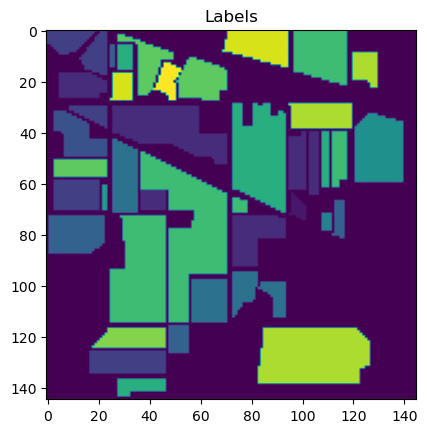

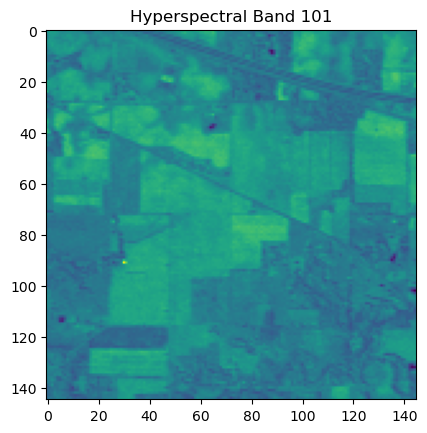

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(608, 5, 5, 200)
(70, 5, 5, 200)
(9571, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)


Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0764, PSNR: 10.6343


Epoch [1/50] Training Loss: 0.0641, PSNR: 11.5138
	[Val]   Batch [1/33] Loss: 0.0498, PSNR: 12.6949
	[Val]   Batch [10/33] Loss: 0.0493, PSNR: 12.3398
	[Val]   Batch [20/33] Loss: 0.0489, PSNR: 11.9330
	[Val]   Batch [30/33] Loss: 0.0474, PSNR: 12.3167
Epoch [1/50] Validation Loss: 0.0495, PSNR: 12.5110

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0503, PSNR: 12.3454


Epoch [2/50] Training Loss: 0.0390, PSNR: 13.6658
	[Val]   Batch [1/33] Loss: 0.0288, PSNR: 15.0725
	[Val]   Batch [10/33] Loss: 0.0283, PSNR: 14.7472
	[Val]   Batch [20/33] Loss: 0.0281, PSNR: 14.3490
	[Val]   Batch [30/33] Loss: 0.0273, PSNR: 14.7122
Epoch [2/50] Validation Loss: 0.0287, PSNR: 14.8762

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0288, PSNR: 15.1880


Epoch [3/50] Training Loss: 0.0228, PSNR: 16.0103
	[Val]   Batch [1/33] Loss: 0.0173, PSNR: 17.2718
	[Val]   Batch [10/33] Loss: 0.0169, PSNR: 16.9893
	[Val]   Batch [20/33] Loss: 0.0166, PSNR: 16.6231
	[Val]   Batch [30/33] Loss: 0.0161, PSNR: 17.0076
Epoch [3/50] Validation Loss: 0.0173, PSNR: 17.0797

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0167, PSNR: 16.9287


Epoch [4/50] Training Loss: 0.0139, PSNR: 18.1214
	[Val]   Batch [1/33] Loss: 0.0113, PSNR: 19.1510
	[Val]   Batch [10/33] Loss: 0.0108, PSNR: 18.9189
	[Val]   Batch [20/33] Loss: 0.0106, PSNR: 18.5930
	[Val]   Batch [30/33] Loss: 0.0102, PSNR: 19.0003
Epoch [4/50] Validation Loss: 0.0112, PSNR: 18.9564

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0105, PSNR: 19.0602


Epoch [5/50] Training Loss: 0.0094, PSNR: 19.8170
	[Val]   Batch [1/33] Loss: 0.0081, PSNR: 20.5556
	[Val]   Batch [10/33] Loss: 0.0077, PSNR: 20.3857
	[Val]   Batch [20/33] Loss: 0.0075, PSNR: 20.0990
	[Val]   Batch [30/33] Loss: 0.0072, PSNR: 20.4988
Epoch [5/50] Validation Loss: 0.0081, PSNR: 20.3586

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0080, PSNR: 20.9591


Epoch [6/50] Training Loss: 0.0070, PSNR: 21.0907
	[Val]   Batch [1/33] Loss: 0.0063, PSNR: 21.6966
	[Val]   Batch [10/33] Loss: 0.0059, PSNR: 21.5947
	[Val]   Batch [20/33] Loss: 0.0056, PSNR: 21.3499
	[Val]   Batch [30/33] Loss: 0.0054, PSNR: 21.7466
Epoch [6/50] Validation Loss: 0.0063, PSNR: 21.4997

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0065, PSNR: 21.6329


Epoch [7/50] Training Loss: 0.0056, PSNR: 22.0904
	[Val]   Batch [1/33] Loss: 0.0051, PSNR: 22.5700
	[Val]   Batch [10/33] Loss: 0.0047, PSNR: 22.5323
	[Val]   Batch [20/33] Loss: 0.0045, PSNR: 22.3284
	[Val]   Batch [30/33] Loss: 0.0043, PSNR: 22.7200
Epoch [7/50] Validation Loss: 0.0051, PSNR: 22.3752

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0047, PSNR: 22.7049


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8734
	[Val]   Batch [1/33] Loss: 0.0043, PSNR: 23.3344
	[Val]   Batch [10/33] Loss: 0.0039, PSNR: 23.3715
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.2015
	[Val]   Batch [30/33] Loss: 0.0035, PSNR: 23.6014
Epoch [8/50] Validation Loss: 0.0043, PSNR: 23.1522

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0037, PSNR: 23.5224


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5101
	[Val]   Batch [1/33] Loss: 0.0038, PSNR: 23.9079
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 24.0057
	[Val]   Batch [20/33] Loss: 0.0031, PSNR: 23.8669
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2972
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.7416

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0042, PSNR: 23.0423


Epoch [10/50] Training Loss: 0.0036, PSNR: 24.0685
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.5070
	[Val]   Batch [10/33] Loss: 0.0029, PSNR: 24.7172
	[Val]   Batch [20/33] Loss: 0.0026, PSNR: 24.6092
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.0449
Epoch [10/50] Validation Loss: 0.0033, PSNR: 24.3900

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0033, PSNR: 24.4042


Epoch [11/50] Training Loss: 0.0031, PSNR: 24.6101
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 24.9671
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2366
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1461
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6239
Epoch [11/50] Validation Loss: 0.0029, PSNR: 24.8862

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0025, PSNR: 25.1239


Epoch [12/50] Training Loss: 0.0028, PSNR: 25.1081
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.4648
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8140
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.7502
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2416
Epoch [12/50] Validation Loss: 0.0026, PSNR: 25.4298

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0042, PSNR: 23.7870


Epoch [13/50] Training Loss: 0.0025, PSNR: 25.5712
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.8573
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2577
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.2183
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.7492
Epoch [13/50] Validation Loss: 0.0023, PSNR: 25.8688

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.8481


Epoch [14/50] Training Loss: 0.0023, PSNR: 25.9704
	[Val]   Batch [1/33] Loss: 0.0022, PSNR: 26.2789
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6942
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.6692
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2274
Epoch [14/50] Validation Loss: 0.0021, PSNR: 26.3015

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.7489


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.4145
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.7809
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.1951
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.1860
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.7412
Epoch [15/50] Validation Loss: 0.0019, PSNR: 26.8108

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.0754


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.7702
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4261
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.7679
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.7602
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.3406
Epoch [16/50] Validation Loss: 0.0016, PSNR: 27.4100

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.6102


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.1841
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8707
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.1661
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.1549
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.7609
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.8345

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.0837


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.5232
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2542
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.4923
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.4898
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.1291
Epoch [18/50] Validation Loss: 0.0014, PSNR: 28.2014

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0016, PSNR: 27.4499


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.8630
	[Val]   Batch [1/33] Loss: 0.0013, PSNR: 28.5819
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.7624
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.7688
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3983
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.5081

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.2098


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1624
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.9319
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.0812
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0907
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7484
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.8452

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 29.0319


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4286
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.2695
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.4497
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.5060
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.2307
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.2223

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.8196


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.6776
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6251
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7953
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.8768
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5744
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.5672

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.7019


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8978
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8192
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 29.9812
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.0924
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8079
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.7656

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.8786


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0595
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.1053
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.2675
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3980
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.1068
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.0749

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.4396


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2144
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.2011
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.3256
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.4421
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.2069
Epoch [25/50] Validation Loss: 0.0009, PSNR: 30.1698

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.5214


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4043
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.4951
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6154
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7700
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5194
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.4687

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 28.9614


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.5161
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6944
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.8098
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9964
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7644
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.6739

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.3354


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6727
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.8838
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.0604
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.2619
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0480
Epoch [28/50] Validation Loss: 0.0007, PSNR: 30.8993

LOG: Epoch [29/50]
	 Training Batch [1/129], Loss: 0.0008, PSNR: 30.4829


Epoch [29/50] Training Loss: 0.0010, PSNR: 29.7738
	[Val]   Batch [1/33] Loss: 0.0007, PSNR: 30.9914
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 31.1175
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.3021
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 32.0755
Epoch [29/50] Validation Loss: 0.0007, PSNR: 30.9665

LOG: Epoch [30/50]
	 Training Batch [1/129], Loss: 0.0008, PSNR: 30.7990


Epoch [30/50] Training Loss: 0.0009, PSNR: 29.8790
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6356
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7182
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8574
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7537
Epoch [30/50] Validation Loss: 0.0008, PSNR: 30.6244
Early stopping triggered at epoch 30. No improvement for 3 epochs.


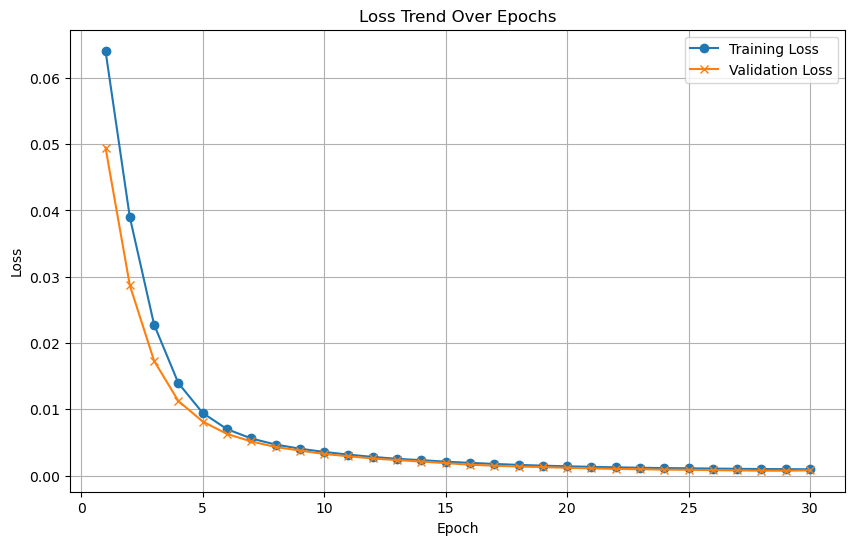

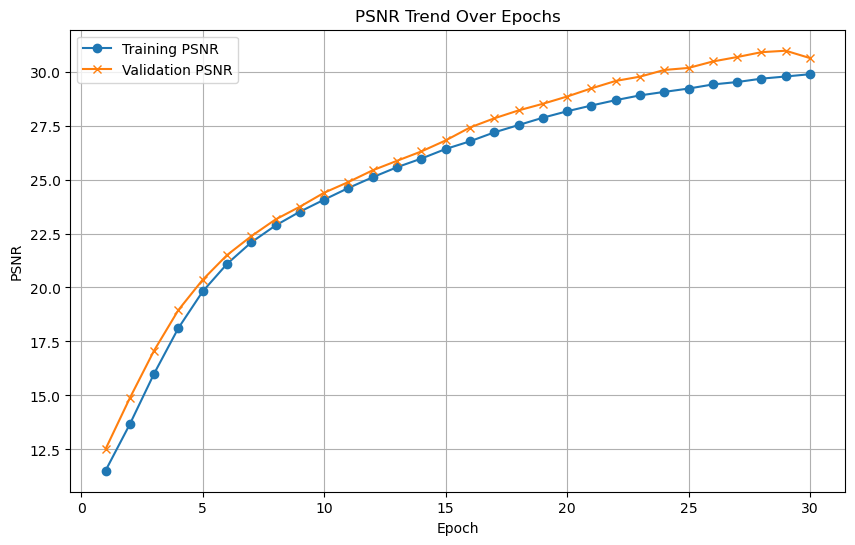

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/38 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7948
    Validation Batch [1/1], Loss: 2.7743
Validation Loss: 2.7743, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.7743. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7688
    Validation Batch [1/1], Loss: 2.7741
Validation Loss: 2.7741, Validation Accuracy: 7.14%
Validation loss improved from 2.7743 to 2.7741. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7553
    Validation Batch [1/1], Loss: 2.7741
Validation Loss: 2.7741, Validation Accuracy: 7.14%
Validation loss improved from 2.7741 to 2.7741. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7439
    Validation Batch [1/1], Loss: 2.7741
Validation Loss: 2.7741, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training


Epoch [5/1000] completed, Average Training Loss: 2.7245
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 2.7101
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 2.7032
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6903
    Validation Batch [1/1], Loss: 2.7742
Validation Loss: 2.7742, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6782
    Validation Batch [1/

    Validation Batch [1/1], Loss: 2.7735
Validation Loss: 2.7735, Validation Accuracy: 7.14%
Validation loss improved from 2.7737 to 2.7735. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.6194
    Validation Batch [1/1], Loss: 2.7732
Validation Loss: 2.7732, Validation Accuracy: 7.14%
Validation loss improved from 2.7735 to 2.7732. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.6063
    Validation Batch [1/1], Loss: 2.7728
Validation Loss: 2.7728, Validation Accuracy: 7.14%
Validation loss improved from 2.7732 to 2.7728. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5995
    Validation Batch [1/1], Loss: 2.7724
Validation Loss: 2.7724, Validation Accuracy: 10.00%
Validation loss improved from 2.7728 to 2.7724. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5916
    Validat

Epoch [27/1000] completed, Average Training Loss: 2.5419
    Validation Batch [1/1], Loss: 2.7622
Validation Loss: 2.7622, Validation Accuracy: 7.14%
Validation loss improved from 2.7644 to 2.7622. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.5300
    Validation Batch [1/1], Loss: 2.7596
Validation Loss: 2.7596, Validation Accuracy: 7.14%
Validation loss improved from 2.7622 to 2.7596. Saving model...

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.5228
    Validation Batch [1/1], Loss: 2.7561
Validation Loss: 2.7561, Validation Accuracy: 7.14%
Validation loss improved from 2.7596 to 2.7561. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.5135
    Validation Batch [1/1], Loss: 2.7516
Validation Loss: 2.7516, Validation Accuracy: 7.14%
Validation loss improved from 2.7561 to 2.7516. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/10

Epoch [38/1000] completed, Average Training Loss: 2.4590
    Validation Batch [1/1], Loss: 2.6913
Validation Loss: 2.6913, Validation Accuracy: 21.43%
Validation loss improved from 2.7015 to 2.6913. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.4358
    Validation Batch [1/1], Loss: 2.6801
Validation Loss: 2.6801, Validation Accuracy: 21.43%
Validation loss improved from 2.6913 to 2.6801. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.4408
    Validation Batch [1/1], Loss: 2.6690
Validation Loss: 2.6690, Validation Accuracy: 21.43%
Validation loss improved from 2.6801 to 2.6690. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.4329
    Validation Batch [1/1], Loss: 2.6572
Validation Loss: 2.6572, Validation Accuracy: 20.00%
Validation loss improved from 2.6690 to 2.6572. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [49/1000] completed, Average Training Loss: 2.3792
    Validation Batch [1/1], Loss: 2.5671
Validation Loss: 2.5671, Validation Accuracy: 21.43%
Validation loss improved from 2.5818 to 2.5671. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.3796
    Validation Batch [1/1], Loss: 2.5461
Validation Loss: 2.5461, Validation Accuracy: 22.86%
Validation loss improved from 2.5671 to 2.5461. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.3742
    Validation Batch [1/1], Loss: 2.5269
Validation Loss: 2.5269, Validation Accuracy: 22.86%
Validation loss improved from 2.5461 to 2.5269. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.3678
    Validation Batch [1/1], Loss: 2.5107
Validation Loss: 2.5107, Validation Accuracy: 22.86%
Validation loss improved from 2.5269 to 2.5107. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [5

Epoch [61/1000] completed, Average Training Loss: 2.3027
    Validation Batch [1/1], Loss: 2.3866
Validation Loss: 2.3866, Validation Accuracy: 30.00%
Validation loss improved from 2.4153 to 2.3866. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.2717
    Validation Batch [1/1], Loss: 2.3699
Validation Loss: 2.3699, Validation Accuracy: 27.14%
Validation loss improved from 2.3866 to 2.3699. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.2891
    Validation Batch [1/1], Loss: 2.3592
Validation Loss: 2.3592, Validation Accuracy: 28.57%
Validation loss improved from 2.3699 to 2.3592. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.2650
    Validation Batch [1/1], Loss: 2.3521
Validation Loss: 2.3521, Validation Accuracy: 28.57%
Validation loss improved from 2.3592 to 2.3521. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

Epoch [73/1000] completed, Average Training Loss: 2.2077
    Validation Batch [1/1], Loss: 2.2971
Validation Loss: 2.2971, Validation Accuracy: 28.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.2073
    Validation Batch [1/1], Loss: 2.3081
Validation Loss: 2.3081, Validation Accuracy: 28.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.2132
    Validation Batch [1/1], Loss: 2.2932
Validation Loss: 2.2932, Validation Accuracy: 28.57%
Validation loss improved from 2.2940 to 2.2932. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.2025
    Validation Batch [1/1], Loss: 2.2616
Validation Loss: 2.2616, Validation Accuracy: 31.43%
Validation loss improved from 2.2932 to 2.2616. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Tra

Epoch [85/1000] completed, Average Training Loss: 2.1237
    Validation Batch [1/1], Loss: 2.1785
Validation Loss: 2.1785, Validation Accuracy: 38.57%
Validation loss improved from 2.1860 to 2.1785. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.1380
    Validation Batch [1/1], Loss: 2.1893
Validation Loss: 2.1893, Validation Accuracy: 34.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 2.1227
    Validation Batch [1/1], Loss: 2.2073
Validation Loss: 2.2073, Validation Accuracy: 30.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 2.0924
    Validation Batch [1/1], Loss: 2.1780
Validation Loss: 2.1780, Validation Accuracy: 34.29%
Validation loss improved from 2.1785 to 2.1780. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Tra

Epoch [96/1000] completed, Average Training Loss: 2.0516
    Validation Batch [1/1], Loss: 2.1214
Validation Loss: 2.1214, Validation Accuracy: 38.57%
Validation loss improved from 2.1279 to 2.1214. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 2.0491
    Validation Batch [1/1], Loss: 2.1162
Validation Loss: 2.1162, Validation Accuracy: 38.57%
Validation loss improved from 2.1214 to 2.1162. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 2.0414
    Validation Batch [1/1], Loss: 2.0974
Validation Loss: 2.0974, Validation Accuracy: 41.43%
Validation loss improved from 2.1162 to 2.0974. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 2.0534
    Validation Batch [1/1], Loss: 2.0906
Validation Loss: 2.0906, Validation Accuracy: 47.14%
Validation loss improved from 2.0974 to 2.0906. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [

Epoch [109/1000] completed, Average Training Loss: 1.9344
    Validation Batch [1/1], Loss: 2.0225
Validation Loss: 2.0225, Validation Accuracy: 45.71%
Validation loss improved from 2.0266 to 2.0225. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.9552
    Validation Batch [1/1], Loss: 2.0201
Validation Loss: 2.0201, Validation Accuracy: 40.00%
Validation loss improved from 2.0225 to 2.0201. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.9356
    Validation Batch [1/1], Loss: 2.0233
Validation Loss: 2.0233, Validation Accuracy: 37.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.9308
    Validation Batch [1/1], Loss: 2.0009
Validation Loss: 2.0009, Validation Accuracy: 44.29%
Validation loss improved from 2.0201 to 2.0009. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000

Epoch [119/1000] completed, Average Training Loss: 1.8649
    Validation Batch [1/1], Loss: 1.9769
Validation Loss: 1.9769, Validation Accuracy: 48.57%
Validation loss improved from 1.9834 to 1.9769. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.8713
    Validation Batch [1/1], Loss: 1.9820
Validation Loss: 1.9820, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.8388
    Validation Batch [1/1], Loss: 1.9804
Validation Loss: 1.9804, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.8375
    Validation Batch [1/1], Loss: 1.9651
Validation Loss: 1.9651, Validation Accuracy: 51.43%
Validation loss improved from 1.9769 to 1.9651. Saving model...

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Av

Epoch [132/1000] completed, Average Training Loss: 1.7557
    Validation Batch [1/1], Loss: 1.9028
Validation Loss: 1.9028, Validation Accuracy: 50.00%
Validation loss improved from 1.9125 to 1.9028. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 1.7884
    Validation Batch [1/1], Loss: 1.9397
Validation Loss: 1.9397, Validation Accuracy: 44.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 1.7473
    Validation Batch [1/1], Loss: 1.9496
Validation Loss: 1.9496, Validation Accuracy: 41.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 1.7249
    Validation Batch [1/1], Loss: 1.8769
Validation Loss: 1.8769, Validation Accuracy: 58.57%
Validation loss improved from 1.9028 to 1.8769. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Av

Epoch [142/1000] completed, Average Training Loss: 1.6727
    Validation Batch [1/1], Loss: 1.9043
Validation Loss: 1.9043, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.6826
    Validation Batch [1/1], Loss: 1.8974
Validation Loss: 1.8974, Validation Accuracy: 58.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.6503
    Validation Batch [1/1], Loss: 1.8373
Validation Loss: 1.8373, Validation Accuracy: 54.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.6503
    Validation Batch [1/1], Loss: 1.8604
Validation Loss: 1.8604, Validation Accuracy: 48.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.6535
  

Epoch [155/1000] completed, Average Training Loss: 1.5653
    Validation Batch [1/1], Loss: 1.7371
Validation Loss: 1.7371, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.5690
    Validation Batch [1/1], Loss: 1.7272
Validation Loss: 1.7272, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.5867
    Validation Batch [1/1], Loss: 1.6584
Validation Loss: 1.6584, Validation Accuracy: 62.86%
Validation loss improved from 1.7173 to 1.6584. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.5959
    Validation Batch [1/1], Loss: 1.6563
Validation Loss: 1.6563, Validation Accuracy: 62.86%
Validation loss improved from 1.6584 to 1.6563. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Av

Epoch [165/1000] completed, Average Training Loss: 1.4878
    Validation Batch [1/1], Loss: 1.6190
Validation Loss: 1.6190, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.5075
    Validation Batch [1/1], Loss: 1.6170
Validation Loss: 1.6170, Validation Accuracy: 67.14%
Validation loss improved from 1.6186 to 1.6170. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.4767
    Validation Batch [1/1], Loss: 1.6591
Validation Loss: 1.6591, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.4678
    Validation Batch [1/1], Loss: 1.5815
Validation Loss: 1.5815, Validation Accuracy: 60.00%
Validation loss improved from 1.6170 to 1.5815. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Av

Epoch [179/1000] completed, Average Training Loss: 1.3910
    Validation Batch [1/1], Loss: 1.4635
Validation Loss: 1.4635, Validation Accuracy: 72.86%
Validation loss improved from 1.5116 to 1.4635. Saving model...

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.3639
    Validation Batch [1/1], Loss: 1.5003
Validation Loss: 1.5003, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.3920
    Validation Batch [1/1], Loss: 1.4491
Validation Loss: 1.4491, Validation Accuracy: 67.14%
Validation loss improved from 1.4635 to 1.4491. Saving model...

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.3884
    Validation Batch [1/1], Loss: 1.4174
Validation Loss: 1.4174, Validation Accuracy: 65.71%
Validation loss improved from 1.4491 to 1.4174. Saving model...

LOG: Epoch [183/1000] - Training
Epoch [183/1000

Epoch [189/1000] completed, Average Training Loss: 1.3228
    Validation Batch [1/1], Loss: 1.4704
Validation Loss: 1.4704, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.3296
    Validation Batch [1/1], Loss: 1.4049
Validation Loss: 1.4049, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.2982
    Validation Batch [1/1], Loss: 1.3818
Validation Loss: 1.3818, Validation Accuracy: 72.86%
Validation loss improved from 1.3914 to 1.3818. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.2657
    Validation Batch [1/1], Loss: 1.4386
Validation Loss: 1.4386, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2851
Validation Loss: 1.2851, Validation Accuracy: 72.86%
Validation loss improved from 1.3094 to 1.2851. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 1.1994
    Validation Batch [1/1], Loss: 1.2878
Validation Loss: 1.2878, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 1.2018
    Validation Batch [1/1], Loss: 1.3187
Validation Loss: 1.3187, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 1.1705
    Validation Batch [1/1], Loss: 1.2589
Validation Loss: 1.2589, Validation Accuracy: 72.86%
Validation loss improved from 1.2851 to 1.2589. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 1.1513
    Validation Batch [1/1], Lo

Epoch [211/1000] completed, Average Training Loss: 1.1385
    Validation Batch [1/1], Loss: 1.3273
Validation Loss: 1.3273, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 1.1500
    Validation Batch [1/1], Loss: 1.2594
Validation Loss: 1.2594, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 1.0857
    Validation Batch [1/1], Loss: 1.2169
Validation Loss: 1.2169, Validation Accuracy: 78.57%
Validation loss improved from 1.2222 to 1.2169. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 1.0959
    Validation Batch [1/1], Loss: 1.1919
Validation Loss: 1.1919, Validation Accuracy: 77.14%
Validation loss improved from 1.2169 to 1.1919. Saving model...

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Av

    Validation Batch [1/1], Loss: 1.1896
Validation Loss: 1.1896, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 1.0450
    Validation Batch [1/1], Loss: 1.2034
Validation Loss: 1.2034, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Average Training Loss: 1.0348
    Validation Batch [1/1], Loss: 1.1780
Validation Loss: 1.1780, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [224/1000] - Training
Epoch [224/1000] completed, Average Training Loss: 1.0083
    Validation Batch [1/1], Loss: 1.0912
Validation Loss: 1.0912, Validation Accuracy: 77.14%
Validation loss improved from 1.1335 to 1.0912. Saving model...

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 1.0301
    Validation Batch [1/1], Loss: 1.2243
Vali

Epoch [233/1000] completed, Average Training Loss: 0.9811
    Validation Batch [1/1], Loss: 1.2303
Validation Loss: 1.2303, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.9501
    Validation Batch [1/1], Loss: 1.1905
Validation Loss: 1.1905, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.9807
    Validation Batch [1/1], Loss: 1.0524
Validation Loss: 1.0524, Validation Accuracy: 77.14%
Validation loss improved from 1.0912 to 1.0524. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.9464
    Validation Batch [1/1], Loss: 1.1671
Validation Loss: 1.1671, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training

Epoch [243/1000] completed, Average Training Loss: 0.9087
    Validation Batch [1/1], Loss: 1.0944
Validation Loss: 1.0944, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.8822
    Validation Batch [1/1], Loss: 1.1483
Validation Loss: 1.1483, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.8973
    Validation Batch [1/1], Loss: 1.0969
Validation Loss: 1.0969, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.9044
    Validation Batch [1/1], Loss: 1.3645
Validation Loss: 1.3645, Validation Accuracy: 55.71%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.8579
  

    Validation Batch [1/1], Loss: 1.0691
Validation Loss: 1.0691, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.8279
    Validation Batch [1/1], Loss: 0.9602
Validation Loss: 0.9602, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.7895
    Validation Batch [1/1], Loss: 0.9566
Validation Loss: 0.9566, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.7903
    Validation Batch [1/1], Loss: 0.9158
Validation Loss: 0.9158, Validation Accuracy: 78.57%
Validation loss improved from 0.9276 to 0.9158. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.7850
    Validation Batch [1/1], Loss: 0.9835
Vali

Epoch [268/1000] completed, Average Training Loss: 0.7314
    Validation Batch [1/1], Loss: 0.8774
Validation Loss: 0.8774, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.7452
    Validation Batch [1/1], Loss: 0.9423
Validation Loss: 0.9423, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.7429
    Validation Batch [1/1], Loss: 0.9791
Validation Loss: 0.9791, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.6997
    Validation Batch [1/1], Loss: 0.9737
Validation Loss: 0.9737, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.7138
  

    Validation Batch [1/1], Loss: 0.8159
Validation Loss: 0.8159, Validation Accuracy: 81.43%
Validation loss improved from 0.8374 to 0.8159. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.6562
    Validation Batch [1/1], Loss: 0.8309
Validation Loss: 0.8309, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.6593
    Validation Batch [1/1], Loss: 0.9165
Validation Loss: 0.9165, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.6718
    Validation Batch [1/1], Loss: 0.9845
Validation Loss: 0.9845, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.6315
    Validation Batch [1/1], Loss: 0.8835
Vali

    Validation Batch [1/1], Loss: 0.7348
Validation Loss: 0.7348, Validation Accuracy: 85.71%
Validation loss improved from 0.7988 to 0.7348. Saving model...

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.6310
    Validation Batch [1/1], Loss: 0.9519
Validation Loss: 0.9519, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.6095
    Validation Batch [1/1], Loss: 1.1681
Validation Loss: 1.1681, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.6143
    Validation Batch [1/1], Loss: 0.8022
Validation Loss: 0.8022, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.6031
    Validation Batch [1/1], Loss: 0.8066
Vali

Epoch [304/1000] completed, Average Training Loss: 0.5516
    Validation Batch [1/1], Loss: 0.7644
Validation Loss: 0.7644, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.5398
    Validation Batch [1/1], Loss: 0.9517
Validation Loss: 0.9517, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [306/1000] - Training


Epoch [306/1000] completed, Average Training Loss: 0.5641
    Validation Batch [1/1], Loss: 0.7060
Validation Loss: 0.7060, Validation Accuracy: 87.14%
Validation loss improved from 0.7348 to 0.7060. Saving model...

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.5478
    Validation Batch [1/1], Loss: 0.7752
Validation Loss: 0.7752, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.5458
    Validation Batch [1/1], Loss: 0.8100
Validation Loss: 0.8100, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.5065
    Validation Batch [1/1], Loss: 0.7087
Validation Loss: 0.7087, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training 

Epoch [315/1000] completed, Average Training Loss: 0.5096
    Validation Batch [1/1], Loss: 0.8725
Validation Loss: 0.8725, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.5142
    Validation Batch [1/1], Loss: 0.6771
Validation Loss: 0.6771, Validation Accuracy: 84.29%
Validation loss improved from 0.7060 to 0.6771. Saving model...

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.4811
    Validation Batch [1/1], Loss: 1.1598
Validation Loss: 1.1598, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.4577
    Validation Batch [1/1], Loss: 0.7348
Validation Loss: 0.7348, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training 

Epoch [330/1000] completed, Average Training Loss: 0.4433
    Validation Batch [1/1], Loss: 0.6859
Validation Loss: 0.6859, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.4086
    Validation Batch [1/1], Loss: 0.7141
Validation Loss: 0.7141, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.4360
    Validation Batch [1/1], Loss: 0.6857
Validation Loss: 0.6857, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.4178
    Validation Batch [1/1], Loss: 0.9925
Validation Loss: 0.9925, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.404

Epoch [338/1000] completed, Average Training Loss: 0.4362
    Validation Batch [1/1], Loss: 0.9090
Validation Loss: 0.9090, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.3886
    Validation Batch [1/1], Loss: 0.7114
Validation Loss: 0.7114, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.4137
    Validation Batch [1/1], Loss: 0.6490
Validation Loss: 0.6490, Validation Accuracy: 78.57%
Validation loss improved from 0.6678 to 0.6490. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3666
    Validation Batch [1/1], Loss: 0.6529
Validation Loss: 0.6529, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.9113
Validation Loss: 0.9113, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.3672
    Validation Batch [1/1], Loss: 0.6406
Validation Loss: 0.6406, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.3669
    Validation Batch [1/1], Loss: 0.5844
Validation Loss: 0.5844, Validation Accuracy: 85.71%
Validation loss improved from 0.5984 to 0.5844. Saving model...

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.3458
    Validation Batch [1/1], Loss: 0.6815
Validation Loss: 0.6815, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.3538
    Validation Batch [1/1], Loss: 0.7351
Vali

    Validation Batch [1/1], Loss: 0.7497
Validation Loss: 0.7497, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.3645
    Validation Batch [1/1], Loss: 0.5991
Validation Loss: 0.5991, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.3310
    Validation Batch [1/1], Loss: 0.5587
Validation Loss: 0.5587, Validation Accuracy: 88.57%
Validation loss improved from 0.5844 to 0.5587. Saving model...

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.3221
    Validation Batch [1/1], Loss: 0.5792
Validation Loss: 0.5792, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2873
    Validation Batch [1/1], Loss: 0.6473
Vali

Epoch [376/1000] completed, Average Training Loss: 0.2858
    Validation Batch [1/1], Loss: 0.6052
Validation Loss: 0.6052, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2706
    Validation Batch [1/1], Loss: 0.6583
Validation Loss: 0.6583, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2807
    Validation Batch [1/1], Loss: 0.6577
Validation Loss: 0.6577, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.3086
    Validation Batch [1/1], Loss: 0.8551
Validation Loss: 0.8551, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2703
  

Epoch [384/1000] completed, Average Training Loss: 0.2708
    Validation Batch [1/1], Loss: 0.7429
Validation Loss: 0.7429, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [385/1000] - Training
Epoch [385/1000] completed, Average Training Loss: 0.2781
    Validation Batch [1/1], Loss: 0.6720
Validation Loss: 0.6720, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.2576
    Validation Batch [1/1], Loss: 0.5353
Validation Loss: 0.5353, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2678
    Validation Batch [1/1], Loss: 0.5203
Validation Loss: 0.5203, Validation Accuracy: 85.71%
Validation loss improved from 0.5258 to 0.5203. Saving model...

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.7220
Validation Loss: 0.7220, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2439
    Validation Batch [1/1], Loss: 0.6694
Validation Loss: 0.6694, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.2424
    Validation Batch [1/1], Loss: 0.6036
Validation Loss: 0.6036, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.2209
    Validation Batch [1/1], Loss: 0.7009
Validation Loss: 0.7009, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.2398
    Validation Batch [1/1], Loss: 0.5230
Validation Loss

Epoch [408/1000] completed, Average Training Loss: 0.2179
    Validation Batch [1/1], Loss: 0.7105
Validation Loss: 0.7105, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.2192
    Validation Batch [1/1], Loss: 0.6374
Validation Loss: 0.6374, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.2031
    Validation Batch [1/1], Loss: 0.5832
Validation Loss: 0.5832, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.2204
    Validation Batch [1/1], Loss: 0.7066
Validation Loss: 0.7066, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.211

Epoch [421/1000] completed, Average Training Loss: 0.2134
    Validation Batch [1/1], Loss: 0.5797
Validation Loss: 0.5797, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.2072
    Validation Batch [1/1], Loss: 0.5913
Validation Loss: 0.5913, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1881
    Validation Batch [1/1], Loss: 0.5126
Validation Loss: 0.5126, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.2078
    Validation Batch [1/1], Loss: 0.5130
Validation Loss: 0.5130, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1998
  

Epoch [430/1000] completed, Average Training Loss: 0.1952
    Validation Batch [1/1], Loss: 1.0337
Validation Loss: 1.0337, Validation Accuracy: 71.43%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.2143
    Validation Batch [1/1], Loss: 1.6636
Validation Loss: 1.6636, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1884
    Validation Batch [1/1], Loss: 0.9504
Validation Loss: 0.9504, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.2059
    Validation Batch [1/1], Loss: 0.7367
Validation Loss: 0.7367, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.190

    Validation Batch [1/1], Loss: 0.4720
Validation Loss: 0.4720, Validation Accuracy: 85.71%
Validation loss improved from 0.4950 to 0.4720. Saving model...

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1709
    Validation Batch [1/1], Loss: 0.4836
Validation Loss: 0.4836, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1494
    Validation Batch [1/1], Loss: 0.4591
Validation Loss: 0.4591, Validation Accuracy: 87.14%
Validation loss improved from 0.4720 to 0.4591. Saving model...

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1610
    Validation Batch [1/1], Loss: 0.4635
Validation Loss: 0.4635, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1550
    Validation Batch [1/1], Lo

Epoch [453/1000] completed, Average Training Loss: 0.1452
    Validation Batch [1/1], Loss: 0.5135
Validation Loss: 0.5135, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1561
    Validation Batch [1/1], Loss: 0.5245
Validation Loss: 0.5245, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1580
    Validation Batch [1/1], Loss: 0.5594
Validation Loss: 0.5594, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1518
    Validation Batch [1/1], Loss: 0.4766
Validation Loss: 0.4766, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1448
  

Epoch [467/1000] completed, Average Training Loss: 0.1456
    Validation Batch [1/1], Loss: 0.7406
Validation Loss: 0.7406, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1470
    Validation Batch [1/1], Loss: 0.7042
Validation Loss: 0.7042, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1446
    Validation Batch [1/1], Loss: 0.5585
Validation Loss: 0.5585, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.1305
    Validation Batch [1/1], Loss: 0.5610
Validation Loss: 0.5610, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1406
  

Epoch [475/1000] completed, Average Training Loss: 0.1413
    Validation Batch [1/1], Loss: 0.4494
Validation Loss: 0.4494, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.1193
    Validation Batch [1/1], Loss: 0.5978
Validation Loss: 0.5978, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1220
    Validation Batch [1/1], Loss: 0.7717
Validation Loss: 0.7717, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1360
    Validation Batch [1/1], Loss: 0.5531
Validation Loss: 0.5531, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1340
  

    Validation Batch [1/1], Loss: 0.4657
Validation Loss: 0.4657, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1200
    Validation Batch [1/1], Loss: 0.8829
Validation Loss: 0.8829, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.1193
    Validation Batch [1/1], Loss: 0.7798
Validation Loss: 0.7798, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1226
    Validation Batch [1/1], Loss: 0.5330
Validation Loss: 0.5330, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1218
    Validation Batch [1/1], Loss: 0.5923
Validation Loss

Epoch [499/1000] completed, Average Training Loss: 0.1173
    Validation Batch [1/1], Loss: 1.0898
Validation Loss: 1.0898, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.1363
    Validation Batch [1/1], Loss: 0.8835
Validation Loss: 0.8835, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1153
    Validation Batch [1/1], Loss: 0.7086
Validation Loss: 0.7086, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1203
    Validation Batch [1/1], Loss: 0.5695
Validation Loss: 0.5695, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.108

Epoch [513/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 0.7448
Validation Loss: 0.7448, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.1111
    Validation Batch [1/1], Loss: 0.6092
Validation Loss: 0.6092, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.1077
    Validation Batch [1/1], Loss: 0.4608
Validation Loss: 0.4608, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 0.6616
Validation Loss: 0.6616, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.117

Epoch [521/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 0.6286
Validation Loss: 0.6286, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0935
    Validation Batch [1/1], Loss: 0.6830
Validation Loss: 0.6830, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0991
    Validation Batch [1/1], Loss: 0.6676
Validation Loss: 0.6676, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.1153
    Validation Batch [1/1], Loss: 0.8132
Validation Loss: 0.8132, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.099

    Validation Batch [1/1], Loss: 0.4546
Validation Loss: 0.4546, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.0822
    Validation Batch [1/1], Loss: 0.4702
Validation Loss: 0.4702, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.1036
    Validation Batch [1/1], Loss: 0.4551
Validation Loss: 0.4551, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.1014
    Validation Batch [1/1], Loss: 0.4364
Validation Loss: 0.4364, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 0.5507
Validation Loss

    Validation Batch [1/1], Loss: 1.1005
Validation Loss: 1.1005, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 0.6229
Validation Loss: 0.6229, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0865
    Validation Batch [1/1], Loss: 0.5359
Validation Loss: 0.5359, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0893
    Validation Batch [1/1], Loss: 0.5198
Validation Loss: 0.5198, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0961
    Validation Batch [1/1], Loss: 0.5206
Validation Loss

Epoch [558/1000] completed, Average Training Loss: 0.0947
    Validation Batch [1/1], Loss: 1.4675
Validation Loss: 1.4675, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0847
    Validation Batch [1/1], Loss: 0.7728
Validation Loss: 0.7728, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.4305
Validation Loss: 0.4305, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0842
    Validation Batch [1/1], Loss: 0.6358
Validation Loss: 0.6358, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0816


Epoch [567/1000] completed, Average Training Loss: 0.0875
    Validation Batch [1/1], Loss: 0.5092
Validation Loss: 0.5092, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.6057
Validation Loss: 0.6057, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0682
    Validation Batch [1/1], Loss: 0.5614
Validation Loss: 0.5614, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0826
    Validation Batch [1/1], Loss: 0.4521
Validation Loss: 0.4521, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.081

    Validation Batch [1/1], Loss: 0.5273
Validation Loss: 0.5273, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.5343
Validation Loss: 0.5343, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.5591
Validation Loss: 0.5591, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.7124
Validation Loss: 0.7124, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0701
    Validation Batch [1/1], Loss: 0.6961
Validation Loss

Epoch [591/1000] completed, Average Training Loss: 0.0723
    Validation Batch [1/1], Loss: 0.4111
Validation Loss: 0.4111, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0656
    Validation Batch [1/1], Loss: 0.4645
Validation Loss: 0.4645, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.5945
Validation Loss: 0.5945, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0674
    Validation Batch [1/1], Loss: 0.6133
Validation Loss: 0.6133, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Average Training Loss: 0.063

Epoch [603/1000] completed, Average Training Loss: 0.0637
    Validation Batch [1/1], Loss: 0.4448
Validation Loss: 0.4448, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0599
    Validation Batch [1/1], Loss: 0.4078
Validation Loss: 0.4078, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.4910
Validation Loss: 0.4910, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0562
    Validation Batch [1/1], Loss: 0.5109
Validation Loss: 0.5109, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.068

Epoch [615/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.8303
Validation Loss: 0.8303, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.5589
Validation Loss: 0.5589, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0709
    Validation Batch [1/1], Loss: 0.4678
Validation Loss: 0.4678, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0732
    Validation Batch [1/1], Loss: 0.5002
Validation Loss: 0.5002, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.070

Epoch [626/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.4737
Validation Loss: 0.4737, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0521
    Validation Batch [1/1], Loss: 0.4959
Validation Loss: 0.4959, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.5337
Validation Loss: 0.5337, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [629/1000] - Training
Epoch [629/1000] completed, Average Training Loss: 0.0641
    Validation Batch [1/1], Loss: 0.4329
Validation Loss: 0.4329, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [630/1000] - Training
Epoch [630/1000] completed, Average Training Loss: 0.052

Epoch [639/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.7729
Validation Loss: 0.7729, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0535
    Validation Batch [1/1], Loss: 0.4153
Validation Loss: 0.4153, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.4588
Validation Loss: 0.4588, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.7304
Validation Loss: 0.7304, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [643/1000] - Training
Epoch [643/1000] completed, Average Training Loss: 0.049

Epoch [649/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.6114
Validation Loss: 0.6114, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0552
    Validation Batch [1/1], Loss: 0.4387
Validation Loss: 0.4387, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 650. No improvement for 100 epochs.
Loading the best model weights...


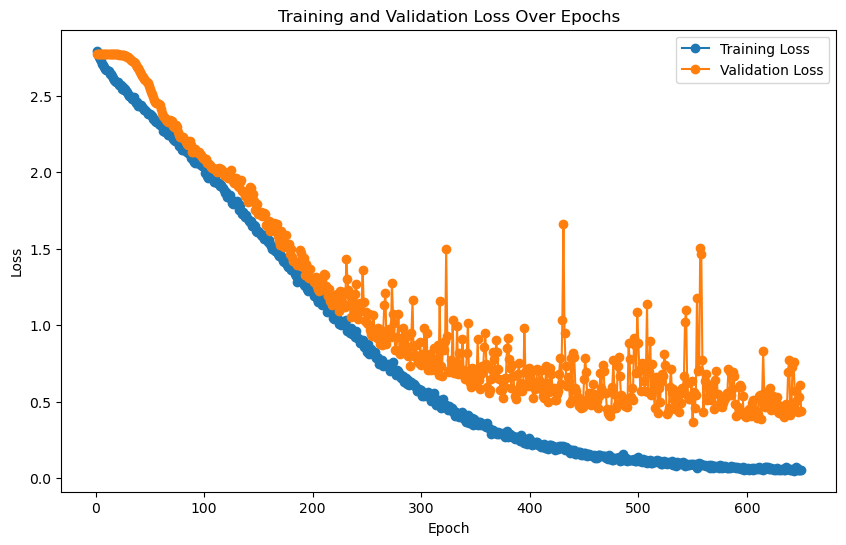

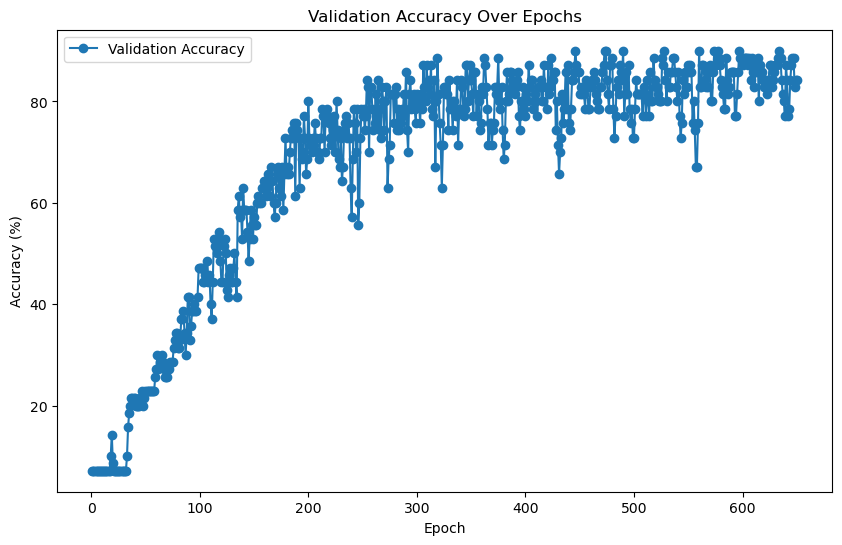


Evaluating on the test set...
    Test Batch [1/38], Loss: 1.7236



Final Test Loss: 1.0917, Test Accuracy: 70.27%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/38 for test dataset.


  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (9571, 64), Test labels shape: (9571,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.62      1.00      0.77         5
           1       0.50      0.40      0.44         5
           2       0.25      0.20      0.22         5
           3       1.00      0.80      0.89         5
           4       1.00      0.60      0.75         5
           5       0.80      0.80      0.80         5
           6       0.00      0.00      0.00         0
           7       0.50      0.20      0.29         5
           9       0.83      1.00  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (9571, 64)
Test labels shape: (9571,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8241  |  Val Loss: 2.7321
Validation loss improved from inf to 2.7321.


[Epoch 2/1000] Train Loss: 2.7100  |  Val Loss: 2.6751
Validation loss improved from 2.7321 to 2.6751.
[Epoch 3/1000] Train Loss: 2.6248  |  Val Loss: 2.5987
Validation loss improved from 2.6751 to 2.5987.
[Epoch 4/1000] Train Loss: 2.5533  |  Val Loss: 2.5202
Validation loss improved from 2.5987 to 2.5202.
[Epoch 5/1000] Train Loss: 2.4831  |  Val Loss: 2.4569
Validation loss improved from 2.5202 to 2.4569.
[Epoch 6/1000] Train Loss: 2.4008  |  Val Loss: 2.3840
Validation loss improved from 2.4569 to 2.3840.
[Epoch 7/1000] Train Loss: 2.3122  |  Val Loss: 2.2978
Validation loss improved from 2.3840 to 2.2978.
[Epoch 8/1000] Train Loss: 2.2162  |  Val Loss: 2.2007
Validation loss improved from 2.2978 to 2.2007.
[Epoch 9/1000] Train Loss: 2.1210  |  Val Loss: 2.1173
Validation loss improved from 2.2007 to 2.1173.
[Epoch 10/1000] Train Loss: 2.0337  |  Val Loss: 2.0273
Validation loss improved from 2.1173 to 2.0273.
[Epoch 11/1000] Train Loss: 1.9534  |  Val Loss: 1.9396
Validation loss 

[Epoch 15/1000] Train Loss: 1.6624  |  Val Loss: 1.6735
Validation loss improved from 1.7352 to 1.6735.
[Epoch 16/1000] Train Loss: 1.6015  |  Val Loss: 1.6041
Validation loss improved from 1.6735 to 1.6041.
[Epoch 17/1000] Train Loss: 1.5518  |  Val Loss: 1.5658
Validation loss improved from 1.6041 to 1.5658.
[Epoch 18/1000] Train Loss: 1.5046  |  Val Loss: 1.5193
Validation loss improved from 1.5658 to 1.5193.


[Epoch 19/1000] Train Loss: 1.4703  |  Val Loss: 1.4921
Validation loss improved from 1.5193 to 1.4921.
[Epoch 20/1000] Train Loss: 1.4273  |  Val Loss: 1.4444
Validation loss improved from 1.4921 to 1.4444.
[Epoch 21/1000] Train Loss: 1.3753  |  Val Loss: 1.4188
Validation loss improved from 1.4444 to 1.4188.
[Epoch 22/1000] Train Loss: 1.3423  |  Val Loss: 1.3661
Validation loss improved from 1.4188 to 1.3661.
[Epoch 23/1000] Train Loss: 1.3084  |  Val Loss: 1.3508
Validation loss improved from 1.3661 to 1.3508.
[Epoch 24/1000] Train Loss: 1.2743  |  Val Loss: 1.3121
Validation loss improved from 1.3508 to 1.3121.
[Epoch 25/1000] Train Loss: 1.2475  |  Val Loss: 1.2883
Validation loss improved from 1.3121 to 1.2883.
[Epoch 26/1000] Train Loss: 1.2145  |  Val Loss: 1.2745
Validation loss improved from 1.2883 to 1.2745.
[Epoch 27/1000] Train Loss: 1.2019  |  Val Loss: 1.2518
Validation loss improved from 1.2745 to 1.2518.
[Epoch 28/1000] Train Loss: 1.1598  |  Val Loss: 1.2228
Validati

[Epoch 35/1000] Train Loss: 1.0319  |  Val Loss: 1.1024
Validation loss improved from 1.1195 to 1.1024.
[Epoch 36/1000] Train Loss: 1.0273  |  Val Loss: 1.1343
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.9959  |  Val Loss: 1.0859
Validation loss improved from 1.1024 to 1.0859.
[Epoch 38/1000] Train Loss: 0.9786  |  Val Loss: 1.0656
Validation loss improved from 1.0859 to 1.0656.
[Epoch 39/1000] Train Loss: 0.9635  |  Val Loss: 1.0822
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.9511  |  Val Loss: 1.0659
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 0.9327  |  Val Loss: 1.0523
Validation loss improved from 1.0656 to 1.0523.
[Epoch 42/1000] Train Loss: 0.9266  |  Val Loss: 1.0365
Validation loss improved from 1.0523 to 1.0365.
[Epoch 43/1000] Train Loss: 0.8984  |  Val Loss: 1.0229
Validation loss improved from 1.0365 to 1.0229.
[Epoch 44/1000] Train Loss: 0.8958  |  Val Los

[Epoch 53/1000] Train Loss: 0.8126  |  Val Loss: 0.9588
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.7796  |  Val Loss: 0.9603
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 55/1000] Train Loss: 0.7785  |  Val Loss: 0.9253
Validation loss improved from 0.9473 to 0.9253.
[Epoch 56/1000] Train Loss: 0.7647  |  Val Loss: 0.9161
Validation loss improved from 0.9253 to 0.9161.
[Epoch 57/1000] Train Loss: 0.7568  |  Val Loss: 0.9224
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 0.7476  |  Val Loss: 0.9159
Validation loss improved from 0.9161 to 0.9159.
[Epoch 59/1000] Train Loss: 0.7418  |  Val Loss: 0.9020
Validation loss improved from 0.9159 to 0.9020.
[Epoch 60/1000] Train Loss: 0.7213  |  Val Loss: 0.8954
Validation loss improved from 0.9020 to 0.8954.
[Epoch 61/1000] Train Loss: 0.7240  |  Val Loss: 0.8935
Validation loss improved from 0.8954 to 0.8935.
[Epoch 62/1000] Train Loss: 0.7265  |  Val Los

[Epoch 71/1000] Train Loss: 0.6419  |  Val Loss: 0.8213
Validation loss improved from 0.8473 to 0.8213.
[Epoch 72/1000] Train Loss: 0.6416  |  Val Loss: 0.8232
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.6295  |  Val Loss: 0.8514
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.6167  |  Val Loss: 0.8270
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 0.6111  |  Val Loss: 0.8368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 0.5993  |  Val Loss: 0.8251
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 0.5972  |  Val Loss: 0.8111
Validation loss improved from 0.8213 to 0.8111.
[Epoch 78/1000] Train Loss: 0.5910  |  Val Loss: 0.8305
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.5835  |  Val Loss: 0.8126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train 

[Epoch 88/1000] Train Loss: 0.5429  |  Val Loss: 0.7842
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 0.5355  |  Val Loss: 0.7972
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 0.5279  |  Val Loss: 0.7729
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] Train Loss: 0.5283  |  Val Loss: 0.8022
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 92/1000] Train Loss: 0.5176  |  Val Loss: 0.7711
Validation loss improved from 0.7716 to 0.7711.
[Epoch 93/1000] Train Loss: 0.5071  |  Val Loss: 0.7628
Validation loss improved from 0.7711 to 0.7628.
[Epoch 94/1000] Train Loss: 0.4988  |  Val Loss: 0.7668
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 95/1000] Train Loss: 0.5148  |  Val Loss: 0.7979
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 0.5023  |  Val Loss: 0.7751
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 97/1000] Train 

[Epoch 109/1000] Train Loss: 0.4506  |  Val Loss: 0.7372
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 110/1000] Train Loss: 0.4678  |  Val Loss: 0.7423
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 0.4351  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 112/1000] Train Loss: 0.4370  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 113/1000] Train Loss: 0.4244  |  Val Loss: 0.7453
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 114/1000] Train Loss: 0.4337  |  Val Loss: 0.7441
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 115/1000] Train Loss: 0.4262  |  Val Loss: 0.7242
Validation loss improved from 0.7352 to 0.7242.
[Epoch 116/1000] Train Loss: 0.4178  |  Val Loss: 0.7736
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.4072  |  Val Loss: 0.7339
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 128/1000] Train Loss: 0.3565  |  Val Loss: 0.7198
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 0.3559  |  Val Loss: 0.7347
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 0.3499  |  Val Loss: 0.7387
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 0.3468  |  Val Loss: 0.7018
Validation loss improved from 0.7058 to 0.7018.
[Epoch 132/1000] Train Loss: 0.3593  |  Val Loss: 0.7095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 0.3621  |  Val Loss: 0.7371
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 134/1000] Train Loss: 0.3671  |  Val Loss: 0.7458
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 135/1000] Train Loss: 0.3561  |  Val Loss: 0.7217
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 136/1000] Train Loss: 0.3500  |  Val Loss: 0.7280
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 146/1000] Train Loss: 0.3155  |  Val Loss: 0.6845
Validation loss improved from 0.7003 to 0.6845.
[Epoch 147/1000] Train Loss: 0.3072  |  Val Loss: 0.7137
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 148/1000] Train Loss: 0.2970  |  Val Loss: 0.7081
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 149/1000] Train Loss: 0.3133  |  Val Loss: 0.7172
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 150/1000] Train Loss: 0.3104  |  Val Loss: 0.7249
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 151/1000] Train Loss: 0.3083  |  Val Loss: 0.7324
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 152/1000] Train Loss: 0.3194  |  Val Loss: 0.7181
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 153/1000] Train Loss: 0.3096  |  Val Loss: 0.7263
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 154/1000] Train Loss: 0.3013  |  Val Loss: 0.7635
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 166/1000] Train Loss: 0.2635  |  Val Loss: 0.7331
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 167/1000] Train Loss: 0.2567  |  Val Loss: 0.7263
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 168/1000] Train Loss: 0.2616  |  Val Loss: 0.7278
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 169/1000] Train Loss: 0.2680  |  Val Loss: 0.7222
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 170/1000] Train Loss: 0.2610  |  Val Loss: 0.7044
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 171/1000] Train Loss: 0.2588  |  Val Loss: 0.7069
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 172/1000] Train Loss: 0.2713  |  Val Loss: 0.7392
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 173/1000] Train Loss: 0.2843  |  Val Loss: 0.7555
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 174/1000] Train Loss: 0.2755  |  Val Loss: 0.7381
!! Validation loss did NOT improve !! Patience:

[Epoch 186/1000] Train Loss: 0.2283  |  Val Loss: 0.7273
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 187/1000] Train Loss: 0.2210  |  Val Loss: 0.7289
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 188/1000] Train Loss: 0.2173  |  Val Loss: 0.7300
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 189/1000] Train Loss: 0.2185  |  Val Loss: 0.7350
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 190/1000] Train Loss: 0.2213  |  Val Loss: 0.7222
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 191/1000] Train Loss: 0.2156  |  Val Loss: 0.7327
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 192/1000] Train Loss: 0.2103  |  Val Loss: 0.7355
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 193/1000] Train Loss: 0.2104  |  Val Loss: 0.7266
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 194/1000] Train Loss: 0.2050  |  Val Loss: 0.7259
!! Validation loss did NOT improve !! Patience:

[Epoch 206/1000] Train Loss: 0.1884  |  Val Loss: 0.7711
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 207/1000] Train Loss: 0.1887  |  Val Loss: 0.7418
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 208/1000] Train Loss: 0.1847  |  Val Loss: 0.7348
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 209/1000] Train Loss: 0.1873  |  Val Loss: 0.7458
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 210/1000] Train Loss: 0.1894  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 211/1000] Train Loss: 0.1916  |  Val Loss: 0.7990
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 212/1000] Train Loss: 0.1962  |  Val Loss: 0.7343
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 213/1000] Train Loss: 0.1943  |  Val Loss: 0.7451
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 214/1000] Train Loss: 0.1876  |  Val Loss: 0.8055
!! Validation loss did NOT improve !! Patience:

[Epoch 226/1000] Train Loss: 0.1702  |  Val Loss: 0.8247
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 227/1000] Train Loss: 0.1616  |  Val Loss: 0.8038
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 228/1000] Train Loss: 0.1729  |  Val Loss: 0.7986
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 229/1000] Train Loss: 0.1781  |  Val Loss: 0.7417
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 230/1000] Train Loss: 0.1679  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 231/1000] Train Loss: 0.1657  |  Val Loss: 0.7435
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 232/1000] Train Loss: 0.1625  |  Val Loss: 0.7994
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 233/1000] Train Loss: 0.1607  |  Val Loss: 0.8206
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 234/1000] Train Loss: 0.1598  |  Val Loss: 0.7826
!! Validation loss did NOT improve !! Patience:

[Epoch 245/1000] Train Loss: 0.1450  |  Val Loss: 0.8040
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 246/1000] Train Loss: 0.1519  |  Val Loss: 0.8255
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 246 !!
No improvement for 100 epochs.


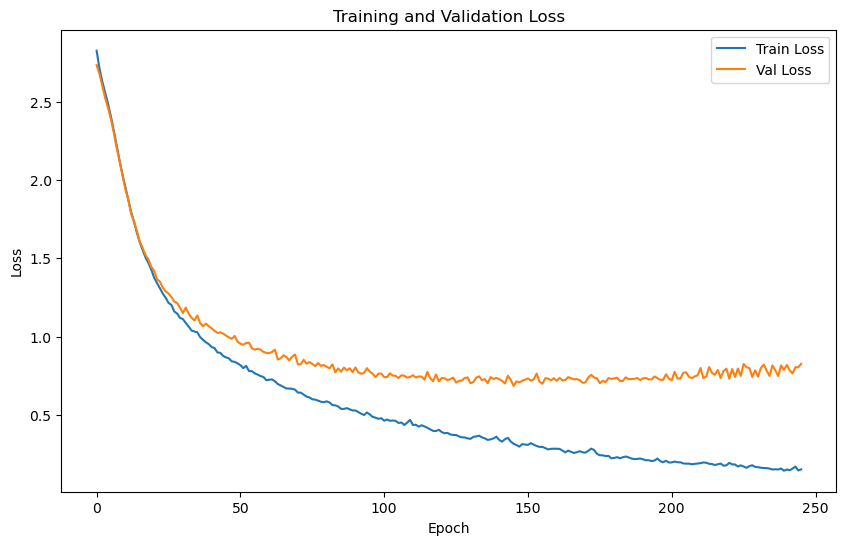

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.3746 | Test Accuracy: 54.40%


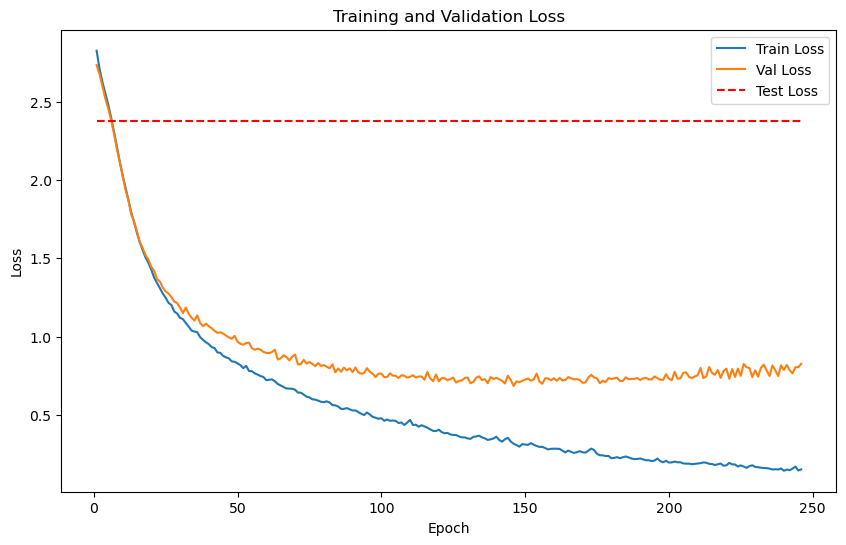

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 9.5384
Epoch [1/2000], Avg Train Loss: 9.5384
Epoch [1/2000], Avg Val Loss: 5.0322
Validation loss improved from inf to 5.0322. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.3372
Epoch [2/2000], Avg Train Loss: 9.3372
Epoch [2/2000], Avg Val Loss: 4.9765
Validation loss improved from 5.0322 to 4.9765. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.2660
Epoch [3/2000], Avg Train Loss: 9.2660
Epoch [3/2000], Avg Val Loss: 4.9215
Validation loss improved from 4.9765 to 4.9215. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.2059
Epoch [4/2000], Avg Train Loss: 9.2059
Epoch [4/2000], Avg Val Loss: 4.8674
Validation loss improved from 4.9215 to 4.8674. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 9.2398
Epoch [5/2000], Avg Train Loss: 9.2398
Epoch [5/2000], Avg Val Loss: 4.8147
Validation loss improved from 4.8674 to 4.8147. Saving mode

Epoch [11/2000], Avg Val Loss: 4.5237
Validation loss improved from 4.5693 to 4.5237. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 8.7056
Epoch [12/2000], Avg Train Loss: 8.7056
Epoch [12/2000], Avg Val Loss: 4.4793
Validation loss improved from 4.5237 to 4.4793. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 8.7040
Epoch [13/2000], Avg Train Loss: 8.7040
Epoch [13/2000], Avg Val Loss: 4.4359
Validation loss improved from 4.4793 to 4.4359. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 8.5050
Epoch [14/2000], Avg Train Loss: 8.5050
Epoch [14/2000], Avg Val Loss: 4.3937
Validation loss improved from 4.4359 to 4.3937. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 8.2679
Epoch [15/2000], Avg Train Loss: 8.2679
Epoch [15/2000], Avg Val Loss: 4.3528
Validation loss improved from 4.3937 to 4.3528. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 8.1160
Epoch [19/2000], Avg Train Loss: 8.1160
Epoch [19/2000], Avg Val Loss: 4.2006
Validation loss improved from 4.2369 to 4.2006. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 8.1259
Epoch [20/2000], Avg Train Loss: 8.1259
Epoch [20/2000], Avg Val Loss: 4.1653
Validation loss improved from 4.2006 to 4.1653. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 8.0021
Epoch [21/2000], Avg Train Loss: 8.0021
Epoch [21/2000], Avg Val Loss: 4.1310
Validation loss improved from 4.1653 to 4.1310. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.8813
Epoch [22/2000], Avg Train Loss: 7.8813
Epoch [22/2000], Avg Val Loss: 4.0979
Validation loss improved from 4.1310 to 4.0979. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.9425
Epoch [23/2000], Avg Train Loss: 7.9425
Epoch [23/2000], Avg Val Loss: 4.0658
Validation loss improved from 4.0979 to 4.

    Batch [1/1], Train Loss: 6.9976
Epoch [37/2000], Avg Train Loss: 6.9976
Epoch [37/2000], Avg Val Loss: 3.7173
Validation loss improved from 3.7365 to 3.7173. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.9857
Epoch [38/2000], Avg Train Loss: 6.9857
Epoch [38/2000], Avg Val Loss: 3.6988
Validation loss improved from 3.7173 to 3.6988. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.9056
Epoch [39/2000], Avg Train Loss: 6.9056
Epoch [39/2000], Avg Val Loss: 3.6811
Validation loss improved from 3.6988 to 3.6811. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.8891
Epoch [40/2000], Avg Train Loss: 6.8891
Epoch [40/2000], Avg Val Loss: 3.6642
Validation loss improved from 3.6811 to 3.6642. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.8805
Epoch [41/2000], Avg Train Loss: 6.8805
Epoch [41/2000], Avg Val Loss: 3.6480
Validation loss improved from 3.6642 to 3.

Epoch [47/2000], Avg Val Loss: 3.5645
Validation loss improved from 3.5770 to 3.5645. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.5485
Epoch [48/2000], Avg Train Loss: 6.5485
Epoch [48/2000], Avg Val Loss: 3.5524
Validation loss improved from 3.5645 to 3.5524. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.5378
Epoch [49/2000], Avg Train Loss: 6.5378
Epoch [49/2000], Avg Val Loss: 3.5409
Validation loss improved from 3.5524 to 3.5409. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 6.5508
Epoch [50/2000], Avg Train Loss: 6.5508
Epoch [50/2000], Avg Val Loss: 3.5299
Validation loss improved from 3.5409 to 3.5299. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 6.4909
Epoch [51/2000], Avg Train Loss: 6.4909
Epoch [51/2000], Avg Val Loss: 3.5193
Validation loss improved from 3.5299 to 3.5193. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Trai

Epoch [54/2000], Avg Val Loss: 3.4902
Validation loss improved from 3.4995 to 3.4902. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 6.4240
Epoch [55/2000], Avg Train Loss: 6.4240
Epoch [55/2000], Avg Val Loss: 3.4813
Validation loss improved from 3.4902 to 3.4813. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.2588
Epoch [56/2000], Avg Train Loss: 6.2588
Epoch [56/2000], Avg Val Loss: 3.4728
Validation loss improved from 3.4813 to 3.4728. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 6.2500
Epoch [57/2000], Avg Train Loss: 6.2500
Epoch [57/2000], Avg Val Loss: 3.4646
Validation loss improved from 3.4728 to 3.4646. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 6.2437
Epoch [58/2000], Avg Train Loss: 6.2437
Epoch [58/2000], Avg Val Loss: 3.4568
Validation loss improved from 3.4646 to 3.4568. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.9664
Epoch [70/2000], Avg Train Loss: 5.9664
Epoch [70/2000], Avg Val Loss: 3.3861
Validation loss improved from 3.3906 to 3.3861. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.9322
Epoch [71/2000], Avg Train Loss: 5.9322
Epoch [71/2000], Avg Val Loss: 3.3817
Validation loss improved from 3.3861 to 3.3817. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.9259
Epoch [72/2000], Avg Train Loss: 5.9259
Epoch [72/2000], Avg Val Loss: 3.3775
Validation loss improved from 3.3817 to 3.3775. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.8930
Epoch [73/2000], Avg Train Loss: 5.8930
Epoch [73/2000], Avg Val Loss: 3.3735
Validation loss improved from 3.3775 to 3.3735. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.8290
Epoch [74/2000], Avg Train Loss: 5.8290
Epoch [74/2000], Avg Val Loss: 3.3696
Validation loss improved from 3.3735 to 3.

    Batch [1/1], Train Loss: 5.8280
Epoch [81/2000], Avg Train Loss: 5.8280
Epoch [81/2000], Avg Val Loss: 3.3460
Validation loss improved from 3.3490 to 3.3460. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.7731
Epoch [82/2000], Avg Train Loss: 5.7731
Epoch [82/2000], Avg Val Loss: 3.3432
Validation loss improved from 3.3460 to 3.3432. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.7642
Epoch [83/2000], Avg Train Loss: 5.7642
Epoch [83/2000], Avg Val Loss: 3.3404
Validation loss improved from 3.3432 to 3.3404. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.7470
Epoch [84/2000], Avg Train Loss: 5.7470
Epoch [84/2000], Avg Val Loss: 3.3377
Validation loss improved from 3.3404 to 3.3377. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.6790
Epoch [85/2000], Avg Train Loss: 5.6790
Epoch [85/2000], Avg Val Loss: 3.3350
Validation loss improved from 3.3377 to 3.

    Batch [1/1], Train Loss: 5.6336
Epoch [91/2000], Avg Train Loss: 5.6336
Epoch [91/2000], Avg Val Loss: 3.3212
Validation loss improved from 3.3233 to 3.3212. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.6653
Epoch [92/2000], Avg Train Loss: 5.6653
Epoch [92/2000], Avg Val Loss: 3.3191
Validation loss improved from 3.3212 to 3.3191. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 5.5784
Epoch [93/2000], Avg Train Loss: 5.5784
Epoch [93/2000], Avg Val Loss: 3.3171
Validation loss improved from 3.3191 to 3.3171. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.6077
Epoch [94/2000], Avg Train Loss: 5.6077
Epoch [94/2000], Avg Val Loss: 3.3151
Validation loss improved from 3.3171 to 3.3151. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.6118
Epoch [95/2000], Avg Train Loss: 5.6118
Epoch [95/2000], Avg Val Loss: 3.3132
Validation loss improved from 3.3151 to 3.

    Batch [1/1], Train Loss: 5.4809
Epoch [107/2000], Avg Train Loss: 5.4809
Epoch [107/2000], Avg Val Loss: 3.2923
Validation loss improved from 3.2939 to 3.2923. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 5.5106
Epoch [108/2000], Avg Train Loss: 5.5106
Epoch [108/2000], Avg Val Loss: 3.2907
Validation loss improved from 3.2923 to 3.2907. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4702
Epoch [109/2000], Avg Train Loss: 5.4702
Epoch [109/2000], Avg Val Loss: 3.2891
Validation loss improved from 3.2907 to 3.2891. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.5047
Epoch [110/2000], Avg Train Loss: 5.5047
Epoch [110/2000], Avg Val Loss: 3.2875
Validation loss improved from 3.2891 to 3.2875. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.4905
Epoch [111/2000], Avg Train Loss: 5.4905
Epoch [111/2000], Avg Val Loss: 3.2859
Validation loss improved fro

Epoch [115/2000], Avg Val Loss: 3.2799
Validation loss improved from 3.2813 to 3.2799. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 5.4608
Epoch [116/2000], Avg Train Loss: 5.4608
Epoch [116/2000], Avg Val Loss: 3.2784
Validation loss improved from 3.2799 to 3.2784. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 5.4373
Epoch [117/2000], Avg Train Loss: 5.4373
Epoch [117/2000], Avg Val Loss: 3.2770
Validation loss improved from 3.2784 to 3.2770. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.4452
Epoch [118/2000], Avg Train Loss: 5.4452
Epoch [118/2000], Avg Val Loss: 3.2756
Validation loss improved from 3.2770 to 3.2756. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.4377
Epoch [119/2000], Avg Train Loss: 5.4377
Epoch [119/2000], Avg Val Loss: 3.2743
Validation loss improved from 3.2756 to 3.2743. Saving model...

LOG: Epoch [120/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.3714
Epoch [128/2000], Avg Train Loss: 5.3714
Epoch [128/2000], Avg Val Loss: 3.2616
Validation loss improved from 3.2630 to 3.2616. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.3878
Epoch [129/2000], Avg Train Loss: 5.3878
Epoch [129/2000], Avg Val Loss: 3.2603
Validation loss improved from 3.2616 to 3.2603. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.3735
Epoch [130/2000], Avg Train Loss: 5.3735
Epoch [130/2000], Avg Val Loss: 3.2589
Validation loss improved from 3.2603 to 3.2589. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.3854
Epoch [131/2000], Avg Train Loss: 5.3854
Epoch [131/2000], Avg Val Loss: 3.2576
Validation loss improved from 3.2589 to 3.2576. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.3782
Epoch [132/2000], Avg Train Loss: 5.3782
Epoch [132/2000], Avg Val Loss: 3.2562
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2946
Epoch [143/2000], Avg Train Loss: 5.2946
Epoch [143/2000], Avg Val Loss: 3.2414
Validation loss improved from 3.2427 to 3.2414. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 5.2682
Epoch [144/2000], Avg Train Loss: 5.2682
Epoch [144/2000], Avg Val Loss: 3.2402
Validation loss improved from 3.2414 to 3.2402. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 5.3069
Epoch [145/2000], Avg Train Loss: 5.3069
Epoch [145/2000], Avg Val Loss: 3.2390
Validation loss improved from 3.2402 to 3.2390. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.3627
Epoch [146/2000], Avg Train Loss: 5.3627
Epoch [146/2000], Avg Val Loss: 3.2378
Validation loss improved from 3.2390 to 3.2378. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2738
Epoch [147/2000], Avg Train Loss: 5.2738
Epoch [147/2000], Avg Val Loss: 3.2366
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2742
Epoch [150/2000], Avg Train Loss: 5.2742
Epoch [150/2000], Avg Val Loss: 3.2330
Validation loss improved from 3.2342 to 3.2330. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 5.2951
Epoch [151/2000], Avg Train Loss: 5.2951
Epoch [151/2000], Avg Val Loss: 3.2319
Validation loss improved from 3.2330 to 3.2319. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2642
Epoch [152/2000], Avg Train Loss: 5.2642
Epoch [152/2000], Avg Val Loss: 3.2308
Validation loss improved from 3.2319 to 3.2308. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 5.3109
Epoch [153/2000], Avg Train Loss: 5.3109
Epoch [153/2000], Avg Val Loss: 3.2296
Validation loss improved from 3.2308 to 3.2296. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 5.2537
Epoch [154/2000], Avg Train Loss: 5.2537
Epoch [154/2000], Avg Val Loss: 3.2285
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2110
Epoch [162/2000], Avg Train Loss: 5.2110
Epoch [162/2000], Avg Val Loss: 3.2196
Validation loss improved from 3.2207 to 3.2196. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 5.2318
Epoch [163/2000], Avg Train Loss: 5.2318
Epoch [163/2000], Avg Val Loss: 3.2185
Validation loss improved from 3.2196 to 3.2185. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 5.2093
Epoch [164/2000], Avg Train Loss: 5.2093
Epoch [164/2000], Avg Val Loss: 3.2175
Validation loss improved from 3.2185 to 3.2175. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 5.2193
Epoch [165/2000], Avg Train Loss: 5.2193
Epoch [165/2000], Avg Val Loss: 3.2164
Validation loss improved from 3.2175 to 3.2164. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.2294
Epoch [166/2000], Avg Train Loss: 5.2294
Epoch [166/2000], Avg Val Loss: 3.2154
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1798
Epoch [179/2000], Avg Train Loss: 5.1798
Epoch [179/2000], Avg Val Loss: 3.2018
Validation loss improved from 3.2029 to 3.2018. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.1575
Epoch [180/2000], Avg Train Loss: 5.1575
Epoch [180/2000], Avg Val Loss: 3.2008
Validation loss improved from 3.2018 to 3.2008. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1625
Epoch [181/2000], Avg Train Loss: 5.1625
Epoch [181/2000], Avg Val Loss: 3.1997
Validation loss improved from 3.2008 to 3.1997. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1880
Epoch [182/2000], Avg Train Loss: 5.1880
Epoch [182/2000], Avg Val Loss: 3.1987
Validation loss improved from 3.1997 to 3.1987. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.1965
Epoch [183/2000], Avg Train Loss: 5.1965
Epoch [183/2000], Avg Val Loss: 3.1976
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1442
Epoch [187/2000], Avg Train Loss: 5.1442
Epoch [187/2000], Avg Val Loss: 3.1936
Validation loss improved from 3.1946 to 3.1936. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 5.1791
Epoch [188/2000], Avg Train Loss: 5.1791
Epoch [188/2000], Avg Val Loss: 3.1926
Validation loss improved from 3.1936 to 3.1926. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 5.1402
Epoch [189/2000], Avg Train Loss: 5.1402
Epoch [189/2000], Avg Val Loss: 3.1916
Validation loss improved from 3.1926 to 3.1916. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 5.1493
Epoch [190/2000], Avg Train Loss: 5.1493
Epoch [190/2000], Avg Val Loss: 3.1905
Validation loss improved from 3.1916 to 3.1905. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 5.1775
Epoch [191/2000], Avg Train Loss: 5.1775
Epoch [191/2000], Avg Val Loss: 3.1895
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1269
Epoch [200/2000], Avg Train Loss: 5.1269
Epoch [200/2000], Avg Val Loss: 3.1807
Validation loss improved from 3.1816 to 3.1807. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.1312
Epoch [201/2000], Avg Train Loss: 5.1312
Epoch [201/2000], Avg Val Loss: 3.1797
Validation loss improved from 3.1807 to 3.1797. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.0900
Epoch [202/2000], Avg Train Loss: 5.0900
Epoch [202/2000], Avg Val Loss: 3.1788
Validation loss improved from 3.1797 to 3.1788. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.0785
Epoch [203/2000], Avg Train Loss: 5.0785
Epoch [203/2000], Avg Val Loss: 3.1778
Validation loss improved from 3.1788 to 3.1778. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.1108
Epoch [204/2000], Avg Train Loss: 5.1108
Epoch [204/2000], Avg Val Loss: 3.1769
Validation loss improved fro

Epoch [215/2000], Avg Val Loss: 3.1668
Validation loss improved from 3.1677 to 3.1668. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 5.0831
Epoch [216/2000], Avg Train Loss: 5.0831
Epoch [216/2000], Avg Val Loss: 3.1659
Validation loss improved from 3.1668 to 3.1659. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.0794
Epoch [217/2000], Avg Train Loss: 5.0794
Epoch [217/2000], Avg Val Loss: 3.1651
Validation loss improved from 3.1659 to 3.1651. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 5.0576
Epoch [218/2000], Avg Train Loss: 5.0576
Epoch [218/2000], Avg Val Loss: 3.1642
Validation loss improved from 3.1651 to 3.1642. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.0811
Epoch [219/2000], Avg Train Loss: 5.0811
Epoch [219/2000], Avg Val Loss: 3.1633
Validation loss improved from 3.1642 to 3.1633. Saving model...

LOG: Epoch [220/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0529
Epoch [223/2000], Avg Train Loss: 5.0529
Epoch [223/2000], Avg Val Loss: 3.1598
Validation loss improved from 3.1607 to 3.1598. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 5.0657
Epoch [224/2000], Avg Train Loss: 5.0657
Epoch [224/2000], Avg Val Loss: 3.1589
Validation loss improved from 3.1598 to 3.1589. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 5.0621
Epoch [225/2000], Avg Train Loss: 5.0621
Epoch [225/2000], Avg Val Loss: 3.1581
Validation loss improved from 3.1589 to 3.1581. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 5.0819
Epoch [226/2000], Avg Train Loss: 5.0819
Epoch [226/2000], Avg Val Loss: 3.1572
Validation loss improved from 3.1581 to 3.1572. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 5.0216
Epoch [227/2000], Avg Train Loss: 5.0216
Epoch [227/2000], Avg Val Loss: 3.1564
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0457
Epoch [237/2000], Avg Train Loss: 5.0457
Epoch [237/2000], Avg Val Loss: 3.1481
Validation loss improved from 3.1489 to 3.1481. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 5.0274
Epoch [238/2000], Avg Train Loss: 5.0274
Epoch [238/2000], Avg Val Loss: 3.1472
Validation loss improved from 3.1481 to 3.1472. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.0148
Epoch [239/2000], Avg Train Loss: 5.0148
Epoch [239/2000], Avg Val Loss: 3.1464
Validation loss improved from 3.1472 to 3.1464. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 5.0245
Epoch [240/2000], Avg Train Loss: 5.0245
Epoch [240/2000], Avg Val Loss: 3.1455
Validation loss improved from 3.1464 to 3.1455. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.0181
Epoch [241/2000], Avg Train Loss: 5.0181
Epoch [241/2000], Avg Val Loss: 3.1447
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9724
Epoch [253/2000], Avg Train Loss: 4.9724
Epoch [253/2000], Avg Val Loss: 3.1351
Validation loss improved from 3.1359 to 3.1351. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.9914
Epoch [254/2000], Avg Train Loss: 4.9914
Epoch [254/2000], Avg Val Loss: 3.1343
Validation loss improved from 3.1351 to 3.1343. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.9955
Epoch [255/2000], Avg Train Loss: 4.9955
Epoch [255/2000], Avg Val Loss: 3.1335
Validation loss improved from 3.1343 to 3.1335. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 5.0143
Epoch [256/2000], Avg Train Loss: 5.0143
Epoch [256/2000], Avg Val Loss: 3.1327
Validation loss improved from 3.1335 to 3.1327. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.9875
Epoch [257/2000], Avg Train Loss: 4.9875
Epoch [257/2000], Avg Val Loss: 3.1320
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9846
Epoch [261/2000], Avg Train Loss: 4.9846
Epoch [261/2000], Avg Val Loss: 3.1290
Validation loss improved from 3.1297 to 3.1290. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.9804
Epoch [262/2000], Avg Train Loss: 4.9804
Epoch [262/2000], Avg Val Loss: 3.1282
Validation loss improved from 3.1290 to 3.1282. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.9759
Epoch [263/2000], Avg Train Loss: 4.9759
Epoch [263/2000], Avg Val Loss: 3.1275
Validation loss improved from 3.1282 to 3.1275. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.9326
Epoch [264/2000], Avg Train Loss: 4.9326
Epoch [264/2000], Avg Val Loss: 3.1268
Validation loss improved from 3.1275 to 3.1268. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.9492
Epoch [265/2000], Avg Train Loss: 4.9492
Epoch [265/2000], Avg Val Loss: 3.1261
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9896
Epoch [277/2000], Avg Train Loss: 4.9896
Epoch [277/2000], Avg Val Loss: 3.1172
Validation loss improved from 3.1180 to 3.1172. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.9705
Epoch [278/2000], Avg Train Loss: 4.9705
Epoch [278/2000], Avg Val Loss: 3.1165
Validation loss improved from 3.1172 to 3.1165. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.9348
Epoch [279/2000], Avg Train Loss: 4.9348
Epoch [279/2000], Avg Val Loss: 3.1157
Validation loss improved from 3.1165 to 3.1157. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.9524
Epoch [280/2000], Avg Train Loss: 4.9524
Epoch [280/2000], Avg Val Loss: 3.1151
Validation loss improved from 3.1157 to 3.1151. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 4.9341
Epoch [281/2000], Avg Train Loss: 4.9341
Epoch [281/2000], Avg Val Loss: 3.1144
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9270
Epoch [293/2000], Avg Train Loss: 4.9270
Epoch [293/2000], Avg Val Loss: 3.1064
Validation loss improved from 3.1070 to 3.1064. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.9342
Epoch [294/2000], Avg Train Loss: 4.9342
Epoch [294/2000], Avg Val Loss: 3.1057
Validation loss improved from 3.1064 to 3.1057. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.9365
Epoch [295/2000], Avg Train Loss: 4.9365
Epoch [295/2000], Avg Val Loss: 3.1049
Validation loss improved from 3.1057 to 3.1049. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.9094
Epoch [296/2000], Avg Train Loss: 4.9094
Epoch [296/2000], Avg Val Loss: 3.1042
Validation loss improved from 3.1049 to 3.1042. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.9250
Epoch [297/2000], Avg Train Loss: 4.9250
Epoch [297/2000], Avg Val Loss: 3.1035
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9143
Epoch [311/2000], Avg Train Loss: 4.9143
Epoch [311/2000], Avg Val Loss: 3.0949
Validation loss improved from 3.0954 to 3.0949. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 4.9011
Epoch [312/2000], Avg Train Loss: 4.9011
Epoch [312/2000], Avg Val Loss: 3.0943
Validation loss improved from 3.0949 to 3.0943. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.8777
Epoch [313/2000], Avg Train Loss: 4.8777
Epoch [313/2000], Avg Val Loss: 3.0937
Validation loss improved from 3.0943 to 3.0937. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.8640
Epoch [314/2000], Avg Train Loss: 4.8640
Epoch [314/2000], Avg Val Loss: 3.0931
Validation loss improved from 3.0937 to 3.0931. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 4.8969
Epoch [315/2000], Avg Train Loss: 4.8969
Epoch [315/2000], Avg Val Loss: 3.0925
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8429
Epoch [326/2000], Avg Train Loss: 4.8429
Epoch [326/2000], Avg Val Loss: 3.0863
Validation loss improved from 3.0869 to 3.0863. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.9151
Epoch [327/2000], Avg Train Loss: 4.9151
Epoch [327/2000], Avg Val Loss: 3.0858
Validation loss improved from 3.0863 to 3.0858. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8558
Epoch [328/2000], Avg Train Loss: 4.8558
Epoch [328/2000], Avg Val Loss: 3.0853
Validation loss improved from 3.0858 to 3.0853. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.8822
Epoch [329/2000], Avg Train Loss: 4.8822
Epoch [329/2000], Avg Val Loss: 3.0848
Validation loss improved from 3.0853 to 3.0848. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.8600
Epoch [330/2000], Avg Train Loss: 4.8600
Epoch [330/2000], Avg Val Loss: 3.0843
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8223
Epoch [348/2000], Avg Train Loss: 4.8223
Epoch [348/2000], Avg Val Loss: 3.0743
Validation loss improved from 3.0749 to 3.0743. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.8386
Epoch [349/2000], Avg Train Loss: 4.8386
Epoch [349/2000], Avg Val Loss: 3.0737
Validation loss improved from 3.0743 to 3.0737. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.8360
Epoch [350/2000], Avg Train Loss: 4.8360
Epoch [350/2000], Avg Val Loss: 3.0731
Validation loss improved from 3.0737 to 3.0731. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.8167
Epoch [351/2000], Avg Train Loss: 4.8167
Epoch [351/2000], Avg Val Loss: 3.0725
Validation loss improved from 3.0731 to 3.0725. Saving model...

LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 4.8066
Epoch [352/2000], Avg Train Loss: 4.8066
Epoch [352/2000], Avg Val Loss: 3.0720
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8048
Epoch [363/2000], Avg Train Loss: 4.8048
Epoch [363/2000], Avg Val Loss: 3.0657
Validation loss improved from 3.0663 to 3.0657. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.8237
Epoch [364/2000], Avg Train Loss: 4.8237
Epoch [364/2000], Avg Val Loss: 3.0652
Validation loss improved from 3.0657 to 3.0652. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.8342
Epoch [365/2000], Avg Train Loss: 4.8342
Epoch [365/2000], Avg Val Loss: 3.0646
Validation loss improved from 3.0652 to 3.0646. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.8562
Epoch [366/2000], Avg Train Loss: 4.8562
Epoch [366/2000], Avg Val Loss: 3.0641
Validation loss improved from 3.0646 to 3.0641. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.8045
Epoch [367/2000], Avg Train Loss: 4.8045
Epoch [367/2000], Avg Val Loss: 3.0636
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7907
Epoch [386/2000], Avg Train Loss: 4.7907
Epoch [386/2000], Avg Val Loss: 3.0543
Validation loss improved from 3.0547 to 3.0543. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.8060
Epoch [387/2000], Avg Train Loss: 4.8060
Epoch [387/2000], Avg Val Loss: 3.0538
Validation loss improved from 3.0543 to 3.0538. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.8082
Epoch [388/2000], Avg Train Loss: 4.8082
Epoch [388/2000], Avg Val Loss: 3.0534
Validation loss improved from 3.0538 to 3.0534. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 4.8125
Epoch [389/2000], Avg Train Loss: 4.8125
Epoch [389/2000], Avg Val Loss: 3.0529
Validation loss improved from 3.0534 to 3.0529. Saving model...

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.8024
Epoch [390/2000], Avg Train Loss: 4.8024
Epoch [390/2000], Avg Val Loss: 3.0524
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7870
Epoch [402/2000], Avg Train Loss: 4.7870
Epoch [402/2000], Avg Val Loss: 3.0476
Validation loss improved from 3.0479 to 3.0476. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.7741
Epoch [403/2000], Avg Train Loss: 4.7741
Epoch [403/2000], Avg Val Loss: 3.0472
Validation loss improved from 3.0476 to 3.0472. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.7789
Epoch [404/2000], Avg Train Loss: 4.7789
Epoch [404/2000], Avg Val Loss: 3.0469
Validation loss improved from 3.0472 to 3.0469. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.7842
Epoch [405/2000], Avg Train Loss: 4.7842
Epoch [405/2000], Avg Val Loss: 3.0465
Validation loss improved from 3.0469 to 3.0465. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.7880
Epoch [406/2000], Avg Train Loss: 4.7880
Epoch [406/2000], Avg Val Loss: 3.0462
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7265
Epoch [425/2000], Avg Train Loss: 4.7265
Epoch [425/2000], Avg Val Loss: 3.0393
Validation loss improved from 3.0397 to 3.0393. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.7527
Epoch [426/2000], Avg Train Loss: 4.7527
Epoch [426/2000], Avg Val Loss: 3.0389
Validation loss improved from 3.0393 to 3.0389. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.7554
Epoch [427/2000], Avg Train Loss: 4.7554
Epoch [427/2000], Avg Val Loss: 3.0385
Validation loss improved from 3.0389 to 3.0385. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.7682
Epoch [428/2000], Avg Train Loss: 4.7682
Epoch [428/2000], Avg Val Loss: 3.0381
Validation loss improved from 3.0385 to 3.0381. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.7556
Epoch [429/2000], Avg Train Loss: 4.7556
Epoch [429/2000], Avg Val Loss: 3.0377
Validation loss improved fro

Epoch [440/2000], Avg Val Loss: 3.0329
Validation loss improved from 3.0334 to 3.0329. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.7624
Epoch [441/2000], Avg Train Loss: 4.7624
Epoch [441/2000], Avg Val Loss: 3.0325
Validation loss improved from 3.0329 to 3.0325. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 4.7618
Epoch [442/2000], Avg Train Loss: 4.7618
Epoch [442/2000], Avg Val Loss: 3.0322
Validation loss improved from 3.0325 to 3.0322. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.7367
Epoch [443/2000], Avg Train Loss: 4.7367
Epoch [443/2000], Avg Val Loss: 3.0318
Validation loss improved from 3.0322 to 3.0318. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.7771
Epoch [444/2000], Avg Train Loss: 4.7771
Epoch [444/2000], Avg Val Loss: 3.0314
Validation loss improved from 3.0318 to 3.0314. Saving model...

LOG: Epoch [445/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7067
Epoch [462/2000], Avg Train Loss: 4.7067
Epoch [462/2000], Avg Val Loss: 3.0239
Validation loss improved from 3.0244 to 3.0239. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.7362
Epoch [463/2000], Avg Train Loss: 4.7362
Epoch [463/2000], Avg Val Loss: 3.0234
Validation loss improved from 3.0239 to 3.0234. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 4.7534
Epoch [464/2000], Avg Train Loss: 4.7534
Epoch [464/2000], Avg Val Loss: 3.0230
Validation loss improved from 3.0234 to 3.0230. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.7441
Epoch [465/2000], Avg Train Loss: 4.7441
Epoch [465/2000], Avg Val Loss: 3.0226
Validation loss improved from 3.0230 to 3.0226. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.7305
Epoch [466/2000], Avg Train Loss: 4.7305
Epoch [466/2000], Avg Val Loss: 3.0221
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7184
Epoch [477/2000], Avg Train Loss: 4.7184
Epoch [477/2000], Avg Val Loss: 3.0183
Validation loss improved from 3.0186 to 3.0183. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.7284
Epoch [478/2000], Avg Train Loss: 4.7284
Epoch [478/2000], Avg Val Loss: 3.0180
Validation loss improved from 3.0183 to 3.0180. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.6960
Epoch [479/2000], Avg Train Loss: 4.6960
Epoch [479/2000], Avg Val Loss: 3.0177
Validation loss improved from 3.0180 to 3.0177. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.6978
Epoch [480/2000], Avg Train Loss: 4.6978
Epoch [480/2000], Avg Val Loss: 3.0174
Validation loss improved from 3.0177 to 3.0174. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.6909
Epoch [481/2000], Avg Train Loss: 4.6909
Epoch [481/2000], Avg Val Loss: 3.0172
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6932
Epoch [498/2000], Avg Train Loss: 4.6932
Epoch [498/2000], Avg Val Loss: 3.0116
Validation loss improved from 3.0120 to 3.0116. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.7088
Epoch [499/2000], Avg Train Loss: 4.7088
Epoch [499/2000], Avg Val Loss: 3.0113
Validation loss improved from 3.0116 to 3.0113. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.7045
Epoch [500/2000], Avg Train Loss: 4.7045
Epoch [500/2000], Avg Val Loss: 3.0109
Validation loss improved from 3.0113 to 3.0109. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 4.7041
Epoch [501/2000], Avg Train Loss: 4.7041
Epoch [501/2000], Avg Val Loss: 3.0106
Validation loss improved from 3.0109 to 3.0106. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 4.7225
Epoch [502/2000], Avg Train Loss: 4.7225
Epoch [502/2000], Avg Val Loss: 3.0103
Validation loss improved fro

Epoch [514/2000], Avg Val Loss: 3.0059
Validation loss improved from 3.0062 to 3.0059. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.6793
Epoch [515/2000], Avg Train Loss: 4.6793
Epoch [515/2000], Avg Val Loss: 3.0056
Validation loss improved from 3.0059 to 3.0056. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.6682
Epoch [516/2000], Avg Train Loss: 4.6682
Epoch [516/2000], Avg Val Loss: 3.0052
Validation loss improved from 3.0056 to 3.0052. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.7041
Epoch [517/2000], Avg Train Loss: 4.7041
Epoch [517/2000], Avg Val Loss: 3.0049
Validation loss improved from 3.0052 to 3.0049. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 4.6989
Epoch [518/2000], Avg Train Loss: 4.6989
Epoch [518/2000], Avg Val Loss: 3.0046
Validation loss improved from 3.0049 to 3.0046. Saving model...

LOG: Epoch [519/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6774
Epoch [537/2000], Avg Train Loss: 4.6774
Epoch [537/2000], Avg Val Loss: 2.9986
Validation loss improved from 2.9989 to 2.9986. Saving model...

LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 4.6757
Epoch [538/2000], Avg Train Loss: 4.6757
Epoch [538/2000], Avg Val Loss: 2.9983
Validation loss improved from 2.9986 to 2.9983. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.6424
Epoch [539/2000], Avg Train Loss: 4.6424
Epoch [539/2000], Avg Val Loss: 2.9981
Validation loss improved from 2.9983 to 2.9981. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.6536
Epoch [540/2000], Avg Train Loss: 4.6536
Epoch [540/2000], Avg Val Loss: 2.9978
Validation loss improved from 2.9981 to 2.9978. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 4.6436
Epoch [541/2000], Avg Train Loss: 4.6436
Epoch [541/2000], Avg Val Loss: 2.9976
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6684
Epoch [554/2000], Avg Train Loss: 4.6684
Epoch [554/2000], Avg Val Loss: 2.9932
Validation loss improved from 2.9936 to 2.9932. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.6516
Epoch [555/2000], Avg Train Loss: 4.6516
Epoch [555/2000], Avg Val Loss: 2.9928
Validation loss improved from 2.9932 to 2.9928. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.6493
Epoch [556/2000], Avg Train Loss: 4.6493
Epoch [556/2000], Avg Val Loss: 2.9923
Validation loss improved from 2.9928 to 2.9923. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.6473
Epoch [557/2000], Avg Train Loss: 4.6473
Epoch [557/2000], Avg Val Loss: 2.9919
Validation loss improved from 2.9923 to 2.9919. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 4.6264
Epoch [558/2000], Avg Train Loss: 4.6264
Epoch [558/2000], Avg Val Loss: 2.9915
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6475
Epoch [575/2000], Avg Train Loss: 4.6475
Epoch [575/2000], Avg Val Loss: 2.9853
Validation loss improved from 2.9855 to 2.9853. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 4.6345
Epoch [576/2000], Avg Train Loss: 4.6345
Epoch [576/2000], Avg Val Loss: 2.9851
Validation loss improved from 2.9853 to 2.9851. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 4.6504
Epoch [577/2000], Avg Train Loss: 4.6504
Epoch [577/2000], Avg Val Loss: 2.9848
Validation loss improved from 2.9851 to 2.9848. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 4.6039
Epoch [578/2000], Avg Train Loss: 4.6039
Epoch [578/2000], Avg Val Loss: 2.9844
Validation loss improved from 2.9848 to 2.9844. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.6302
Epoch [579/2000], Avg Train Loss: 4.6302
Epoch [579/2000], Avg Val Loss: 2.9841
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6444
Epoch [594/2000], Avg Train Loss: 4.6444
Epoch [594/2000], Avg Val Loss: 2.9810
Validation loss improved from 2.9811 to 2.9810. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.6195
Epoch [595/2000], Avg Train Loss: 4.6195
Epoch [595/2000], Avg Val Loss: 2.9808
Validation loss improved from 2.9810 to 2.9808. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.6324
Epoch [596/2000], Avg Train Loss: 4.6324
Epoch [596/2000], Avg Val Loss: 2.9806
Validation loss improved from 2.9808 to 2.9806. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.5979
Epoch [597/2000], Avg Train Loss: 4.5979
Epoch [597/2000], Avg Val Loss: 2.9803
Validation loss improved from 2.9806 to 2.9803. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.6307
Epoch [598/2000], Avg Train Loss: 4.6307
Epoch [598/2000], Avg Val Loss: 2.9800
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5987
Epoch [610/2000], Avg Train Loss: 4.5987
Epoch [610/2000], Avg Val Loss: 2.9761
Validation loss improved from 2.9764 to 2.9761. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.6114
Epoch [611/2000], Avg Train Loss: 4.6114
Epoch [611/2000], Avg Val Loss: 2.9757
Validation loss improved from 2.9761 to 2.9757. Saving model...

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 4.5997
Epoch [612/2000], Avg Train Loss: 4.5997
Epoch [612/2000], Avg Val Loss: 2.9754
Validation loss improved from 2.9757 to 2.9754. Saving model...

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.6199
Epoch [613/2000], Avg Train Loss: 4.6199
Epoch [613/2000], Avg Val Loss: 2.9750
Validation loss improved from 2.9754 to 2.9750. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 4.6088
Epoch [614/2000], Avg Train Loss: 4.6088
Epoch [614/2000], Avg Val Loss: 2.9746
Validation loss improved fro

Epoch [631/2000], Avg Val Loss: 2.9691
Validation loss improved from 2.9694 to 2.9691. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.6079
Epoch [632/2000], Avg Train Loss: 4.6079
Epoch [632/2000], Avg Val Loss: 2.9688
Validation loss improved from 2.9691 to 2.9688. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 4.5953
Epoch [633/2000], Avg Train Loss: 4.5953
Epoch [633/2000], Avg Val Loss: 2.9685
Validation loss improved from 2.9688 to 2.9685. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.6153
Epoch [634/2000], Avg Train Loss: 4.6153
Epoch [634/2000], Avg Val Loss: 2.9682
Validation loss improved from 2.9685 to 2.9682. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.6348
Epoch [635/2000], Avg Train Loss: 4.6348
Epoch [635/2000], Avg Val Loss: 2.9680
Validation loss improved from 2.9682 to 2.9680. Saving model...

LOG: Epoch [636/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5666
Epoch [646/2000], Avg Train Loss: 4.5666
Epoch [646/2000], Avg Val Loss: 2.9654
Validation loss improved from 2.9656 to 2.9654. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.5917
Epoch [647/2000], Avg Train Loss: 4.5917
Epoch [647/2000], Avg Val Loss: 2.9652
Validation loss improved from 2.9654 to 2.9652. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 4.6107
Epoch [648/2000], Avg Train Loss: 4.6107
Epoch [648/2000], Avg Val Loss: 2.9650
Validation loss improved from 2.9652 to 2.9650. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 4.5986
Epoch [649/2000], Avg Train Loss: 4.5986
Epoch [649/2000], Avg Val Loss: 2.9649
Validation loss improved from 2.9650 to 2.9649. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 4.5997
Epoch [650/2000], Avg Train Loss: 4.5997
Epoch [650/2000], Avg Val Loss: 2.9648
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5922
Epoch [666/2000], Avg Train Loss: 4.5922
Epoch [666/2000], Avg Val Loss: 2.9619
Validation loss improved from 2.9621 to 2.9619. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 4.5873
Epoch [667/2000], Avg Train Loss: 4.5873
Epoch [667/2000], Avg Val Loss: 2.9617
Validation loss improved from 2.9619 to 2.9617. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 4.5861
Epoch [668/2000], Avg Train Loss: 4.5861
Epoch [668/2000], Avg Val Loss: 2.9614
Validation loss improved from 2.9617 to 2.9614. Saving model...

LOG: Epoch [669/2000] - Training
    Batch [1/1], Train Loss: 4.5835
Epoch [669/2000], Avg Train Loss: 4.5835
Epoch [669/2000], Avg Val Loss: 2.9612
Validation loss improved from 2.9614 to 2.9612. Saving model...

LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 4.5556
Epoch [670/2000], Avg Train Loss: 4.5556
Epoch [670/2000], Avg Val Loss: 2.9610
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5743
Epoch [684/2000], Avg Train Loss: 4.5743
Epoch [684/2000], Avg Val Loss: 2.9578
Validation loss improved from 2.9582 to 2.9578. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [685/2000], Avg Train Loss: 4.5481
Epoch [685/2000], Avg Val Loss: 2.9574
Validation loss improved from 2.9578 to 2.9574. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.5710
Epoch [686/2000], Avg Train Loss: 4.5710
Epoch [686/2000], Avg Val Loss: 2.9570
Validation loss improved from 2.9574 to 2.9570. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.5718
Epoch [687/2000], Avg Train Loss: 4.5718
Epoch [687/2000], Avg Val Loss: 2.9567
Validation loss improved from 2.9570 to 2.9567. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.5830
Epoch [688/2000], Avg Train Loss: 4.5830
Epoch [688/2000], Avg Val Loss: 2.9564
Validation loss improved fro

Epoch [701/2000], Avg Val Loss: 2.9530
Validation loss improved from 2.9532 to 2.9530. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 4.5779
Epoch [702/2000], Avg Train Loss: 4.5779
Epoch [702/2000], Avg Val Loss: 2.9528
Validation loss improved from 2.9530 to 2.9528. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.5569
Epoch [703/2000], Avg Train Loss: 4.5569
Epoch [703/2000], Avg Val Loss: 2.9526
Validation loss improved from 2.9528 to 2.9526. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.5989
Epoch [704/2000], Avg Train Loss: 4.5989
Epoch [704/2000], Avg Val Loss: 2.9524
Validation loss improved from 2.9526 to 2.9524. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.5360
Epoch [705/2000], Avg Train Loss: 4.5360
Epoch [705/2000], Avg Val Loss: 2.9522
Validation loss improved from 2.9524 to 2.9522. Saving model...

LOG: Epoch [706/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5479
Epoch [723/2000], Avg Train Loss: 4.5479
Epoch [723/2000], Avg Val Loss: 2.9485
Validation loss improved from 2.9487 to 2.9485. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 4.6099
Epoch [724/2000], Avg Train Loss: 4.6099
Epoch [724/2000], Avg Val Loss: 2.9483
Validation loss improved from 2.9485 to 2.9483. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.5495
Epoch [725/2000], Avg Train Loss: 4.5495
Epoch [725/2000], Avg Val Loss: 2.9481
Validation loss improved from 2.9483 to 2.9481. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.5239
Epoch [726/2000], Avg Train Loss: 4.5239
Epoch [726/2000], Avg Val Loss: 2.9480
Validation loss improved from 2.9481 to 2.9480. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.5530
Epoch [727/2000], Avg Train Loss: 4.5530
Epoch [727/2000], Avg Val Loss: 2.9478
Validation loss improved fro

Epoch [739/2000], Avg Val Loss: 2.9454
Validation loss improved from 2.9456 to 2.9454. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.5608
Epoch [740/2000], Avg Train Loss: 4.5608
Epoch [740/2000], Avg Val Loss: 2.9451
Validation loss improved from 2.9454 to 2.9451. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.5367
Epoch [741/2000], Avg Train Loss: 4.5367
Epoch [741/2000], Avg Val Loss: 2.9448
Validation loss improved from 2.9451 to 2.9448. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.5636
Epoch [742/2000], Avg Train Loss: 4.5636
Epoch [742/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9448 to 2.9445. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.5478
Epoch [743/2000], Avg Train Loss: 4.5478
Epoch [743/2000], Avg Val Loss: 2.9441
Validation loss improved from 2.9445 to 2.9441. Saving model...

LOG: Epoch [744/2000] - Training
    Bat

Epoch [761/2000], Avg Train Loss: 4.5084
Epoch [761/2000], Avg Val Loss: 2.9403
Validation loss improved from 2.9405 to 2.9403. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 4.5090
Epoch [762/2000], Avg Train Loss: 4.5090
Epoch [762/2000], Avg Val Loss: 2.9401
Validation loss improved from 2.9403 to 2.9401. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 4.5397
Epoch [763/2000], Avg Train Loss: 4.5397
Epoch [763/2000], Avg Val Loss: 2.9399
Validation loss improved from 2.9401 to 2.9399. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.5045
Epoch [764/2000], Avg Train Loss: 4.5045
Epoch [764/2000], Avg Val Loss: 2.9397
Validation loss improved from 2.9399 to 2.9397. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.5205
Epoch [765/2000], Avg Train Loss: 4.5205
Epoch [765/2000], Avg Val Loss: 2.9395
Validation loss improved from 2.9397 to 2.9395. Saving model...


    Batch [1/1], Train Loss: 4.5287
Epoch [777/2000], Avg Train Loss: 4.5287
Epoch [777/2000], Avg Val Loss: 2.9373
Validation loss improved from 2.9376 to 2.9373. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 4.5222
Epoch [778/2000], Avg Train Loss: 4.5222
Epoch [778/2000], Avg Val Loss: 2.9372
Validation loss improved from 2.9373 to 2.9372. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 4.5504
Epoch [779/2000], Avg Train Loss: 4.5504
Epoch [779/2000], Avg Val Loss: 2.9370
Validation loss improved from 2.9372 to 2.9370. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 4.4781
Epoch [780/2000], Avg Train Loss: 4.4781
Epoch [780/2000], Avg Val Loss: 2.9369
Validation loss improved from 2.9370 to 2.9369. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 4.5288
Epoch [781/2000], Avg Train Loss: 4.5288
Epoch [781/2000], Avg Val Loss: 2.9367
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5336
Epoch [790/2000], Avg Train Loss: 4.5336
Epoch [790/2000], Avg Val Loss: 2.9362
Validation loss did not improve. Patience: 3/100

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 4.5213
Epoch [791/2000], Avg Train Loss: 4.5213
Epoch [791/2000], Avg Val Loss: 2.9362
Validation loss did not improve. Patience: 4/100

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 4.5238
Epoch [792/2000], Avg Train Loss: 4.5238
Epoch [792/2000], Avg Val Loss: 2.9361
Validation loss did not improve. Patience: 5/100

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 4.5197
Epoch [793/2000], Avg Train Loss: 4.5197
Epoch [793/2000], Avg Val Loss: 2.9360
Validation loss improved from 2.9361 to 2.9360. Saving model...

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.5070
Epoch [794/2000], Avg Train Loss: 4.5070
Epoch [794/2000], Avg Val Loss: 2.9360
Validation loss improved from 2.9360 to 2.9360. Saving model...

LOG: Epo

Epoch [795/2000], Avg Val Loss: 2.9359
Validation loss improved from 2.9360 to 2.9359. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 4.5104
Epoch [796/2000], Avg Train Loss: 4.5104
Epoch [796/2000], Avg Val Loss: 2.9359
Validation loss improved from 2.9359 to 2.9359. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 4.5013
Epoch [797/2000], Avg Train Loss: 4.5013
Epoch [797/2000], Avg Val Loss: 2.9358
Validation loss improved from 2.9359 to 2.9358. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 4.5084
Epoch [798/2000], Avg Train Loss: 4.5084
Epoch [798/2000], Avg Val Loss: 2.9356
Validation loss improved from 2.9358 to 2.9356. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 4.5046
Epoch [799/2000], Avg Train Loss: 4.5046
Epoch [799/2000], Avg Val Loss: 2.9354
Validation loss improved from 2.9356 to 2.9354. Saving model...

LOG: Epoch [800/2000] - Training
    Bat

Epoch [825/2000], Avg Val Loss: 2.9298
Validation loss improved from 2.9300 to 2.9298. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 4.4836
Epoch [826/2000], Avg Train Loss: 4.4836
Epoch [826/2000], Avg Val Loss: 2.9296
Validation loss improved from 2.9298 to 2.9296. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 4.5035
Epoch [827/2000], Avg Train Loss: 4.5035
Epoch [827/2000], Avg Val Loss: 2.9293
Validation loss improved from 2.9296 to 2.9293. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 4.4913
Epoch [828/2000], Avg Train Loss: 4.4913
Epoch [828/2000], Avg Val Loss: 2.9290
Validation loss improved from 2.9293 to 2.9290. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 4.5112
Epoch [829/2000], Avg Train Loss: 4.5112
Epoch [829/2000], Avg Val Loss: 2.9287
Validation loss improved from 2.9290 to 2.9287. Saving model...

LOG: Epoch [830/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5016
Epoch [833/2000], Avg Train Loss: 4.5016
Epoch [833/2000], Avg Val Loss: 2.9275
Validation loss improved from 2.9279 to 2.9275. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 4.4559
Epoch [834/2000], Avg Train Loss: 4.4559
Epoch [834/2000], Avg Val Loss: 2.9272
Validation loss improved from 2.9275 to 2.9272. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 4.4703
Epoch [835/2000], Avg Train Loss: 4.4703
Epoch [835/2000], Avg Val Loss: 2.9268
Validation loss improved from 2.9272 to 2.9268. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 4.4889
Epoch [836/2000], Avg Train Loss: 4.4889
Epoch [836/2000], Avg Val Loss: 2.9265
Validation loss improved from 2.9268 to 2.9265. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.5156
Epoch [837/2000], Avg Train Loss: 4.5156
Epoch [837/2000], Avg Val Loss: 2.9261
Validation loss improved fro

Epoch [862/2000], Avg Val Loss: 2.9191
Validation loss improved from 2.9193 to 2.9191. Saving model...

LOG: Epoch [863/2000] - Training
    Batch [1/1], Train Loss: 4.5000
Epoch [863/2000], Avg Train Loss: 4.5000
Epoch [863/2000], Avg Val Loss: 2.9190
Validation loss improved from 2.9191 to 2.9190. Saving model...

LOG: Epoch [864/2000] - Training
    Batch [1/1], Train Loss: 4.4942
Epoch [864/2000], Avg Train Loss: 4.4942
Epoch [864/2000], Avg Val Loss: 2.9188
Validation loss improved from 2.9190 to 2.9188. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 4.5024
Epoch [865/2000], Avg Train Loss: 4.5024
Epoch [865/2000], Avg Val Loss: 2.9186
Validation loss improved from 2.9188 to 2.9186. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 4.4614
Epoch [866/2000], Avg Train Loss: 4.4614
Epoch [866/2000], Avg Val Loss: 2.9185
Validation loss improved from 2.9186 to 2.9185. Saving model...

LOG: Epoch [867/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4692
Epoch [873/2000], Avg Train Loss: 4.4692
Epoch [873/2000], Avg Val Loss: 2.9174
Validation loss improved from 2.9176 to 2.9174. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 4.4743
Epoch [874/2000], Avg Train Loss: 4.4743
Epoch [874/2000], Avg Val Loss: 2.9173
Validation loss improved from 2.9174 to 2.9173. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.5006
Epoch [875/2000], Avg Train Loss: 4.5006
Epoch [875/2000], Avg Val Loss: 2.9171
Validation loss improved from 2.9173 to 2.9171. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.4620
Epoch [876/2000], Avg Train Loss: 4.4620
Epoch [876/2000], Avg Val Loss: 2.9168
Validation loss improved from 2.9171 to 2.9168. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.4945
Epoch [877/2000], Avg Train Loss: 4.4945
Epoch [877/2000], Avg Val Loss: 2.9166
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4469
Epoch [901/2000], Avg Train Loss: 4.4469
Epoch [901/2000], Avg Val Loss: 2.9123
Validation loss improved from 2.9124 to 2.9123. Saving model...

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 4.4738
Epoch [902/2000], Avg Train Loss: 4.4738
Epoch [902/2000], Avg Val Loss: 2.9122
Validation loss improved from 2.9123 to 2.9122. Saving model...

LOG: Epoch [903/2000] - Training
    Batch [1/1], Train Loss: 4.5063
Epoch [903/2000], Avg Train Loss: 4.5063
Epoch [903/2000], Avg Val Loss: 2.9122
Validation loss improved from 2.9122 to 2.9122. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 4.4910
Epoch [904/2000], Avg Train Loss: 4.4910
Epoch [904/2000], Avg Val Loss: 2.9121
Validation loss improved from 2.9122 to 2.9121. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 4.4743
Epoch [905/2000], Avg Train Loss: 4.4743
Epoch [905/2000], Avg Val Loss: 2.9120
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4826
Epoch [912/2000], Avg Train Loss: 4.4826
Epoch [912/2000], Avg Val Loss: 2.9115
Validation loss improved from 2.9116 to 2.9115. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.4725
Epoch [913/2000], Avg Train Loss: 4.4725
Epoch [913/2000], Avg Val Loss: 2.9115
Validation loss did not improve. Patience: 1/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.5003
Epoch [914/2000], Avg Train Loss: 4.5003
Epoch [914/2000], Avg Val Loss: 2.9115
Validation loss improved from 2.9115 to 2.9115. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.4615
Epoch [915/2000], Avg Train Loss: 4.4615
Epoch [915/2000], Avg Val Loss: 2.9114
Validation loss improved from 2.9115 to 2.9114. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 4.4731
Epoch [916/2000], Avg Train Loss: 4.4731
Epoch [916/2000], Avg Val Loss: 2.9113
Validation loss improved from 2.9114 to 2.9

    Batch [1/1], Train Loss: 4.4461
Epoch [938/2000], Avg Train Loss: 4.4461
Epoch [938/2000], Avg Val Loss: 2.9085
Validation loss improved from 2.9087 to 2.9085. Saving model...

LOG: Epoch [939/2000] - Training
    Batch [1/1], Train Loss: 4.4582
Epoch [939/2000], Avg Train Loss: 4.4582
Epoch [939/2000], Avg Val Loss: 2.9084
Validation loss improved from 2.9085 to 2.9084. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 4.4542
Epoch [940/2000], Avg Train Loss: 4.4542
Epoch [940/2000], Avg Val Loss: 2.9082
Validation loss improved from 2.9084 to 2.9082. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 4.4548
Epoch [941/2000], Avg Train Loss: 4.4548
Epoch [941/2000], Avg Val Loss: 2.9081
Validation loss improved from 2.9082 to 2.9081. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 4.4608
Epoch [942/2000], Avg Train Loss: 4.4608
Epoch [942/2000], Avg Val Loss: 2.9080
Validation loss improved fro

Epoch [949/2000], Avg Train Loss: 4.4571
Epoch [949/2000], Avg Val Loss: 2.9072
Validation loss improved from 2.9073 to 2.9072. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 4.4411
Epoch [950/2000], Avg Train Loss: 4.4411
Epoch [950/2000], Avg Val Loss: 2.9071
Validation loss improved from 2.9072 to 2.9071. Saving model...

LOG: Epoch [951/2000] - Training
    Batch [1/1], Train Loss: 4.3991
Epoch [951/2000], Avg Train Loss: 4.3991
Epoch [951/2000], Avg Val Loss: 2.9071
Validation loss improved from 2.9071 to 2.9071. Saving model...

LOG: Epoch [952/2000] - Training
    Batch [1/1], Train Loss: 4.4437
Epoch [952/2000], Avg Train Loss: 4.4437
Epoch [952/2000], Avg Val Loss: 2.9069
Validation loss improved from 2.9071 to 2.9069. Saving model...

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 4.4564
Epoch [953/2000], Avg Train Loss: 4.4564
Epoch [953/2000], Avg Val Loss: 2.9067
Validation loss improved from 2.9069 to 2.9067. Saving model...


    Batch [1/1], Train Loss: 4.4563
Epoch [974/2000], Avg Train Loss: 4.4563
Epoch [974/2000], Avg Val Loss: 2.9030
Validation loss improved from 2.9033 to 2.9030. Saving model...

LOG: Epoch [975/2000] - Training
    Batch [1/1], Train Loss: 4.4395
Epoch [975/2000], Avg Train Loss: 4.4395
Epoch [975/2000], Avg Val Loss: 2.9028
Validation loss improved from 2.9030 to 2.9028. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 4.4049
Epoch [976/2000], Avg Train Loss: 4.4049
Epoch [976/2000], Avg Val Loss: 2.9025
Validation loss improved from 2.9028 to 2.9025. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 4.4318
Epoch [977/2000], Avg Train Loss: 4.4318
Epoch [977/2000], Avg Val Loss: 2.9023
Validation loss improved from 2.9025 to 2.9023. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 4.4242
Epoch [978/2000], Avg Train Loss: 4.4242
Epoch [978/2000], Avg Val Loss: 2.9021
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4113
Epoch [987/2000], Avg Train Loss: 4.4113
Epoch [987/2000], Avg Val Loss: 2.9009
Validation loss improved from 2.9011 to 2.9009. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 4.4288
Epoch [988/2000], Avg Train Loss: 4.4288
Epoch [988/2000], Avg Val Loss: 2.9007
Validation loss improved from 2.9009 to 2.9007. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.4270
Epoch [989/2000], Avg Train Loss: 4.4270
Epoch [989/2000], Avg Val Loss: 2.9005
Validation loss improved from 2.9007 to 2.9005. Saving model...

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 4.4369
Epoch [990/2000], Avg Train Loss: 4.4369
Epoch [990/2000], Avg Val Loss: 2.9004
Validation loss improved from 2.9005 to 2.9004. Saving model...

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 4.4560
Epoch [991/2000], Avg Train Loss: 4.4560
Epoch [991/2000], Avg Val Loss: 2.9003
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3913
Epoch [1012/2000], Avg Train Loss: 4.3913
Epoch [1012/2000], Avg Val Loss: 2.8983
Validation loss improved from 2.8983 to 2.8983. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 4.4217
Epoch [1013/2000], Avg Train Loss: 4.4217
Epoch [1013/2000], Avg Val Loss: 2.8983
Validation loss improved from 2.8983 to 2.8983. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 4.4119
Epoch [1014/2000], Avg Train Loss: 4.4119
Epoch [1014/2000], Avg Val Loss: 2.8982
Validation loss improved from 2.8983 to 2.8982. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 4.4110
Epoch [1015/2000], Avg Train Loss: 4.4110
Epoch [1015/2000], Avg Val Loss: 2.8981
Validation loss improved from 2.8982 to 2.8981. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 4.4439
Epoch [1016/2000], Avg Train Loss: 4.4439
Epoch [1016/2000], Avg Val Loss: 2.8982
Validation los

    Batch [1/1], Train Loss: 4.4126
Epoch [1025/2000], Avg Train Loss: 4.4126
Epoch [1025/2000], Avg Val Loss: 2.8974
Validation loss improved from 2.8976 to 2.8974. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 4.4032
Epoch [1026/2000], Avg Train Loss: 4.4032
Epoch [1026/2000], Avg Val Loss: 2.8971
Validation loss improved from 2.8974 to 2.8971. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 4.4266
Epoch [1027/2000], Avg Train Loss: 4.4266
Epoch [1027/2000], Avg Val Loss: 2.8968
Validation loss improved from 2.8971 to 2.8968. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 4.4249
Epoch [1028/2000], Avg Train Loss: 4.4249
Epoch [1028/2000], Avg Val Loss: 2.8965
Validation loss improved from 2.8968 to 2.8965. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 4.4637
Epoch [1029/2000], Avg Train Loss: 4.4637
Epoch [1029/2000], Avg Val Loss: 2.8963
Validation los

Epoch [1048/2000], Avg Val Loss: 2.8941
Validation loss improved from 2.8942 to 2.8941. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 4.4311
Epoch [1049/2000], Avg Train Loss: 4.4311
Epoch [1049/2000], Avg Val Loss: 2.8940
Validation loss improved from 2.8941 to 2.8940. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 4.3728
Epoch [1050/2000], Avg Train Loss: 4.3728
Epoch [1050/2000], Avg Val Loss: 2.8939
Validation loss improved from 2.8940 to 2.8939. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 4.3918
Epoch [1051/2000], Avg Train Loss: 4.3918
Epoch [1051/2000], Avg Val Loss: 2.8939
Validation loss improved from 2.8939 to 2.8939. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 4.4354
Epoch [1052/2000], Avg Train Loss: 4.4354
Epoch [1052/2000], Avg Val Loss: 2.8936
Validation loss improved from 2.8939 to 2.8936. Saving model...

LOG: Epoch [1053/2000] - Tr

Epoch [1062/2000], Avg Val Loss: 2.8906
Validation loss improved from 2.8909 to 2.8906. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 4.3832
Epoch [1063/2000], Avg Train Loss: 4.3832
Epoch [1063/2000], Avg Val Loss: 2.8902
Validation loss improved from 2.8906 to 2.8902. Saving model...

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 4.4458
Epoch [1064/2000], Avg Train Loss: 4.4458
Epoch [1064/2000], Avg Val Loss: 2.8899
Validation loss improved from 2.8902 to 2.8899. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 4.3930
Epoch [1065/2000], Avg Train Loss: 4.3930
Epoch [1065/2000], Avg Val Loss: 2.8896
Validation loss improved from 2.8899 to 2.8896. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 4.3943
Epoch [1066/2000], Avg Train Loss: 4.3943
Epoch [1066/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.8896 to 2.8895. Saving model...

LOG: Epoch [1067/2000] - Tr

Epoch [1084/2000], Avg Val Loss: 2.8886
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 4.4010
Epoch [1085/2000], Avg Train Loss: 4.4010
Epoch [1085/2000], Avg Val Loss: 2.8887
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 4.4069
Epoch [1086/2000], Avg Train Loss: 4.4069
Epoch [1086/2000], Avg Val Loss: 2.8888
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 4.3663
Epoch [1087/2000], Avg Train Loss: 4.3663
Epoch [1087/2000], Avg Val Loss: 2.8889
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 4.4135
Epoch [1088/2000], Avg Train Loss: 4.4135
Epoch [1088/2000], Avg Val Loss: 2.8889
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 4.3941
Epoch [1089/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.3722
Epoch [1100/2000], Avg Train Loss: 4.3722
Epoch [1100/2000], Avg Val Loss: 2.8888
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 4.3761
Epoch [1101/2000], Avg Train Loss: 4.3761
Epoch [1101/2000], Avg Val Loss: 2.8888
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 4.4000
Epoch [1102/2000], Avg Train Loss: 4.4000
Epoch [1102/2000], Avg Val Loss: 2.8887
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 4.3625
Epoch [1103/2000], Avg Train Loss: 4.3625
Epoch [1103/2000], Avg Val Loss: 2.8888
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 4.4162
Epoch [1104/2000], Avg Train Loss: 4.4162
Epoch [1104/2000], Avg Val Loss: 2.8888
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1105/20

    Batch [1/1], Train Loss: 4.3836
Epoch [1120/2000], Avg Train Loss: 4.3836
Epoch [1120/2000], Avg Val Loss: 2.8874
Validation loss improved from 2.8875 to 2.8874. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 4.3949
Epoch [1121/2000], Avg Train Loss: 4.3949
Epoch [1121/2000], Avg Val Loss: 2.8873
Validation loss improved from 2.8874 to 2.8873. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 4.3804
Epoch [1122/2000], Avg Train Loss: 4.3804
Epoch [1122/2000], Avg Val Loss: 2.8872
Validation loss improved from 2.8873 to 2.8872. Saving model...

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 4.3966
Epoch [1123/2000], Avg Train Loss: 4.3966
Epoch [1123/2000], Avg Val Loss: 2.8871
Validation loss improved from 2.8872 to 2.8871. Saving model...

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 4.3632
Epoch [1124/2000], Avg Train Loss: 4.3632
Epoch [1124/2000], Avg Val Loss: 2.8871
Validation los

    Batch [1/1], Train Loss: 4.3756
Epoch [1138/2000], Avg Train Loss: 4.3756
Epoch [1138/2000], Avg Val Loss: 2.8858
Validation loss improved from 2.8861 to 2.8858. Saving model...

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 4.3630
Epoch [1139/2000], Avg Train Loss: 4.3630
Epoch [1139/2000], Avg Val Loss: 2.8854
Validation loss improved from 2.8858 to 2.8854. Saving model...

LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 4.3549
Epoch [1140/2000], Avg Train Loss: 4.3549
Epoch [1140/2000], Avg Val Loss: 2.8851
Validation loss improved from 2.8854 to 2.8851. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 4.3518
Epoch [1141/2000], Avg Train Loss: 4.3518
Epoch [1141/2000], Avg Val Loss: 2.8849
Validation loss improved from 2.8851 to 2.8849. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 4.3479
Epoch [1142/2000], Avg Train Loss: 4.3479
Epoch [1142/2000], Avg Val Loss: 2.8846
Validation los

Epoch [1154/2000], Avg Val Loss: 2.8819
Validation loss improved from 2.8820 to 2.8819. Saving model...

LOG: Epoch [1155/2000] - Training
    Batch [1/1], Train Loss: 4.4117
Epoch [1155/2000], Avg Train Loss: 4.4117
Epoch [1155/2000], Avg Val Loss: 2.8818
Validation loss improved from 2.8819 to 2.8818. Saving model...

LOG: Epoch [1156/2000] - Training
    Batch [1/1], Train Loss: 4.3746
Epoch [1156/2000], Avg Train Loss: 4.3746
Epoch [1156/2000], Avg Val Loss: 2.8817
Validation loss improved from 2.8818 to 2.8817. Saving model...

LOG: Epoch [1157/2000] - Training
    Batch [1/1], Train Loss: 4.3767
Epoch [1157/2000], Avg Train Loss: 4.3767
Epoch [1157/2000], Avg Val Loss: 2.8816
Validation loss improved from 2.8817 to 2.8816. Saving model...

LOG: Epoch [1158/2000] - Training
    Batch [1/1], Train Loss: 4.3506
Epoch [1158/2000], Avg Train Loss: 4.3506
Epoch [1158/2000], Avg Val Loss: 2.8814
Validation loss improved from 2.8816 to 2.8814. Saving model...

LOG: Epoch [1159/2000] - Tr

    Batch [1/1], Train Loss: 4.3586
Epoch [1173/2000], Avg Train Loss: 4.3586
Epoch [1173/2000], Avg Val Loss: 2.8797
Validation loss improved from 2.8801 to 2.8797. Saving model...

LOG: Epoch [1174/2000] - Training
    Batch [1/1], Train Loss: 4.3828
Epoch [1174/2000], Avg Train Loss: 4.3828
Epoch [1174/2000], Avg Val Loss: 2.8794
Validation loss improved from 2.8797 to 2.8794. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 4.3500
Epoch [1175/2000], Avg Train Loss: 4.3500
Epoch [1175/2000], Avg Val Loss: 2.8790
Validation loss improved from 2.8794 to 2.8790. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 4.3936
Epoch [1176/2000], Avg Train Loss: 4.3936
Epoch [1176/2000], Avg Val Loss: 2.8786
Validation loss improved from 2.8790 to 2.8786. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 4.3333
Epoch [1177/2000], Avg Train Loss: 4.3333
Epoch [1177/2000], Avg Val Loss: 2.8783
Validation los

    Batch [1/1], Train Loss: 4.3297
Epoch [1189/2000], Avg Train Loss: 4.3297
Epoch [1189/2000], Avg Val Loss: 2.8755
Validation loss improved from 2.8757 to 2.8755. Saving model...

LOG: Epoch [1190/2000] - Training
    Batch [1/1], Train Loss: 4.3117
Epoch [1190/2000], Avg Train Loss: 4.3117
Epoch [1190/2000], Avg Val Loss: 2.8753
Validation loss improved from 2.8755 to 2.8753. Saving model...

LOG: Epoch [1191/2000] - Training
    Batch [1/1], Train Loss: 4.3209
Epoch [1191/2000], Avg Train Loss: 4.3209
Epoch [1191/2000], Avg Val Loss: 2.8751
Validation loss improved from 2.8753 to 2.8751. Saving model...

LOG: Epoch [1192/2000] - Training
    Batch [1/1], Train Loss: 4.3524
Epoch [1192/2000], Avg Train Loss: 4.3524
Epoch [1192/2000], Avg Val Loss: 2.8748
Validation loss improved from 2.8751 to 2.8748. Saving model...

LOG: Epoch [1193/2000] - Training
    Batch [1/1], Train Loss: 4.3404
Epoch [1193/2000], Avg Train Loss: 4.3404
Epoch [1193/2000], Avg Val Loss: 2.8746
Validation los

    Batch [1/1], Train Loss: 4.3364
Epoch [1210/2000], Avg Train Loss: 4.3364
Epoch [1210/2000], Avg Val Loss: 2.8750
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 4.3951
Epoch [1211/2000], Avg Train Loss: 4.3951
Epoch [1211/2000], Avg Val Loss: 2.8749
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 4.3495
Epoch [1212/2000], Avg Train Loss: 4.3495
Epoch [1212/2000], Avg Val Loss: 2.8748
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1213/2000] - Training
    Batch [1/1], Train Loss: 4.3810
Epoch [1213/2000], Avg Train Loss: 4.3810
Epoch [1213/2000], Avg Val Loss: 2.8748
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 4.3340
Epoch [1214/2000], Avg Train Loss: 4.3340
Epoch [1214/2000], Avg Val Loss: 2.8749
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1215/20

    Batch [1/1], Train Loss: 4.3521
Epoch [1225/2000], Avg Train Loss: 4.3521
Epoch [1225/2000], Avg Val Loss: 2.8735
Validation loss improved from 2.8739 to 2.8735. Saving model...

LOG: Epoch [1226/2000] - Training
    Batch [1/1], Train Loss: 4.3304
Epoch [1226/2000], Avg Train Loss: 4.3304
Epoch [1226/2000], Avg Val Loss: 2.8733
Validation loss improved from 2.8735 to 2.8733. Saving model...

LOG: Epoch [1227/2000] - Training
    Batch [1/1], Train Loss: 4.3724
Epoch [1227/2000], Avg Train Loss: 4.3724
Epoch [1227/2000], Avg Val Loss: 2.8731
Validation loss improved from 2.8733 to 2.8731. Saving model...

LOG: Epoch [1228/2000] - Training
    Batch [1/1], Train Loss: 4.3250
Epoch [1228/2000], Avg Train Loss: 4.3250
Epoch [1228/2000], Avg Val Loss: 2.8728
Validation loss improved from 2.8731 to 2.8728. Saving model...

LOG: Epoch [1229/2000] - Training
    Batch [1/1], Train Loss: 4.3495
Epoch [1229/2000], Avg Train Loss: 4.3495
Epoch [1229/2000], Avg Val Loss: 2.8725
Validation los

    Batch [1/1], Train Loss: 4.3347
Epoch [1250/2000], Avg Train Loss: 4.3347
Epoch [1250/2000], Avg Val Loss: 2.8745
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 4.3364
Epoch [1251/2000], Avg Train Loss: 4.3364
Epoch [1251/2000], Avg Val Loss: 2.8746
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 4.3192
Epoch [1252/2000], Avg Train Loss: 4.3192
Epoch [1252/2000], Avg Val Loss: 2.8746
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1253/2000] - Training
    Batch [1/1], Train Loss: 4.3728
Epoch [1253/2000], Avg Train Loss: 4.3728
Epoch [1253/2000], Avg Val Loss: 2.8747
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1254/2000] - Training
    Batch [1/1], Train Loss: 4.3400
Epoch [1254/2000], Avg Train Loss: 4.3400
Epoch [1254/2000], Avg Val Loss: 2.8748
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1255/20

    Batch [1/1], Train Loss: 4.3224
Epoch [1263/2000], Avg Train Loss: 4.3224
Epoch [1263/2000], Avg Val Loss: 2.8761
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 4.2932
Epoch [1264/2000], Avg Train Loss: 4.2932
Epoch [1264/2000], Avg Val Loss: 2.8761
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 4.3447
Epoch [1265/2000], Avg Train Loss: 4.3447
Epoch [1265/2000], Avg Val Loss: 2.8761
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1266/2000] - Training
    Batch [1/1], Train Loss: 4.3098
Epoch [1266/2000], Avg Train Loss: 4.3098
Epoch [1266/2000], Avg Val Loss: 2.8761
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1267/2000] - Training
    Batch [1/1], Train Loss: 4.3079
Epoch [1267/2000], Avg Train Loss: 4.3079
Epoch [1267/2000], Avg Val Loss: 2.8761
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1268/20

    Batch [1/1], Train Loss: 4.3368
Epoch [1288/2000], Avg Train Loss: 4.3368
Epoch [1288/2000], Avg Val Loss: 2.8743
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 4.3227
Epoch [1289/2000], Avg Train Loss: 4.3227
Epoch [1289/2000], Avg Val Loss: 2.8742
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 4.3167
Epoch [1290/2000], Avg Train Loss: 4.3167
Epoch [1290/2000], Avg Val Loss: 2.8740
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 4.3393
Epoch [1291/2000], Avg Train Loss: 4.3393
Epoch [1291/2000], Avg Val Loss: 2.8740
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 4.3518
Epoch [1292/2000], Avg Train Loss: 4.3518
Epoch [1292/2000], Avg Val Loss: 2.8739
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1293/20

    Batch [1/1], Train Loss: 4.3091
Epoch [1301/2000], Avg Train Loss: 4.3091
Epoch [1301/2000], Avg Val Loss: 2.8736
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1302/2000] - Training
    Batch [1/1], Train Loss: 4.3290
Epoch [1302/2000], Avg Train Loss: 4.3290
Epoch [1302/2000], Avg Val Loss: 2.8737
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1303/2000] - Training
    Batch [1/1], Train Loss: 4.3131
Epoch [1303/2000], Avg Train Loss: 4.3131
Epoch [1303/2000], Avg Val Loss: 2.8736
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 4.2980
Epoch [1304/2000], Avg Train Loss: 4.2980
Epoch [1304/2000], Avg Val Loss: 2.8735
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 4.3314
Epoch [1305/2000], Avg Train Loss: 4.3314
Epoch [1305/2000], Avg Val Loss: 2.8734
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1306/20

    Batch [1/1], Train Loss: 4.2909
Epoch [1324/2000], Avg Train Loss: 4.2909
Epoch [1324/2000], Avg Val Loss: 2.8713
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 4.2997
Epoch [1325/2000], Avg Train Loss: 4.2997
Epoch [1325/2000], Avg Val Loss: 2.8715
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 4.3146
Epoch [1326/2000], Avg Train Loss: 4.3146
Epoch [1326/2000], Avg Val Loss: 2.8718
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 4.3255
Epoch [1327/2000], Avg Train Loss: 4.3255
Epoch [1327/2000], Avg Val Loss: 2.8720
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 4.3472
Epoch [1328/2000], Avg Train Loss: 4.3472
Epoch [1328/2000], Avg Val Loss: 2.8722
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1329/2000] -

    Batch [1/1], Train Loss: 4.2886
Epoch [1336/2000], Avg Train Loss: 4.2886
Epoch [1336/2000], Avg Val Loss: 2.8722
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1337/2000] - Training
    Batch [1/1], Train Loss: 4.2825
Epoch [1337/2000], Avg Train Loss: 4.2825
Epoch [1337/2000], Avg Val Loss: 2.8720
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1338/2000] - Training
    Batch [1/1], Train Loss: 4.3283
Epoch [1338/2000], Avg Train Loss: 4.3283
Epoch [1338/2000], Avg Val Loss: 2.8719
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1339/2000] - Training
    Batch [1/1], Train Loss: 4.3002
Epoch [1339/2000], Avg Train Loss: 4.3002
Epoch [1339/2000], Avg Val Loss: 2.8718
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1340/2000] - Training
    Batch [1/1], Train Loss: 4.3535
Epoch [1340/2000], Avg Train Loss: 4.3535
Epoch [1340/2000], Avg Val Loss: 2.8717
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1341/20

    Batch [1/1], Train Loss: 4.3184
Epoch [1363/2000], Avg Train Loss: 4.3184
Epoch [1363/2000], Avg Val Loss: 2.8683
Validation loss improved from 2.8684 to 2.8683. Saving model...

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 4.3092
Epoch [1364/2000], Avg Train Loss: 4.3092
Epoch [1364/2000], Avg Val Loss: 2.8683
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 4.2576
Epoch [1365/2000], Avg Train Loss: 4.2576
Epoch [1365/2000], Avg Val Loss: 2.8682
Validation loss improved from 2.8683 to 2.8682. Saving model...

LOG: Epoch [1366/2000] - Training
    Batch [1/1], Train Loss: 4.2760
Epoch [1366/2000], Avg Train Loss: 4.2760
Epoch [1366/2000], Avg Val Loss: 2.8683
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1367/2000] - Training
    Batch [1/1], Train Loss: 4.2942
Epoch [1367/2000], Avg Train Loss: 4.2942
Epoch [1367/2000], Avg Val Loss: 2.8684
Validation loss did not improve. Patience: 2

    Batch [1/1], Train Loss: 4.3019
Epoch [1373/2000], Avg Train Loss: 4.3019
Epoch [1373/2000], Avg Val Loss: 2.8677
Validation loss improved from 2.8679 to 2.8677. Saving model...

LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 4.2959
Epoch [1374/2000], Avg Train Loss: 4.2959
Epoch [1374/2000], Avg Val Loss: 2.8674
Validation loss improved from 2.8677 to 2.8674. Saving model...

LOG: Epoch [1375/2000] - Training
    Batch [1/1], Train Loss: 4.2980
Epoch [1375/2000], Avg Train Loss: 4.2980
Epoch [1375/2000], Avg Val Loss: 2.8670
Validation loss improved from 2.8674 to 2.8670. Saving model...

LOG: Epoch [1376/2000] - Training
    Batch [1/1], Train Loss: 4.2857
Epoch [1376/2000], Avg Train Loss: 4.2857
Epoch [1376/2000], Avg Val Loss: 2.8667
Validation loss improved from 2.8670 to 2.8667. Saving model...

LOG: Epoch [1377/2000] - Training
    Batch [1/1], Train Loss: 4.3058
Epoch [1377/2000], Avg Train Loss: 4.3058
Epoch [1377/2000], Avg Val Loss: 2.8666
Validation los

    Batch [1/1], Train Loss: 4.3079
Epoch [1400/2000], Avg Train Loss: 4.3079
Epoch [1400/2000], Avg Val Loss: 2.8658
Validation loss improved from 2.8658 to 2.8658. Saving model...

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 4.2825
Epoch [1401/2000], Avg Train Loss: 4.2825
Epoch [1401/2000], Avg Val Loss: 2.8655
Validation loss improved from 2.8658 to 2.8655. Saving model...

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 4.2970
Epoch [1402/2000], Avg Train Loss: 4.2970
Epoch [1402/2000], Avg Val Loss: 2.8653
Validation loss improved from 2.8655 to 2.8653. Saving model...

LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 4.2879
Epoch [1403/2000], Avg Train Loss: 4.2879
Epoch [1403/2000], Avg Val Loss: 2.8651
Validation loss improved from 2.8653 to 2.8651. Saving model...

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 4.2887
Epoch [1404/2000], Avg Train Loss: 4.2887
Epoch [1404/2000], Avg Val Loss: 2.8651
Validation los

    Batch [1/1], Train Loss: 4.2945
Epoch [1409/2000], Avg Train Loss: 4.2945
Epoch [1409/2000], Avg Val Loss: 2.8656
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1410/2000] - Training
    Batch [1/1], Train Loss: 4.2979
Epoch [1410/2000], Avg Train Loss: 4.2979
Epoch [1410/2000], Avg Val Loss: 2.8657
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1411/2000] - Training
    Batch [1/1], Train Loss: 4.2915
Epoch [1411/2000], Avg Train Loss: 4.2915
Epoch [1411/2000], Avg Val Loss: 2.8661
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1412/2000] - Training
    Batch [1/1], Train Loss: 4.2767
Epoch [1412/2000], Avg Train Loss: 4.2767
Epoch [1412/2000], Avg Val Loss: 2.8665
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1413/2000] - Training
    Batch [1/1], Train Loss: 4.2615
Epoch [1413/2000], Avg Train Loss: 4.2615
Epoch [1413/2000], Avg Val Loss: 2.8666
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1414/2000] -

    Batch [1/1], Train Loss: 4.2675
Epoch [1437/2000], Avg Train Loss: 4.2675
Epoch [1437/2000], Avg Val Loss: 2.8656
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 4.2249
Epoch [1438/2000], Avg Train Loss: 4.2249
Epoch [1438/2000], Avg Val Loss: 2.8653
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 4.2383
Epoch [1439/2000], Avg Train Loss: 4.2383
Epoch [1439/2000], Avg Val Loss: 2.8650
Validation loss improved from 2.8651 to 2.8650. Saving model...

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 4.2169
Epoch [1440/2000], Avg Train Loss: 4.2169
Epoch [1440/2000], Avg Val Loss: 2.8648
Validation loss improved from 2.8650 to 2.8648. Saving model...

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 4.2691
Epoch [1441/2000], Avg Train Loss: 4.2691
Epoch [1441/2000], Avg Val Loss: 2.8645
Validation loss improved from 2.8648 to 2.

    Batch [1/1], Train Loss: 4.2597
Epoch [1448/2000], Avg Train Loss: 4.2597
Epoch [1448/2000], Avg Val Loss: 2.8639
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1449/2000] - Training
    Batch [1/1], Train Loss: 4.2573
Epoch [1449/2000], Avg Train Loss: 4.2573
Epoch [1449/2000], Avg Val Loss: 2.8641
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 4.2664
Epoch [1450/2000], Avg Train Loss: 4.2664
Epoch [1450/2000], Avg Val Loss: 2.8643
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1451/2000] - Training
    Batch [1/1], Train Loss: 4.2677
Epoch [1451/2000], Avg Train Loss: 4.2677
Epoch [1451/2000], Avg Val Loss: 2.8647
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 4.2636
Epoch [1452/2000], Avg Train Loss: 4.2636
Epoch [1452/2000], Avg Val Loss: 2.8650
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1453/2000] -

    Batch [1/1], Train Loss: 4.2522
Epoch [1474/2000], Avg Train Loss: 4.2522
Epoch [1474/2000], Avg Val Loss: 2.8706
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 4.2661
Epoch [1475/2000], Avg Train Loss: 4.2661
Epoch [1475/2000], Avg Val Loss: 2.8709
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1476/2000] - Training
    Batch [1/1], Train Loss: 4.2773
Epoch [1476/2000], Avg Train Loss: 4.2773
Epoch [1476/2000], Avg Val Loss: 2.8712
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 4.2743
Epoch [1477/2000], Avg Train Loss: 4.2743
Epoch [1477/2000], Avg Val Loss: 2.8714
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 4.2520
Epoch [1478/2000], Avg Train Loss: 4.2520
Epoch [1478/2000], Avg Val Loss: 2.8715
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1479/20

Epoch [1486/2000], Avg Val Loss: 2.8705
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 4.2803
Epoch [1487/2000], Avg Train Loss: 4.2803
Epoch [1487/2000], Avg Val Loss: 2.8698
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 4.2432
Epoch [1488/2000], Avg Train Loss: 4.2432
Epoch [1488/2000], Avg Val Loss: 2.8691
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 4.2363
Epoch [1489/2000], Avg Train Loss: 4.2363
Epoch [1489/2000], Avg Val Loss: 2.8684
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 4.2558
Epoch [1490/2000], Avg Train Loss: 4.2558
Epoch [1490/2000], Avg Val Loss: 2.8677
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 4.2975
Epoch [1491/2000], Avg Trai

    Batch [1/1], Train Loss: 4.2392
Epoch [1513/2000], Avg Train Loss: 4.2392
Epoch [1513/2000], Avg Val Loss: 2.8640
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1514/2000] - Training
    Batch [1/1], Train Loss: 4.2542
Epoch [1514/2000], Avg Train Loss: 4.2542
Epoch [1514/2000], Avg Val Loss: 2.8641
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 4.2711
Epoch [1515/2000], Avg Train Loss: 4.2711
Epoch [1515/2000], Avg Val Loss: 2.8642
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 4.2316
Epoch [1516/2000], Avg Train Loss: 4.2316
Epoch [1516/2000], Avg Val Loss: 2.8643
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 4.2573
Epoch [1517/2000], Avg Train Loss: 4.2573
Epoch [1517/2000], Avg Val Loss: 2.8643
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1518/20

    Batch [1/1], Train Loss: 4.2308
Epoch [1527/2000], Avg Train Loss: 4.2308
Epoch [1527/2000], Avg Val Loss: 2.8649
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 4.2522
Epoch [1528/2000], Avg Train Loss: 4.2522
Epoch [1528/2000], Avg Val Loss: 2.8650
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 4.2121
Epoch [1529/2000], Avg Train Loss: 4.2121
Epoch [1529/2000], Avg Val Loss: 2.8651
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 4.2249
Epoch [1530/2000], Avg Train Loss: 4.2249
Epoch [1530/2000], Avg Val Loss: 2.8653
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 4.2422
Epoch [1531/2000], Avg Train Loss: 4.2422
Epoch [1531/2000], Avg Val Loss: 2.8654
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1532/20

    Batch [1/1], Train Loss: 4.2373
Epoch [1543/2000], Avg Train Loss: 4.2373
Epoch [1543/2000], Avg Val Loss: 2.8655
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 4.2306
Epoch [1544/2000], Avg Train Loss: 4.2306
Epoch [1544/2000], Avg Val Loss: 2.8655
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1545/2000] - Training
    Batch [1/1], Train Loss: 4.2692
Epoch [1545/2000], Avg Train Loss: 4.2692
Epoch [1545/2000], Avg Val Loss: 2.8655
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1546/2000] - Training
    Batch [1/1], Train Loss: 4.2300
Epoch [1546/2000], Avg Train Loss: 4.2300
Epoch [1546/2000], Avg Val Loss: 2.8653
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1547/2000] - Training
    Batch [1/1], Train Loss: 4.2269
Epoch [1547/2000], Avg Train Loss: 4.2269
Epoch [1547/2000], Avg Val Loss: 2.8650
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1548/20

Epoch [1556/2000], Avg Val Loss: 2.8617
Validation loss improved from 2.8620 to 2.8617. Saving model...

LOG: Epoch [1557/2000] - Training
    Batch [1/1], Train Loss: 4.2259
Epoch [1557/2000], Avg Train Loss: 4.2259
Epoch [1557/2000], Avg Val Loss: 2.8614
Validation loss improved from 2.8617 to 2.8614. Saving model...

LOG: Epoch [1558/2000] - Training
    Batch [1/1], Train Loss: 4.2268
Epoch [1558/2000], Avg Train Loss: 4.2268
Epoch [1558/2000], Avg Val Loss: 2.8612
Validation loss improved from 2.8614 to 2.8612. Saving model...

LOG: Epoch [1559/2000] - Training
    Batch [1/1], Train Loss: 4.2169
Epoch [1559/2000], Avg Train Loss: 4.2169
Epoch [1559/2000], Avg Val Loss: 2.8607
Validation loss improved from 2.8612 to 2.8607. Saving model...

LOG: Epoch [1560/2000] - Training
    Batch [1/1], Train Loss: 4.2345
Epoch [1560/2000], Avg Train Loss: 4.2345
Epoch [1560/2000], Avg Val Loss: 2.8601
Validation loss improved from 2.8607 to 2.8601. Saving model...

LOG: Epoch [1561/2000] - Tr

    Batch [1/1], Train Loss: 4.2117
Epoch [1578/2000], Avg Train Loss: 4.2117
Epoch [1578/2000], Avg Val Loss: 2.8587
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1579/2000] - Training
    Batch [1/1], Train Loss: 4.2210
Epoch [1579/2000], Avg Train Loss: 4.2210
Epoch [1579/2000], Avg Val Loss: 2.8589
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1580/2000] - Training
    Batch [1/1], Train Loss: 4.2434
Epoch [1580/2000], Avg Train Loss: 4.2434
Epoch [1580/2000], Avg Val Loss: 2.8590
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 4.2493
Epoch [1581/2000], Avg Train Loss: 4.2493
Epoch [1581/2000], Avg Val Loss: 2.8589
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 4.2214
Epoch [1582/2000], Avg Train Loss: 4.2214
Epoch [1582/2000], Avg Val Loss: 2.8587
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1583/2000] -

    Batch [1/1], Train Loss: 4.1960
Epoch [1589/2000], Avg Train Loss: 4.1960
Epoch [1589/2000], Avg Val Loss: 2.8569
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1590/2000] - Training
    Batch [1/1], Train Loss: 4.2309
Epoch [1590/2000], Avg Train Loss: 4.2309
Epoch [1590/2000], Avg Val Loss: 2.8569
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1591/2000] - Training
    Batch [1/1], Train Loss: 4.2183
Epoch [1591/2000], Avg Train Loss: 4.2183
Epoch [1591/2000], Avg Val Loss: 2.8570
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1592/2000] - Training
    Batch [1/1], Train Loss: 4.2199
Epoch [1592/2000], Avg Train Loss: 4.2199
Epoch [1592/2000], Avg Val Loss: 2.8570
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1593/2000] - Training
    Batch [1/1], Train Loss: 4.2055
Epoch [1593/2000], Avg Train Loss: 4.2055
Epoch [1593/2000], Avg Val Loss: 2.8568
Validation loss improved from 2.8568 to 2.8568. Saving model...

LOG: Epoc

    Batch [1/1], Train Loss: 4.2130
Epoch [1616/2000], Avg Train Loss: 4.2130
Epoch [1616/2000], Avg Val Loss: 2.8554
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 4.1985
Epoch [1617/2000], Avg Train Loss: 4.1985
Epoch [1617/2000], Avg Val Loss: 2.8553
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 4.2104
Epoch [1618/2000], Avg Train Loss: 4.2104
Epoch [1618/2000], Avg Val Loss: 2.8550
Validation loss improved from 2.8553 to 2.8550. Saving model...

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 4.2339
Epoch [1619/2000], Avg Train Loss: 4.2339
Epoch [1619/2000], Avg Val Loss: 2.8548
Validation loss improved from 2.8550 to 2.8548. Saving model...

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 4.2185
Epoch [1620/2000], Avg Train Loss: 4.2185
Epoch [1620/2000], Avg Val Loss: 2.8548
Validation loss improved from 2.8548 to 2.85

    Batch [1/1], Train Loss: 4.1992
Epoch [1625/2000], Avg Train Loss: 4.1992
Epoch [1625/2000], Avg Val Loss: 2.8555
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1626/2000] - Training
    Batch [1/1], Train Loss: 4.2054
Epoch [1626/2000], Avg Train Loss: 4.2054
Epoch [1626/2000], Avg Val Loss: 2.8555
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1627/2000] - Training
    Batch [1/1], Train Loss: 4.2092
Epoch [1627/2000], Avg Train Loss: 4.2092
Epoch [1627/2000], Avg Val Loss: 2.8554
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1628/2000] - Training
    Batch [1/1], Train Loss: 4.2076
Epoch [1628/2000], Avg Train Loss: 4.2076
Epoch [1628/2000], Avg Val Loss: 2.8551
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1629/2000] - Training
    Batch [1/1], Train Loss: 4.1801
Epoch [1629/2000], Avg Train Loss: 4.1801
Epoch [1629/2000], Avg Val Loss: 2.8549
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1630/2000] -

    Batch [1/1], Train Loss: 4.2088
Epoch [1655/2000], Avg Train Loss: 4.2088
Epoch [1655/2000], Avg Val Loss: 2.8511
Validation loss improved from 2.8512 to 2.8511. Saving model...

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 4.1943
Epoch [1656/2000], Avg Train Loss: 4.1943
Epoch [1656/2000], Avg Val Loss: 2.8509
Validation loss improved from 2.8511 to 2.8509. Saving model...

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 4.1938
Epoch [1657/2000], Avg Train Loss: 4.1938
Epoch [1657/2000], Avg Val Loss: 2.8509
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 4.1941
Epoch [1658/2000], Avg Train Loss: 4.1941
Epoch [1658/2000], Avg Val Loss: 2.8510
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 4.2286
Epoch [1659/2000], Avg Train Loss: 4.2286
Epoch [1659/2000], Avg Val Loss: 2.8510
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 4.1940
Epoch [1663/2000], Avg Train Loss: 4.1940
Epoch [1663/2000], Avg Val Loss: 2.8504
Validation loss improved from 2.8507 to 2.8504. Saving model...

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 4.1868
Epoch [1664/2000], Avg Train Loss: 4.1868
Epoch [1664/2000], Avg Val Loss: 2.8502
Validation loss improved from 2.8504 to 2.8502. Saving model...

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 4.2127
Epoch [1665/2000], Avg Train Loss: 4.2127
Epoch [1665/2000], Avg Val Loss: 2.8499
Validation loss improved from 2.8502 to 2.8499. Saving model...

LOG: Epoch [1666/2000] - Training
    Batch [1/1], Train Loss: 4.1688
Epoch [1666/2000], Avg Train Loss: 4.1688
Epoch [1666/2000], Avg Val Loss: 2.8499
Validation loss improved from 2.8499 to 2.8499. Saving model...

LOG: Epoch [1667/2000] - Training
    Batch [1/1], Train Loss: 4.2178
Epoch [1667/2000], Avg Train Loss: 4.2178
Epoch [1667/2000], Avg Val Loss: 2.8499
Validation los

    Batch [1/1], Train Loss: 4.2069
Epoch [1695/2000], Avg Train Loss: 4.2069
Epoch [1695/2000], Avg Val Loss: 2.8518
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 4.1933
Epoch [1696/2000], Avg Train Loss: 4.1933
Epoch [1696/2000], Avg Val Loss: 2.8513
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1697/2000] - Training
    Batch [1/1], Train Loss: 4.1933
Epoch [1697/2000], Avg Train Loss: 4.1933
Epoch [1697/2000], Avg Val Loss: 2.8507
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1698/2000] - Training
    Batch [1/1], Train Loss: 4.1870
Epoch [1698/2000], Avg Train Loss: 4.1870
Epoch [1698/2000], Avg Val Loss: 2.8502
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1699/2000] - Training
    Batch [1/1], Train Loss: 4.1663
Epoch [1699/2000], Avg Train Loss: 4.1663
Epoch [1699/2000], Avg Val Loss: 2.8497
Validation loss improved from 2.8499 to 2.8497. Saving model...

LOG: 

    Batch [1/1], Train Loss: 4.1546
Epoch [1736/2000], Avg Train Loss: 4.1546
Epoch [1736/2000], Avg Val Loss: 2.8509
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1737/2000] - Training
    Batch [1/1], Train Loss: 4.1419
Epoch [1737/2000], Avg Train Loss: 4.1419
Epoch [1737/2000], Avg Val Loss: 2.8510
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1738/2000] - Training
    Batch [1/1], Train Loss: 4.1973
Epoch [1738/2000], Avg Train Loss: 4.1973
Epoch [1738/2000], Avg Val Loss: 2.8512
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1739/2000] - Training
    Batch [1/1], Train Loss: 4.1660
Epoch [1739/2000], Avg Train Loss: 4.1660
Epoch [1739/2000], Avg Val Loss: 2.8514
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1740/2000] - Training
    Batch [1/1], Train Loss: 4.1555
Epoch [1740/2000], Avg Train Loss: 4.1555
Epoch [1740/2000], Avg Val Loss: 2.8515
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1741/20

    Batch [1/1], Train Loss: 4.1612
Epoch [1773/2000], Avg Train Loss: 4.1612
Epoch [1773/2000], Avg Val Loss: 2.8486
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1774/2000] - Training
    Batch [1/1], Train Loss: 4.1940
Epoch [1774/2000], Avg Train Loss: 4.1940
Epoch [1774/2000], Avg Val Loss: 2.8487
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1775/2000] - Training
    Batch [1/1], Train Loss: 4.1704
Epoch [1775/2000], Avg Train Loss: 4.1704
Epoch [1775/2000], Avg Val Loss: 2.8487
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1776/2000] - Training
    Batch [1/1], Train Loss: 4.1612
Epoch [1776/2000], Avg Train Loss: 4.1612
Epoch [1776/2000], Avg Val Loss: 2.8486
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1777/2000] - Training
    Batch [1/1], Train Loss: 4.1624
Epoch [1777/2000], Avg Train Loss: 4.1624
Epoch [1777/2000], Avg Val Loss: 2.8485
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1778/20

Epoch [1808/2000], Avg Val Loss: 2.8444
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1809/2000] - Training
    Batch [1/1], Train Loss: 4.1845
Epoch [1809/2000], Avg Train Loss: 4.1845
Epoch [1809/2000], Avg Val Loss: 2.8443
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1810/2000] - Training
    Batch [1/1], Train Loss: 4.1531
Epoch [1810/2000], Avg Train Loss: 4.1531
Epoch [1810/2000], Avg Val Loss: 2.8443
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1811/2000] - Training
    Batch [1/1], Train Loss: 4.1207
Epoch [1811/2000], Avg Train Loss: 4.1207
Epoch [1811/2000], Avg Val Loss: 2.8440
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1812/2000] - Training
    Batch [1/1], Train Loss: 4.1430
Epoch [1812/2000], Avg Train Loss: 4.1430
Epoch [1812/2000], Avg Val Loss: 2.8437
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1813/2000] - Training
    Batch [1/1], Train Loss: 4.1363
Epoch [1813/2000], Avg Trai

Epoch [1844/2000], Avg Val Loss: 2.8332
Validation loss improved from 2.8338 to 2.8332. Saving model...

LOG: Epoch [1845/2000] - Training
    Batch [1/1], Train Loss: 4.1428
Epoch [1845/2000], Avg Train Loss: 4.1428
Epoch [1845/2000], Avg Val Loss: 2.8327
Validation loss improved from 2.8332 to 2.8327. Saving model...

LOG: Epoch [1846/2000] - Training
    Batch [1/1], Train Loss: 4.1735
Epoch [1846/2000], Avg Train Loss: 4.1735
Epoch [1846/2000], Avg Val Loss: 2.8322
Validation loss improved from 2.8327 to 2.8322. Saving model...

LOG: Epoch [1847/2000] - Training
    Batch [1/1], Train Loss: 4.0991
Epoch [1847/2000], Avg Train Loss: 4.0991
Epoch [1847/2000], Avg Val Loss: 2.8319
Validation loss improved from 2.8322 to 2.8319. Saving model...

LOG: Epoch [1848/2000] - Training
    Batch [1/1], Train Loss: 4.1366
Epoch [1848/2000], Avg Train Loss: 4.1366
Epoch [1848/2000], Avg Val Loss: 2.8316
Validation loss improved from 2.8319 to 2.8316. Saving model...

LOG: Epoch [1849/2000] - Tr

    Batch [1/1], Train Loss: 4.1604
Epoch [1882/2000], Avg Train Loss: 4.1604
Epoch [1882/2000], Avg Val Loss: 2.8361
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1883/2000] - Training
    Batch [1/1], Train Loss: 4.1148
Epoch [1883/2000], Avg Train Loss: 4.1148
Epoch [1883/2000], Avg Val Loss: 2.8357
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1884/2000] - Training
    Batch [1/1], Train Loss: 4.1729
Epoch [1884/2000], Avg Train Loss: 4.1729
Epoch [1884/2000], Avg Val Loss: 2.8347
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1885/2000] - Training
    Batch [1/1], Train Loss: 4.0729
Epoch [1885/2000], Avg Train Loss: 4.0729
Epoch [1885/2000], Avg Val Loss: 2.8338
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1886/2000] - Training
    Batch [1/1], Train Loss: 4.1072
Epoch [1886/2000], Avg Train Loss: 4.1072
Epoch [1886/2000], Avg Val Loss: 2.8328
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1887/20

    Batch [1/1], Train Loss: 4.1275
Epoch [1922/2000], Avg Train Loss: 4.1275
Epoch [1922/2000], Avg Val Loss: 2.8353
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1923/2000] - Training
    Batch [1/1], Train Loss: 4.1299
Epoch [1923/2000], Avg Train Loss: 4.1299
Epoch [1923/2000], Avg Val Loss: 2.8345
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1924/2000] - Training
    Batch [1/1], Train Loss: 4.1064
Epoch [1924/2000], Avg Train Loss: 4.1064
Epoch [1924/2000], Avg Val Loss: 2.8340
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1925/2000] - Training
    Batch [1/1], Train Loss: 4.1339
Epoch [1925/2000], Avg Train Loss: 4.1339
Epoch [1925/2000], Avg Val Loss: 2.8331
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1926/2000] - Training
    Batch [1/1], Train Loss: 4.1244
Epoch [1926/2000], Avg Train Loss: 4.1244
Epoch [1926/2000], Avg Val Loss: 2.8324
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1927/20

    Batch [1/1], Train Loss: 4.0993
Epoch [1959/2000], Avg Train Loss: 4.0993
Epoch [1959/2000], Avg Val Loss: 2.8170
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1960/2000] - Training
    Batch [1/1], Train Loss: 4.0880
Epoch [1960/2000], Avg Train Loss: 4.0880
Epoch [1960/2000], Avg Val Loss: 2.8168
Validation loss improved from 2.8169 to 2.8168. Saving model...

LOG: Epoch [1961/2000] - Training
    Batch [1/1], Train Loss: 4.0805
Epoch [1961/2000], Avg Train Loss: 4.0805
Epoch [1961/2000], Avg Val Loss: 2.8166
Validation loss improved from 2.8168 to 2.8166. Saving model...

LOG: Epoch [1962/2000] - Training
    Batch [1/1], Train Loss: 4.0986
Epoch [1962/2000], Avg Train Loss: 4.0986
Epoch [1962/2000], Avg Val Loss: 2.8165
Validation loss improved from 2.8166 to 2.8165. Saving model...

LOG: Epoch [1963/2000] - Training
    Batch [1/1], Train Loss: 4.1110
Epoch [1963/2000], Avg Train Loss: 4.1110
Epoch [1963/2000], Avg Val Loss: 2.8164
Validation loss improved from

    Batch [1/1], Train Loss: 4.0701
Epoch [1994/2000], Avg Train Loss: 4.0701
Epoch [1994/2000], Avg Val Loss: 2.8178
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1995/2000] - Training
    Batch [1/1], Train Loss: 4.0579
Epoch [1995/2000], Avg Train Loss: 4.0579
Epoch [1995/2000], Avg Val Loss: 2.8173
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1996/2000] - Training
    Batch [1/1], Train Loss: 4.1013
Epoch [1996/2000], Avg Train Loss: 4.1013
Epoch [1996/2000], Avg Val Loss: 2.8168
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1997/2000] - Training
    Batch [1/1], Train Loss: 4.0681
Epoch [1997/2000], Avg Train Loss: 4.0681
Epoch [1997/2000], Avg Val Loss: 2.8164
Validation loss improved from 2.8164 to 2.8164. Saving model...

LOG: Epoch [1998/2000] - Training
    Batch [1/1], Train Loss: 4.0756
Epoch [1998/2000], Avg Train Loss: 4.0756
Epoch [1998/2000], Avg Val Loss: 2.8161
Validation loss improved from 2.8164 to 2.8161. Saving m

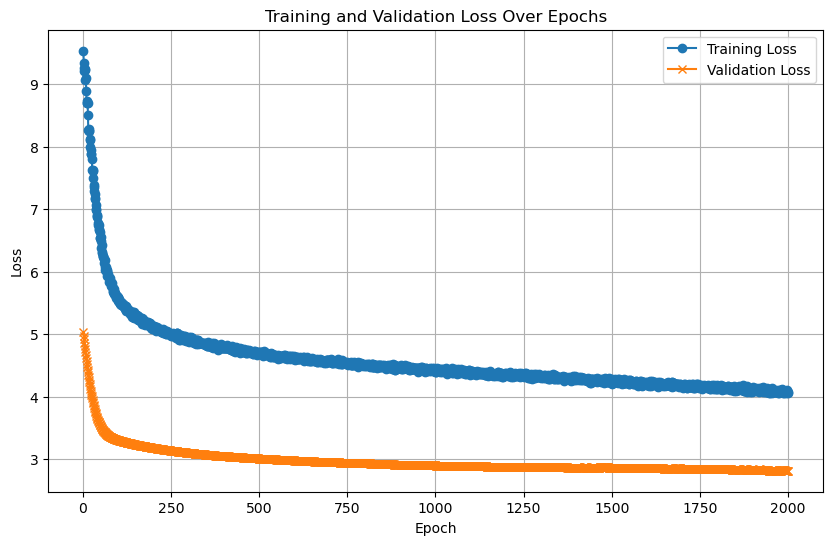

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/38], Loss: 4.9628
Test Batch [20/38], Loss: 5.2275
Test Batch [30/38], Loss: 4.5457

Test Loss: 4.9596


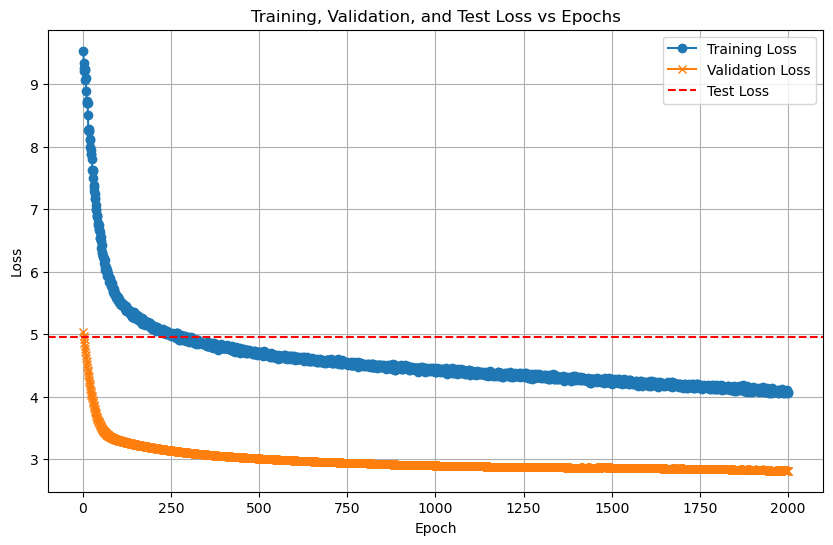

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/38 for test dataset.
  Processed batch 20/38 for test dataset.
  Processed batch 30/38 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 70.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.50      0.40      0.44         5
           2       0.20      0.20      0.20         5
           3       1.00      1.00      1.00         5
           4       1.00      0.40      0.57         5
           5       0.80      0.80      0.80         5
           6       0.00      0.00      0.00         0
           7       1.00      0.80      0.89         5
           9       0.80      0.80      0.80         5
          10       0.17      0.20      0.18         5
          11       0.50      0.40      0.44         5
          12       1.00      1.00      1.00         5
          13       0.71      1.00      0.83         5
          14       0.8

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9217  |  Val Loss: 2.9034
Validation loss improved from inf to 2.9034.
[Epoch 2/1000] Train Loss: 2.8863  |  Val Loss: 2.8697
Validation loss improved from 2.9034 to 2.8697.
[Epoch 3/1000] Train Loss: 2.8542  |  Val Loss: 2.8369
Validation loss improved from 2.8697 to 2.8369.
[Epoch 4/1000] Train Loss: 2.8235  |  Val Loss: 2.8067
Validation loss improved from 2.8369 to 2.8067.
[Epoch 5/1000] Train Loss: 2.7931  |  Val Loss: 2.7787
Validation loss improved from 2.8067 to 2.7787.
[Epoch 6/1000] Train Loss: 2.7656  |  Val Loss: 2.7517
Validation loss improved from 2.7787 to 2.7517.


[Epoch 7/1000] Train Loss: 2.7387  |  Val Loss: 2.7265
Validation loss improved from 2.7517 to 2.7265.
[Epoch 8/1000] Train Loss: 2.7130  |  Val Loss: 2.7021
Validation loss improved from 2.7265 to 2.7021.
[Epoch 9/1000] Train Loss: 2.6898  |  Val Loss: 2.6790
Validation loss improved from 2.7021 to 2.6790.
[Epoch 10/1000] Train Loss: 2.6684  |  Val Loss: 2.6573
Validation loss improved from 2.6790 to 2.6573.
[Epoch 11/1000] Train Loss: 2.6465  |  Val Loss: 2.6373
Validation loss improved from 2.6573 to 2.6373.
[Epoch 12/1000] Train Loss: 2.6278  |  Val Loss: 2.6183
Validation loss improved from 2.6373 to 2.6183.
[Epoch 13/1000] Train Loss: 2.6080  |  Val Loss: 2.6008
Validation loss improved from 2.6183 to 2.6008.
[Epoch 14/1000] Train Loss: 2.5906  |  Val Loss: 2.5832
Validation loss improved from 2.6008 to 2.5832.
[Epoch 15/1000] Train Loss: 2.5736  |  Val Loss: 2.5660
Validation loss improved from 2.5832 to 2.5660.
[Epoch 16/1000] Train Loss: 2.5575  |  Val Loss: 2.5485
Validation 

[Epoch 20/1000] Train Loss: 2.4947  |  Val Loss: 2.4822
Validation loss improved from 2.4982 to 2.4822.
[Epoch 21/1000] Train Loss: 2.4788  |  Val Loss: 2.4663
Validation loss improved from 2.4822 to 2.4663.
[Epoch 22/1000] Train Loss: 2.4643  |  Val Loss: 2.4505
Validation loss improved from 2.4663 to 2.4505.
[Epoch 23/1000] Train Loss: 2.4491  |  Val Loss: 2.4345
Validation loss improved from 2.4505 to 2.4345.
[Epoch 24/1000] Train Loss: 2.4340  |  Val Loss: 2.4191
Validation loss improved from 2.4345 to 2.4191.
[Epoch 25/1000] Train Loss: 2.4191  |  Val Loss: 2.4039
Validation loss improved from 2.4191 to 2.4039.
[Epoch 26/1000] Train Loss: 2.4049  |  Val Loss: 2.3883
Validation loss improved from 2.4039 to 2.3883.
[Epoch 27/1000] Train Loss: 2.3902  |  Val Loss: 2.3724
Validation loss improved from 2.3883 to 2.3724.


[Epoch 28/1000] Train Loss: 2.3760  |  Val Loss: 2.3562
Validation loss improved from 2.3724 to 2.3562.
[Epoch 29/1000] Train Loss: 2.3618  |  Val Loss: 2.3400
Validation loss improved from 2.3562 to 2.3400.
[Epoch 30/1000] Train Loss: 2.3473  |  Val Loss: 2.3234
Validation loss improved from 2.3400 to 2.3234.
[Epoch 31/1000] Train Loss: 2.3328  |  Val Loss: 2.3067
Validation loss improved from 2.3234 to 2.3067.
[Epoch 32/1000] Train Loss: 2.3181  |  Val Loss: 2.2901
Validation loss improved from 2.3067 to 2.2901.
[Epoch 33/1000] Train Loss: 2.3035  |  Val Loss: 2.2732
Validation loss improved from 2.2901 to 2.2732.
[Epoch 34/1000] Train Loss: 2.2888  |  Val Loss: 2.2563
Validation loss improved from 2.2732 to 2.2563.
[Epoch 35/1000] Train Loss: 2.2742  |  Val Loss: 2.2397
Validation loss improved from 2.2563 to 2.2397.
[Epoch 36/1000] Train Loss: 2.2600  |  Val Loss: 2.2231
Validation loss improved from 2.2397 to 2.2231.
[Epoch 37/1000] Train Loss: 2.2454  |  Val Loss: 2.2064
Validati

[Epoch 41/1000] Train Loss: 2.1895  |  Val Loss: 2.1392
Validation loss improved from 2.1565 to 2.1392.
[Epoch 42/1000] Train Loss: 2.1749  |  Val Loss: 2.1228
Validation loss improved from 2.1392 to 2.1228.
[Epoch 43/1000] Train Loss: 2.1612  |  Val Loss: 2.1056
Validation loss improved from 2.1228 to 2.1056.
[Epoch 44/1000] Train Loss: 2.1465  |  Val Loss: 2.0889
Validation loss improved from 2.1056 to 2.0889.
[Epoch 45/1000] Train Loss: 2.1322  |  Val Loss: 2.0727
Validation loss improved from 2.0889 to 2.0727.
[Epoch 46/1000] Train Loss: 2.1178  |  Val Loss: 2.0557
Validation loss improved from 2.0727 to 2.0557.
[Epoch 47/1000] Train Loss: 2.1032  |  Val Loss: 2.0391
Validation loss improved from 2.0557 to 2.0391.
[Epoch 48/1000] Train Loss: 2.0891  |  Val Loss: 2.0223
Validation loss improved from 2.0391 to 2.0223.


[Epoch 49/1000] Train Loss: 2.0748  |  Val Loss: 2.0059
Validation loss improved from 2.0223 to 2.0059.
[Epoch 50/1000] Train Loss: 2.0603  |  Val Loss: 1.9894
Validation loss improved from 2.0059 to 1.9894.
[Epoch 51/1000] Train Loss: 2.0469  |  Val Loss: 1.9722
Validation loss improved from 1.9894 to 1.9722.
[Epoch 52/1000] Train Loss: 2.0322  |  Val Loss: 1.9556
Validation loss improved from 1.9722 to 1.9556.
[Epoch 53/1000] Train Loss: 2.0180  |  Val Loss: 1.9389
Validation loss improved from 1.9556 to 1.9389.
[Epoch 54/1000] Train Loss: 2.0038  |  Val Loss: 1.9222
Validation loss improved from 1.9389 to 1.9222.
[Epoch 55/1000] Train Loss: 1.9890  |  Val Loss: 1.9053
Validation loss improved from 1.9222 to 1.9053.
[Epoch 56/1000] Train Loss: 1.9753  |  Val Loss: 1.8884
Validation loss improved from 1.9053 to 1.8884.
[Epoch 57/1000] Train Loss: 1.9606  |  Val Loss: 1.8718
Validation loss improved from 1.8884 to 1.8718.
[Epoch 58/1000] Train Loss: 1.9463  |  Val Loss: 1.8553
Validati

[Epoch 62/1000] Train Loss: 1.8853  |  Val Loss: 1.7818
Validation loss improved from 1.8007 to 1.7818.
[Epoch 63/1000] Train Loss: 1.8696  |  Val Loss: 1.7633
Validation loss improved from 1.7818 to 1.7633.
[Epoch 64/1000] Train Loss: 1.8547  |  Val Loss: 1.7460
Validation loss improved from 1.7633 to 1.7460.
[Epoch 65/1000] Train Loss: 1.8402  |  Val Loss: 1.7285
Validation loss improved from 1.7460 to 1.7285.
[Epoch 66/1000] Train Loss: 1.8251  |  Val Loss: 1.7104
Validation loss improved from 1.7285 to 1.7104.
[Epoch 67/1000] Train Loss: 1.8098  |  Val Loss: 1.6933
Validation loss improved from 1.7104 to 1.6933.


[Epoch 68/1000] Train Loss: 1.7957  |  Val Loss: 1.6764
Validation loss improved from 1.6933 to 1.6764.
[Epoch 69/1000] Train Loss: 1.7811  |  Val Loss: 1.6601
Validation loss improved from 1.6764 to 1.6601.
[Epoch 70/1000] Train Loss: 1.7666  |  Val Loss: 1.6434
Validation loss improved from 1.6601 to 1.6434.
[Epoch 71/1000] Train Loss: 1.7521  |  Val Loss: 1.6275
Validation loss improved from 1.6434 to 1.6275.
[Epoch 72/1000] Train Loss: 1.7374  |  Val Loss: 1.6119
Validation loss improved from 1.6275 to 1.6119.
[Epoch 73/1000] Train Loss: 1.7228  |  Val Loss: 1.5962
Validation loss improved from 1.6119 to 1.5962.
[Epoch 74/1000] Train Loss: 1.7092  |  Val Loss: 1.5811
Validation loss improved from 1.5962 to 1.5811.
[Epoch 75/1000] Train Loss: 1.6951  |  Val Loss: 1.5658
Validation loss improved from 1.5811 to 1.5658.
[Epoch 76/1000] Train Loss: 1.6809  |  Val Loss: 1.5510
Validation loss improved from 1.5658 to 1.5510.
[Epoch 77/1000] Train Loss: 1.6673  |  Val Loss: 1.5364
Validati

[Epoch 79/1000] Train Loss: 1.6397  |  Val Loss: 1.5074
Validation loss improved from 1.5218 to 1.5074.
[Epoch 80/1000] Train Loss: 1.6261  |  Val Loss: 1.4934
Validation loss improved from 1.5074 to 1.4934.
[Epoch 81/1000] Train Loss: 1.6124  |  Val Loss: 1.4801
Validation loss improved from 1.4934 to 1.4801.
[Epoch 82/1000] Train Loss: 1.5987  |  Val Loss: 1.4667
Validation loss improved from 1.4801 to 1.4667.
[Epoch 83/1000] Train Loss: 1.5852  |  Val Loss: 1.4537
Validation loss improved from 1.4667 to 1.4537.
[Epoch 84/1000] Train Loss: 1.5718  |  Val Loss: 1.4411
Validation loss improved from 1.4537 to 1.4411.
[Epoch 85/1000] Train Loss: 1.5596  |  Val Loss: 1.4285
Validation loss improved from 1.4411 to 1.4285.


[Epoch 86/1000] Train Loss: 1.5461  |  Val Loss: 1.4164
Validation loss improved from 1.4285 to 1.4164.
[Epoch 87/1000] Train Loss: 1.5335  |  Val Loss: 1.4053
Validation loss improved from 1.4164 to 1.4053.
[Epoch 88/1000] Train Loss: 1.5207  |  Val Loss: 1.3932
Validation loss improved from 1.4053 to 1.3932.
[Epoch 89/1000] Train Loss: 1.5082  |  Val Loss: 1.3816
Validation loss improved from 1.3932 to 1.3816.
[Epoch 90/1000] Train Loss: 1.4961  |  Val Loss: 1.3706
Validation loss improved from 1.3816 to 1.3706.
[Epoch 91/1000] Train Loss: 1.4831  |  Val Loss: 1.3594
Validation loss improved from 1.3706 to 1.3594.
[Epoch 92/1000] Train Loss: 1.4704  |  Val Loss: 1.3480
Validation loss improved from 1.3594 to 1.3480.
[Epoch 93/1000] Train Loss: 1.4586  |  Val Loss: 1.3359
Validation loss improved from 1.3480 to 1.3359.
[Epoch 94/1000] Train Loss: 1.4469  |  Val Loss: 1.3253
Validation loss improved from 1.3359 to 1.3253.
[Epoch 95/1000] Train Loss: 1.4347  |  Val Loss: 1.3153
Validati

[Epoch 96/1000] Train Loss: 1.4232  |  Val Loss: 1.3047
Validation loss improved from 1.3153 to 1.3047.
[Epoch 97/1000] Train Loss: 1.4118  |  Val Loss: 1.2936
Validation loss improved from 1.3047 to 1.2936.
[Epoch 98/1000] Train Loss: 1.4003  |  Val Loss: 1.2823
Validation loss improved from 1.2936 to 1.2823.
[Epoch 99/1000] Train Loss: 1.3888  |  Val Loss: 1.2724
Validation loss improved from 1.2823 to 1.2724.
[Epoch 100/1000] Train Loss: 1.3784  |  Val Loss: 1.2630
Validation loss improved from 1.2724 to 1.2630.
[Epoch 101/1000] Train Loss: 1.3670  |  Val Loss: 1.2519
Validation loss improved from 1.2630 to 1.2519.


[Epoch 102/1000] Train Loss: 1.3560  |  Val Loss: 1.2422
Validation loss improved from 1.2519 to 1.2422.
[Epoch 103/1000] Train Loss: 1.3456  |  Val Loss: 1.2323
Validation loss improved from 1.2422 to 1.2323.
[Epoch 104/1000] Train Loss: 1.3351  |  Val Loss: 1.2229
Validation loss improved from 1.2323 to 1.2229.
[Epoch 105/1000] Train Loss: 1.3251  |  Val Loss: 1.2138
Validation loss improved from 1.2229 to 1.2138.
[Epoch 106/1000] Train Loss: 1.3147  |  Val Loss: 1.2053
Validation loss improved from 1.2138 to 1.2053.
[Epoch 107/1000] Train Loss: 1.3044  |  Val Loss: 1.1976
Validation loss improved from 1.2053 to 1.1976.
[Epoch 108/1000] Train Loss: 1.2942  |  Val Loss: 1.1892
Validation loss improved from 1.1976 to 1.1892.
[Epoch 109/1000] Train Loss: 1.2848  |  Val Loss: 1.1800
Validation loss improved from 1.1892 to 1.1800.
[Epoch 110/1000] Train Loss: 1.2749  |  Val Loss: 1.1705
Validation loss improved from 1.1800 to 1.1705.
[Epoch 111/1000] Train Loss: 1.2654  |  Val Loss: 1.162

[Epoch 115/1000] Train Loss: 1.2278  |  Val Loss: 1.1322
Validation loss improved from 1.1405 to 1.1322.
[Epoch 116/1000] Train Loss: 1.2191  |  Val Loss: 1.1253
Validation loss improved from 1.1322 to 1.1253.
[Epoch 117/1000] Train Loss: 1.2096  |  Val Loss: 1.1179
Validation loss improved from 1.1253 to 1.1179.
[Epoch 118/1000] Train Loss: 1.2006  |  Val Loss: 1.1117
Validation loss improved from 1.1179 to 1.1117.
[Epoch 119/1000] Train Loss: 1.1917  |  Val Loss: 1.1064
Validation loss improved from 1.1117 to 1.1064.
[Epoch 120/1000] Train Loss: 1.1828  |  Val Loss: 1.0999
Validation loss improved from 1.1064 to 1.0999.


[Epoch 121/1000] Train Loss: 1.1745  |  Val Loss: 1.0926
Validation loss improved from 1.0999 to 1.0926.
[Epoch 122/1000] Train Loss: 1.1657  |  Val Loss: 1.0865
Validation loss improved from 1.0926 to 1.0865.
[Epoch 123/1000] Train Loss: 1.1575  |  Val Loss: 1.0799
Validation loss improved from 1.0865 to 1.0799.
[Epoch 124/1000] Train Loss: 1.1493  |  Val Loss: 1.0748
Validation loss improved from 1.0799 to 1.0748.
[Epoch 125/1000] Train Loss: 1.1413  |  Val Loss: 1.0683
Validation loss improved from 1.0748 to 1.0683.
[Epoch 126/1000] Train Loss: 1.1323  |  Val Loss: 1.0631
Validation loss improved from 1.0683 to 1.0631.
[Epoch 127/1000] Train Loss: 1.1245  |  Val Loss: 1.0579
Validation loss improved from 1.0631 to 1.0579.
[Epoch 128/1000] Train Loss: 1.1169  |  Val Loss: 1.0532
Validation loss improved from 1.0579 to 1.0532.
[Epoch 129/1000] Train Loss: 1.1088  |  Val Loss: 1.0466
Validation loss improved from 1.0532 to 1.0466.
[Epoch 130/1000] Train Loss: 1.1005  |  Val Loss: 1.041

[Epoch 136/1000] Train Loss: 1.0542  |  Val Loss: 1.0130
Validation loss improved from 1.0178 to 1.0130.
[Epoch 137/1000] Train Loss: 1.0464  |  Val Loss: 1.0096
Validation loss improved from 1.0130 to 1.0096.
[Epoch 138/1000] Train Loss: 1.0394  |  Val Loss: 1.0042
Validation loss improved from 1.0096 to 1.0042.
[Epoch 139/1000] Train Loss: 1.0315  |  Val Loss: 0.9999
Validation loss improved from 1.0042 to 0.9999.
[Epoch 140/1000] Train Loss: 1.0243  |  Val Loss: 0.9954
Validation loss improved from 0.9999 to 0.9954.
[Epoch 141/1000] Train Loss: 1.0172  |  Val Loss: 0.9909
Validation loss improved from 0.9954 to 0.9909.


[Epoch 142/1000] Train Loss: 1.0099  |  Val Loss: 0.9872
Validation loss improved from 0.9909 to 0.9872.
[Epoch 143/1000] Train Loss: 1.0024  |  Val Loss: 0.9837
Validation loss improved from 0.9872 to 0.9837.
[Epoch 144/1000] Train Loss: 0.9959  |  Val Loss: 0.9789
Validation loss improved from 0.9837 to 0.9789.
[Epoch 145/1000] Train Loss: 0.9884  |  Val Loss: 0.9747
Validation loss improved from 0.9789 to 0.9747.
[Epoch 146/1000] Train Loss: 0.9816  |  Val Loss: 0.9715
Validation loss improved from 0.9747 to 0.9715.
[Epoch 147/1000] Train Loss: 0.9749  |  Val Loss: 0.9677
Validation loss improved from 0.9715 to 0.9677.
[Epoch 148/1000] Train Loss: 0.9675  |  Val Loss: 0.9633
Validation loss improved from 0.9677 to 0.9633.
[Epoch 149/1000] Train Loss: 0.9602  |  Val Loss: 0.9598
Validation loss improved from 0.9633 to 0.9598.
[Epoch 150/1000] Train Loss: 0.9543  |  Val Loss: 0.9565
Validation loss improved from 0.9598 to 0.9565.
[Epoch 151/1000] Train Loss: 0.9471  |  Val Loss: 0.952

[Epoch 156/1000] Train Loss: 0.9142  |  Val Loss: 0.9374
Validation loss improved from 0.9394 to 0.9374.
[Epoch 157/1000] Train Loss: 0.9077  |  Val Loss: 0.9330
Validation loss improved from 0.9374 to 0.9330.
[Epoch 158/1000] Train Loss: 0.9012  |  Val Loss: 0.9294
Validation loss improved from 0.9330 to 0.9294.
[Epoch 159/1000] Train Loss: 0.8955  |  Val Loss: 0.9274
Validation loss improved from 0.9294 to 0.9274.
[Epoch 160/1000] Train Loss: 0.8892  |  Val Loss: 0.9235
Validation loss improved from 0.9274 to 0.9235.
[Epoch 161/1000] Train Loss: 0.8832  |  Val Loss: 0.9217
Validation loss improved from 0.9235 to 0.9217.
[Epoch 162/1000] Train Loss: 0.8768  |  Val Loss: 0.9193
Validation loss improved from 0.9217 to 0.9193.
[Epoch 163/1000] Train Loss: 0.8712  |  Val Loss: 0.9145
Validation loss improved from 0.9193 to 0.9145.


[Epoch 164/1000] Train Loss: 0.8647  |  Val Loss: 0.9121
Validation loss improved from 0.9145 to 0.9121.
[Epoch 165/1000] Train Loss: 0.8592  |  Val Loss: 0.9078
Validation loss improved from 0.9121 to 0.9078.
[Epoch 166/1000] Train Loss: 0.8534  |  Val Loss: 0.9064
Validation loss improved from 0.9078 to 0.9064.
[Epoch 167/1000] Train Loss: 0.8471  |  Val Loss: 0.9045
Validation loss improved from 0.9064 to 0.9045.
[Epoch 168/1000] Train Loss: 0.8419  |  Val Loss: 0.9017
Validation loss improved from 0.9045 to 0.9017.
[Epoch 169/1000] Train Loss: 0.8358  |  Val Loss: 0.8981
Validation loss improved from 0.9017 to 0.8981.
[Epoch 170/1000] Train Loss: 0.8304  |  Val Loss: 0.8955
Validation loss improved from 0.8981 to 0.8955.
[Epoch 171/1000] Train Loss: 0.8247  |  Val Loss: 0.8925
Validation loss improved from 0.8955 to 0.8925.
[Epoch 172/1000] Train Loss: 0.8199  |  Val Loss: 0.8897
Validation loss improved from 0.8925 to 0.8897.


[Epoch 173/1000] Train Loss: 0.8147  |  Val Loss: 0.8865
Validation loss improved from 0.8897 to 0.8865.
[Epoch 174/1000] Train Loss: 0.8088  |  Val Loss: 0.8841
Validation loss improved from 0.8865 to 0.8841.
[Epoch 175/1000] Train Loss: 0.8035  |  Val Loss: 0.8833
Validation loss improved from 0.8841 to 0.8833.
[Epoch 176/1000] Train Loss: 0.7984  |  Val Loss: 0.8804
Validation loss improved from 0.8833 to 0.8804.
[Epoch 177/1000] Train Loss: 0.7930  |  Val Loss: 0.8772
Validation loss improved from 0.8804 to 0.8772.
[Epoch 178/1000] Train Loss: 0.7885  |  Val Loss: 0.8737
Validation loss improved from 0.8772 to 0.8737.
[Epoch 179/1000] Train Loss: 0.7831  |  Val Loss: 0.8703
Validation loss improved from 0.8737 to 0.8703.
[Epoch 180/1000] Train Loss: 0.7784  |  Val Loss: 0.8708
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 0.7735  |  Val Loss: 0.8671
Validation loss improved from 0.8703 to 0.8671.


[Epoch 182/1000] Train Loss: 0.7688  |  Val Loss: 0.8668
Validation loss improved from 0.8671 to 0.8668.
[Epoch 183/1000] Train Loss: 0.7632  |  Val Loss: 0.8629
Validation loss improved from 0.8668 to 0.8629.
[Epoch 184/1000] Train Loss: 0.7600  |  Val Loss: 0.8581
Validation loss improved from 0.8629 to 0.8581.
[Epoch 185/1000] Train Loss: 0.7542  |  Val Loss: 0.8572
Validation loss improved from 0.8581 to 0.8572.
[Epoch 186/1000] Train Loss: 0.7514  |  Val Loss: 0.8597
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 187/1000] Train Loss: 0.7451  |  Val Loss: 0.8549
Validation loss improved from 0.8572 to 0.8549.
[Epoch 188/1000] Train Loss: 0.7407  |  Val Loss: 0.8520
Validation loss improved from 0.8549 to 0.8520.
[Epoch 189/1000] Train Loss: 0.7355  |  Val Loss: 0.8493
Validation loss improved from 0.8520 to 0.8493.
[Epoch 190/1000] Train Loss: 0.7316  |  Val Loss: 0.8446
Validation loss improved from 0.8493 to 0.8446.


[Epoch 191/1000] Train Loss: 0.7272  |  Val Loss: 0.8434
Validation loss improved from 0.8446 to 0.8434.
[Epoch 192/1000] Train Loss: 0.7226  |  Val Loss: 0.8417
Validation loss improved from 0.8434 to 0.8417.
[Epoch 193/1000] Train Loss: 0.7191  |  Val Loss: 0.8414
Validation loss improved from 0.8417 to 0.8414.
[Epoch 194/1000] Train Loss: 0.7140  |  Val Loss: 0.8391
Validation loss improved from 0.8414 to 0.8391.
[Epoch 195/1000] Train Loss: 0.7101  |  Val Loss: 0.8357
Validation loss improved from 0.8391 to 0.8357.
[Epoch 196/1000] Train Loss: 0.7059  |  Val Loss: 0.8325
Validation loss improved from 0.8357 to 0.8325.
[Epoch 197/1000] Train Loss: 0.7021  |  Val Loss: 0.8318
Validation loss improved from 0.8325 to 0.8318.
[Epoch 198/1000] Train Loss: 0.6978  |  Val Loss: 0.8306
Validation loss improved from 0.8318 to 0.8306.
[Epoch 199/1000] Train Loss: 0.6939  |  Val Loss: 0.8282
Validation loss improved from 0.8306 to 0.8282.
[Epoch 200/1000] Train Loss: 0.6906  |  Val Loss: 0.825

[Epoch 201/1000] Train Loss: 0.6868  |  Val Loss: 0.8226
Validation loss improved from 0.8256 to 0.8226.
[Epoch 202/1000] Train Loss: 0.6828  |  Val Loss: 0.8216
Validation loss improved from 0.8226 to 0.8216.
[Epoch 203/1000] Train Loss: 0.6787  |  Val Loss: 0.8219
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 204/1000] Train Loss: 0.6750  |  Val Loss: 0.8200
Validation loss improved from 0.8216 to 0.8200.
[Epoch 205/1000] Train Loss: 0.6719  |  Val Loss: 0.8170
Validation loss improved from 0.8200 to 0.8170.
[Epoch 206/1000] Train Loss: 0.6682  |  Val Loss: 0.8167
Validation loss improved from 0.8170 to 0.8167.
[Epoch 207/1000] Train Loss: 0.6642  |  Val Loss: 0.8139
Validation loss improved from 0.8167 to 0.8139.
[Epoch 208/1000] Train Loss: 0.6613  |  Val Loss: 0.8100
Validation loss improved from 0.8139 to 0.8100.
[Epoch 209/1000] Train Loss: 0.6580  |  Val Loss: 0.8079
Validation loss improved from 0.8100 to 0.8079.
[Epoch 210/1000] Train Loss: 0.6539  |  Val Loss:

[Epoch 211/1000] Train Loss: 0.6502  |  Val Loss: 0.8067
Validation loss improved from 0.8077 to 0.8067.
[Epoch 212/1000] Train Loss: 0.6474  |  Val Loss: 0.8048
Validation loss improved from 0.8067 to 0.8048.
[Epoch 213/1000] Train Loss: 0.6443  |  Val Loss: 0.8033
Validation loss improved from 0.8048 to 0.8033.
[Epoch 214/1000] Train Loss: 0.6405  |  Val Loss: 0.7995
Validation loss improved from 0.8033 to 0.7995.
[Epoch 215/1000] Train Loss: 0.6389  |  Val Loss: 0.7958
Validation loss improved from 0.7995 to 0.7958.
[Epoch 216/1000] Train Loss: 0.6350  |  Val Loss: 0.7971
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 0.6313  |  Val Loss: 0.7968
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 0.6284  |  Val Loss: 0.7966
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 0.6252  |  Val Loss: 0.7943
Validation loss improved from 0.7958 to 0.7943.
[Epoch 220/1000] Train Loss: 0.6223  

[Epoch 221/1000] Train Loss: 0.6199  |  Val Loss: 0.7891
Validation loss improved from 0.7902 to 0.7891.
[Epoch 222/1000] Train Loss: 0.6163  |  Val Loss: 0.7853
Validation loss improved from 0.7891 to 0.7853.
[Epoch 223/1000] Train Loss: 0.6141  |  Val Loss: 0.7855
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 0.6114  |  Val Loss: 0.7834
Validation loss improved from 0.7853 to 0.7834.
[Epoch 225/1000] Train Loss: 0.6078  |  Val Loss: 0.7826
Validation loss improved from 0.7834 to 0.7826.
[Epoch 226/1000] Train Loss: 0.6057  |  Val Loss: 0.7832
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 227/1000] Train Loss: 0.6026  |  Val Loss: 0.7823
Validation loss improved from 0.7826 to 0.7823.
[Epoch 228/1000] Train Loss: 0.6002  |  Val Loss: 0.7773
Validation loss improved from 0.7823 to 0.7773.
[Epoch 229/1000] Train Loss: 0.5971  |  Val Loss: 0.7777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 0.5949  

[Epoch 232/1000] Train Loss: 0.5898  |  Val Loss: 0.7759
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 233/1000] Train Loss: 0.5876  |  Val Loss: 0.7716
Validation loss improved from 0.7756 to 0.7716.
[Epoch 234/1000] Train Loss: 0.5851  |  Val Loss: 0.7694
Validation loss improved from 0.7716 to 0.7694.
[Epoch 235/1000] Train Loss: 0.5823  |  Val Loss: 0.7683
Validation loss improved from 0.7694 to 0.7683.
[Epoch 236/1000] Train Loss: 0.5800  |  Val Loss: 0.7665
Validation loss improved from 0.7683 to 0.7665.
[Epoch 237/1000] Train Loss: 0.5771  |  Val Loss: 0.7679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.5753  |  Val Loss: 0.7638
Validation loss improved from 0.7665 to 0.7638.
[Epoch 239/1000] Train Loss: 0.5721  |  Val Loss: 0.7634
Validation loss improved from 0.7638 to 0.7634.
[Epoch 240/1000] Train Loss: 0.5698  |  Val Loss: 0.7628
Validation loss improved from 0.7634 to 0.7628.


[Epoch 241/1000] Train Loss: 0.5685  |  Val Loss: 0.7645
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 242/1000] Train Loss: 0.5664  |  Val Loss: 0.7601
Validation loss improved from 0.7628 to 0.7601.
[Epoch 243/1000] Train Loss: 0.5636  |  Val Loss: 0.7577
Validation loss improved from 0.7601 to 0.7577.
[Epoch 244/1000] Train Loss: 0.5616  |  Val Loss: 0.7586
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 245/1000] Train Loss: 0.5588  |  Val Loss: 0.7566
Validation loss improved from 0.7577 to 0.7566.
[Epoch 246/1000] Train Loss: 0.5575  |  Val Loss: 0.7541
Validation loss improved from 0.7566 to 0.7541.
[Epoch 247/1000] Train Loss: 0.5547  |  Val Loss: 0.7547
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 0.5528  |  Val Loss: 0.7542
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 249/1000] Train Loss: 0.5509  |  Val Loss: 0.7522
Validation loss improved from 0.7541 to 0.7522.
[Epoch 250/1000] Train Loss: 0.

[Epoch 251/1000] Train Loss: 0.5465  |  Val Loss: 0.7501
Validation loss improved from 0.7522 to 0.7501.
[Epoch 252/1000] Train Loss: 0.5450  |  Val Loss: 0.7485
Validation loss improved from 0.7501 to 0.7485.
[Epoch 253/1000] Train Loss: 0.5428  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 254/1000] Train Loss: 0.5409  |  Val Loss: 0.7468
Validation loss improved from 0.7485 to 0.7468.
[Epoch 255/1000] Train Loss: 0.5388  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 0.5370  |  Val Loss: 0.7474
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 0.5356  |  Val Loss: 0.7443
Validation loss improved from 0.7468 to 0.7443.
[Epoch 258/1000] Train Loss: 0.5338  |  Val Loss: 0.7419
Validation loss improved from 0.7443 to 0.7419.
[Epoch 259/1000] Train Loss: 0.5323  |  Val Loss: 0.7447
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 260/1000] Train Loss: 0.5303  |  Val Loss: 0.7446
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 0.5280  |  Val Loss: 0.7418
Validation loss improved from 0.7419 to 0.7418.
[Epoch 262/1000] Train Loss: 0.5265  |  Val Loss: 0.7397
Validation loss improved from 0.7418 to 0.7397.
[Epoch 263/1000] Train Loss: 0.5249  |  Val Loss: 0.7377
Validation loss improved from 0.7397 to 0.7377.
[Epoch 264/1000] Train Loss: 0.5234  |  Val Loss: 0.7357
Validation loss improved from 0.7377 to 0.7357.
[Epoch 265/1000] Train Loss: 0.5218  |  Val Loss: 0.7390
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 266/1000] Train Loss: 0.5203  |  Val Loss: 0.7380
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 267/1000] Train Loss: 0.5180  |  Val Loss: 0.7350
Validation loss improved from 0.7357 to 0.7350.
[Epoch 268/1000] Train Loss: 0.5165  |  Val Loss: 0.7338
Validation loss improved from 0.7350 to 0.7338.


[Epoch 269/1000] Train Loss: 0.5151  |  Val Loss: 0.7348
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 0.5142  |  Val Loss: 0.7298
Validation loss improved from 0.7338 to 0.7298.
[Epoch 271/1000] Train Loss: 0.5120  |  Val Loss: 0.7311
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 272/1000] Train Loss: 0.5108  |  Val Loss: 0.7309
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 273/1000] Train Loss: 0.5090  |  Val Loss: 0.7311
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 274/1000] Train Loss: 0.5068  |  Val Loss: 0.7303
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 275/1000] Train Loss: 0.5055  |  Val Loss: 0.7291
Validation loss improved from 0.7298 to 0.7291.
[Epoch 276/1000] Train Loss: 0.5054  |  Val Loss: 0.7269
Validation loss improved from 0.7291 to 0.7269.


[Epoch 277/1000] Train Loss: 0.5033  |  Val Loss: 0.7279
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 278/1000] Train Loss: 0.5009  |  Val Loss: 0.7288
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 279/1000] Train Loss: 0.4996  |  Val Loss: 0.7273
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 280/1000] Train Loss: 0.4980  |  Val Loss: 0.7254
Validation loss improved from 0.7269 to 0.7254.
[Epoch 281/1000] Train Loss: 0.4968  |  Val Loss: 0.7232
Validation loss improved from 0.7254 to 0.7232.
[Epoch 282/1000] Train Loss: 0.4956  |  Val Loss: 0.7252
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 0.4940  |  Val Loss: 0.7250
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 0.4925  |  Val Loss: 0.7214
Validation loss improved from 0.7232 to 0.7214.
[Epoch 285/1000] Train Loss: 0.4914  |  Val Loss: 0.7211
Validation loss improved from 0.7214 to 0.7211.
[Epoch 286/1000] Train Lo

[Epoch 288/1000] Train Loss: 0.4878  |  Val Loss: 0.7157
Validation loss improved from 0.7188 to 0.7157.
[Epoch 289/1000] Train Loss: 0.4858  |  Val Loss: 0.7177
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 290/1000] Train Loss: 0.4852  |  Val Loss: 0.7182
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 291/1000] Train Loss: 0.4838  |  Val Loss: 0.7191
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 292/1000] Train Loss: 0.4833  |  Val Loss: 0.7220
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 293/1000] Train Loss: 0.4809  |  Val Loss: 0.7157
Validation loss improved from 0.7157 to 0.7157.
[Epoch 294/1000] Train Loss: 0.4797  |  Val Loss: 0.7129
Validation loss improved from 0.7157 to 0.7129.
[Epoch 295/1000] Train Loss: 0.4788  |  Val Loss: 0.7137
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 296/1000] Train Loss: 0.4781  |  Val Loss: 0.7120
Validation loss improved from 0.7129 to 0.7120.
[Epoch 297/1000] Train Loss: 0.4763  |  Val Loss: 0.7148
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 298/1000] Train Loss: 0.4752  |  Val Loss: 0.7175
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 299/1000] Train Loss: 0.4742  |  Val Loss: 0.7135
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 300/1000] Train Loss: 0.4724  |  Val Loss: 0.7119
Validation loss improved from 0.7120 to 0.7119.
[Epoch 301/1000] Train Loss: 0.4719  |  Val Loss: 0.7123
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 0.4707  |  Val Loss: 0.7115
Validation loss improved from 0.7119 to 0.7115.
[Epoch 303/1000] Train Loss: 0.4691  |  Val Loss: 0.7089
Validation loss improved from 0.7115 to 0.7089.
[Epoch 304/1000] Train Loss: 0.4687  |  Val Loss: 0.7077
Validation loss improved from 0.7089 to 0.7077.
[Epoch 305/1000] Train Loss: 0.

[Epoch 308/1000] Train Loss: 0.4635  |  Val Loss: 0.7096
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 309/1000] Train Loss: 0.4630  |  Val Loss: 0.7089
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 310/1000] Train Loss: 0.4617  |  Val Loss: 0.7070
Validation loss improved from 0.7077 to 0.7070.
[Epoch 311/1000] Train Loss: 0.4610  |  Val Loss: 0.7034
Validation loss improved from 0.7070 to 0.7034.
[Epoch 312/1000] Train Loss: 0.4601  |  Val Loss: 0.7037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 313/1000] Train Loss: 0.4595  |  Val Loss: 0.7086
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 314/1000] Train Loss: 0.4584  |  Val Loss: 0.7067
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 315/1000] Train Loss: 0.4574  |  Val Loss: 0.7089
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 316/1000] Train Loss: 0.4562  |  Val Loss: 0.7048
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 317/1000] Train Loss: 0.4548  |  Val Loss: 0.7036
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 318/1000] Train Loss: 0.4538  |  Val Loss: 0.7033
Validation loss improved from 0.7034 to 0.7033.
[Epoch 319/1000] Train Loss: 0.4531  |  Val Loss: 0.7036
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 0.4518  |  Val Loss: 0.7039
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 0.4506  |  Val Loss: 0.7036
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 0.4510  |  Val Loss: 0.6989
Validation loss improved from 0.7033 to 0.6989.
[Epoch 323/1000] Train Loss: 0.4493  |  Val Loss: 0.6998
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.4489  |  Val Loss: 0.7003
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/10

[Epoch 327/1000] Train Loss: 0.4461  |  Val Loss: 0.6996
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 328/1000] Train Loss: 0.4450  |  Val Loss: 0.6965
Validation loss improved from 0.6989 to 0.6965.
[Epoch 329/1000] Train Loss: 0.4444  |  Val Loss: 0.6950
Validation loss improved from 0.6965 to 0.6950.
[Epoch 330/1000] Train Loss: 0.4446  |  Val Loss: 0.7016
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 331/1000] Train Loss: 0.4421  |  Val Loss: 0.7014
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 332/1000] Train Loss: 0.4411  |  Val Loss: 0.6984
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 333/1000] Train Loss: 0.4398  |  Val Loss: 0.6982
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 334/1000] Train Loss: 0.4397  |  Val Loss: 0.6966
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 335/1000] Train Loss: 0.4396  |  Val Loss: 0.6918
Validation loss improved from 0.6950 to 0.6918.
[Epoch 336/1000] Train Loss: 0.4373  |  Val Loss: 0.6944
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 337/1000] Train Loss: 0.4367  |  Val Loss: 0.6962
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 338/1000] Train Loss: 0.4364  |  Val Loss: 0.6997
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 339/1000] Train Loss: 0.4355  |  Val Loss: 0.6995
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 340/1000] Train Loss: 0.4344  |  Val Loss: 0.6962
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 341/1000] Train Loss: 0.4330  |  Val Loss: 0.6925
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 342/1000] Train Loss: 0.4326  |  Val Loss: 0.6908
Validation loss improved from 0.6918 to 0.6908.
[Epoch 343/1000] Train Loss: 0.4331  |  Val Loss: 0.6936
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/10

[Epoch 347/1000] Train Loss: 0.4289  |  Val Loss: 0.6913
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 348/1000] Train Loss: 0.4280  |  Val Loss: 0.6927
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 349/1000] Train Loss: 0.4277  |  Val Loss: 0.6906
Validation loss improved from 0.6908 to 0.6906.
[Epoch 350/1000] Train Loss: 0.4272  |  Val Loss: 0.6915
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 351/1000] Train Loss: 0.4263  |  Val Loss: 0.6905
Validation loss improved from 0.6906 to 0.6905.
[Epoch 352/1000] Train Loss: 0.4252  |  Val Loss: 0.6897
Validation loss improved from 0.6905 to 0.6897.


[Epoch 353/1000] Train Loss: 0.4246  |  Val Loss: 0.6909
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 354/1000] Train Loss: 0.4235  |  Val Loss: 0.6902
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 355/1000] Train Loss: 0.4231  |  Val Loss: 0.6907
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 356/1000] Train Loss: 0.4230  |  Val Loss: 0.6928
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 357/1000] Train Loss: 0.4221  |  Val Loss: 0.6922
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 358/1000] Train Loss: 0.4219  |  Val Loss: 0.6866
Validation loss improved from 0.6897 to 0.6866.
[Epoch 359/1000] Train Loss: 0.4212  |  Val Loss: 0.6900
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 360/1000] Train Loss: 0.4198  |  Val Loss: 0.6897
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 361/1000] Train Loss: 0.4190  |  Val Loss: 0.6871
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 364/1000] Train Loss: 0.4168  |  Val Loss: 0.6887
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 365/1000] Train Loss: 0.4163  |  Val Loss: 0.6900
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 366/1000] Train Loss: 0.4156  |  Val Loss: 0.6840
Validation loss improved from 0.6866 to 0.6840.
[Epoch 367/1000] Train Loss: 0.4150  |  Val Loss: 0.6853
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 368/1000] Train Loss: 0.4145  |  Val Loss: 0.6837
Validation loss improved from 0.6840 to 0.6837.
[Epoch 369/1000] Train Loss: 0.4137  |  Val Loss: 0.6875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Train Loss: 0.4132  |  Val Loss: 0.6877
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 371/1000] Train Loss: 0.4130  |  Val Loss: 0.6889
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 372/1000] Train Loss: 0.4129  |  Val Loss: 0.6828
Validation loss improved from 0.6837 to 0.6828.
[Epoch 373/1000] Train Loss: 0.4119  |  Val Loss: 0.6855
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 374/1000] Train Loss: 0.4110  |  Val Loss: 0.6855
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 375/1000] Train Loss: 0.4098  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 376/1000] Train Loss: 0.4091  |  Val Loss: 0.6849
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 377/1000] Train Loss: 0.4087  |  Val Loss: 0.6850
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 378/1000] Train Loss: 0.4096  |  Val Loss: 0.6888
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 379/1000] Train Loss: 0.4089  |  Val Loss: 0.6840
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 380/1000] Train Loss: 0.4085  |  Val Loss: 0.6809
Validation loss improved from 0.6828 to 0.6809.
[Epoch 381/10

[Epoch 384/1000] Train Loss: 0.4047  |  Val Loss: 0.6855
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 385/1000] Train Loss: 0.4039  |  Val Loss: 0.6826
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 386/1000] Train Loss: 0.4033  |  Val Loss: 0.6817
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 387/1000] Train Loss: 0.4030  |  Val Loss: 0.6806
Validation loss improved from 0.6809 to 0.6806.
[Epoch 388/1000] Train Loss: 0.4032  |  Val Loss: 0.6847
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 389/1000] Train Loss: 0.4013  |  Val Loss: 0.6824
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 390/1000] Train Loss: 0.4009  |  Val Loss: 0.6832
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 391/1000] Train Loss: 0.4007  |  Val Loss: 0.6814
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 392/1000] Train Loss: 0.4008  |  Val Loss: 0.6846
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 393/1000] Train Loss: 0.3995  |  Val Loss: 0.6794
Validation loss improved from 0.6806 to 0.6794.
[Epoch 394/1000] Train Loss: 0.3992  |  Val Loss: 0.6766
Validation loss improved from 0.6794 to 0.6766.
[Epoch 395/1000] Train Loss: 0.3989  |  Val Loss: 0.6813
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 396/1000] Train Loss: 0.3979  |  Val Loss: 0.6786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 397/1000] Train Loss: 0.3976  |  Val Loss: 0.6769
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 398/1000] Train Loss: 0.3970  |  Val Loss: 0.6822
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 399/1000] Train Loss: 0.3969  |  Val Loss: 0.6794
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 400/10

[Epoch 407/1000] Train Loss: 0.3920  |  Val Loss: 0.6777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 408/1000] Train Loss: 0.3911  |  Val Loss: 0.6756
Validation loss improved from 0.6766 to 0.6756.
[Epoch 409/1000] Train Loss: 0.3914  |  Val Loss: 0.6793
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 410/1000] Train Loss: 0.3898  |  Val Loss: 0.6784
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 411/1000] Train Loss: 0.3899  |  Val Loss: 0.6745
Validation loss improved from 0.6756 to 0.6745.
[Epoch 412/1000] Train Loss: 0.3894  |  Val Loss: 0.6742
Validation loss improved from 0.6745 to 0.6742.
[Epoch 413/1000] Train Loss: 0.3890  |  Val Loss: 0.6745
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 414/1000] Train Loss: 0.3891  |  Val Loss: 0.6801
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 415/1000] Train Loss: 0.3882  |  Val Loss: 0.6815
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 416/1000] Train Loss: 0.3879  |  Val Loss: 0.6765
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 417/1000] Train Loss: 0.3868  |  Val Loss: 0.6755
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 418/1000] Train Loss: 0.3864  |  Val Loss: 0.6748
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 419/1000] Train Loss: 0.3861  |  Val Loss: 0.6759
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 420/10

[Epoch 427/1000] Train Loss: 0.3830  |  Val Loss: 0.6712
Validation loss improved from 0.6716 to 0.6712.
[Epoch 428/1000] Train Loss: 0.3828  |  Val Loss: 0.6755
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 429/1000] Train Loss: 0.3811  |  Val Loss: 0.6744
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 430/1000] Train Loss: 0.3814  |  Val Loss: 0.6772
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 431/1000] Train Loss: 0.3802  |  Val Loss: 0.6744
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 432/1000] Train Loss: 0.3799  |  Val Loss: 0.6738
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 433/1000] Train Loss: 0.3795  |  Val Loss: 0.6702
Validation loss improved from 0.6712 to 0.6702.
[Epoch 434/1000] Train Loss: 0.3792  |  Val Loss: 0.6730
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 435/1000] Train Loss: 0.3787  |  Val Loss: 0.6755
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 436/10

[Epoch 444/1000] Train Loss: 0.3745  |  Val Loss: 0.6745
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 445/1000] Train Loss: 0.3740  |  Val Loss: 0.6715
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 446/1000] Train Loss: 0.3742  |  Val Loss: 0.6701
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 447/1000] Train Loss: 0.3734  |  Val Loss: 0.6717
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 448/1000] Train Loss: 0.3733  |  Val Loss: 0.6704
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 449/1000] Train Loss: 0.3740  |  Val Loss: 0.6672
Validation loss improved from 0.6697 to 0.6672.
[Epoch 450/1000] Train Loss: 0.3722  |  Val Loss: 0.6705
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 451/1000] Train Loss: 0.3721  |  Val Loss: 0.6731
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 452/1000] Train Loss: 0.3712  |  Val Loss: 0.6724
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 

[Epoch 461/1000] Train Loss: 0.3686  |  Val Loss: 0.6654
Validation loss improved from 0.6656 to 0.6654.
[Epoch 462/1000] Train Loss: 0.3674  |  Val Loss: 0.6673
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 463/1000] Train Loss: 0.3667  |  Val Loss: 0.6688
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 464/1000] Train Loss: 0.3667  |  Val Loss: 0.6679
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 465/1000] Train Loss: 0.3658  |  Val Loss: 0.6678
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 466/1000] Train Loss: 0.3653  |  Val Loss: 0.6683
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 467/1000] Train Loss: 0.3663  |  Val Loss: 0.6663
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 468/1000] Train Loss: 0.3658  |  Val Loss: 0.6642
Validation loss improved from 0.6654 to 0.6642.
[Epoch 469/1000] Train Loss: 0.3643  |  Val Loss: 0.6676
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 470/10

[Epoch 481/1000] Train Loss: 0.3608  |  Val Loss: 0.6690
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 482/1000] Train Loss: 0.3599  |  Val Loss: 0.6687
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 483/1000] Train Loss: 0.3598  |  Val Loss: 0.6646
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 484/1000] Train Loss: 0.3597  |  Val Loss: 0.6659
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 485/1000] Train Loss: 0.3591  |  Val Loss: 0.6613
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 486/1000] Train Loss: 0.3583  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 487/1000] Train Loss: 0.3582  |  Val Loss: 0.6667
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 488/1000] Train Loss: 0.3578  |  Val Loss: 0.6638
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 489/1000] Train Loss: 0.3574  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 

[Epoch 501/1000] Train Loss: 0.3543  |  Val Loss: 0.6587
Validation loss improved from 0.6608 to 0.6587.
[Epoch 502/1000] Train Loss: 0.3527  |  Val Loss: 0.6589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 503/1000] Train Loss: 0.3526  |  Val Loss: 0.6640
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 504/1000] Train Loss: 0.3535  |  Val Loss: 0.6698
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 505/1000] Train Loss: 0.3519  |  Val Loss: 0.6651
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 506/1000] Train Loss: 0.3512  |  Val Loss: 0.6614
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 507/1000] Train Loss: 0.3515  |  Val Loss: 0.6567
Validation loss improved from 0.6587 to 0.6567.
[Epoch 508/1000] Train Loss: 0.3510  |  Val Loss: 0.6594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 509/1000] Train Loss: 0.3505  |  Val Loss: 0.6638
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 510/10

[Epoch 520/1000] Train Loss: 0.3471  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 521/1000] Train Loss: 0.3469  |  Val Loss: 0.6643
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 522/1000] Train Loss: 0.3471  |  Val Loss: 0.6660
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 523/1000] Train Loss: 0.3462  |  Val Loss: 0.6623
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 524/1000] Train Loss: 0.3461  |  Val Loss: 0.6580
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 525/1000] Train Loss: 0.3454  |  Val Loss: 0.6596
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 526/1000] Train Loss: 0.3448  |  Val Loss: 0.6598
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 527/1000] Train Loss: 0.3445  |  Val Loss: 0.6619
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 528/1000] Train Loss: 0.3448  |  Val Loss: 0.6636
!! Validation loss did NOT improve !! Patience:

[Epoch 537/1000] Train Loss: 0.3425  |  Val Loss: 0.6620
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 538/1000] Train Loss: 0.3419  |  Val Loss: 0.6603
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 539/1000] Train Loss: 0.3419  |  Val Loss: 0.6591
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 540/1000] Train Loss: 0.3419  |  Val Loss: 0.6633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 541/1000] Train Loss: 0.3415  |  Val Loss: 0.6627
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 542/1000] Train Loss: 0.3404  |  Val Loss: 0.6588
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 543/1000] Train Loss: 0.3399  |  Val Loss: 0.6589
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 544/1000] Train Loss: 0.3400  |  Val Loss: 0.6553
Validation loss improved from 0.6555 to 0.6553.
[Epoch 545/1000] Train Loss: 0.3397  |  Val Loss: 0.6572
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 556/1000] Train Loss: 0.3370  |  Val Loss: 0.6571
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 557/1000] Train Loss: 0.3374  |  Val Loss: 0.6643
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 558/1000] Train Loss: 0.3357  |  Val Loss: 0.6629
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 559/1000] Train Loss: 0.3357  |  Val Loss: 0.6570
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 560/1000] Train Loss: 0.3351  |  Val Loss: 0.6558
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 561/1000] Train Loss: 0.3356  |  Val Loss: 0.6564
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 562/1000] Train Loss: 0.3351  |  Val Loss: 0.6610
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 563/1000] Train Loss: 0.3366  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 564/1000] Train Loss: 0.3345  |  Val Loss: 0.6611
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 575/1000] Train Loss: 0.3319  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 576/1000] Train Loss: 0.3321  |  Val Loss: 0.6597
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 577/1000] Train Loss: 0.3309  |  Val Loss: 0.6605
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 578/1000] Train Loss: 0.3312  |  Val Loss: 0.6606
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 579/1000] Train Loss: 0.3305  |  Val Loss: 0.6586
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 580/1000] Train Loss: 0.3302  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 581/1000] Train Loss: 0.3302  |  Val Loss: 0.6556
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 582/1000] Train Loss: 0.3297  |  Val Loss: 0.6569
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 583/1000] Train Loss: 0.3294  |  Val Loss: 0.6590
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 595/1000] Train Loss: 0.3258  |  Val Loss: 0.6553
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 596/1000] Train Loss: 0.3257  |  Val Loss: 0.6540
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 597/1000] Train Loss: 0.3262  |  Val Loss: 0.6576
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 598/1000] Train Loss: 0.3250  |  Val Loss: 0.6578
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 599/1000] Train Loss: 0.3254  |  Val Loss: 0.6540
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 600/1000] Train Loss: 0.3257  |  Val Loss: 0.6575
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 601/1000] Train Loss: 0.3254  |  Val Loss: 0.6578
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 602/1000] Train Loss: 0.3244  |  Val Loss: 0.6552
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 603/1000] Train Loss: 0.3237  |  Val Loss: 0.6532
Validation loss improved from 0.6539 to 0.6532.
[Ep

[Epoch 614/1000] Train Loss: 0.3217  |  Val Loss: 0.6623
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 615/1000] Train Loss: 0.3215  |  Val Loss: 0.6598
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 616/1000] Train Loss: 0.3215  |  Val Loss: 0.6566
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 617/1000] Train Loss: 0.3217  |  Val Loss: 0.6552
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 618/1000] Train Loss: 0.3204  |  Val Loss: 0.6536
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 619/1000] Train Loss: 0.3204  |  Val Loss: 0.6537
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 620/1000] Train Loss: 0.3208  |  Val Loss: 0.6543
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 621/1000] Train Loss: 0.3207  |  Val Loss: 0.6513
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 622/1000] Train Loss: 0.3197  |  Val Loss: 0.6574
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 631/1000] Train Loss: 0.3182  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 632/1000] Train Loss: 0.3180  |  Val Loss: 0.6583
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 633/1000] Train Loss: 0.3171  |  Val Loss: 0.6581
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 634/1000] Train Loss: 0.3171  |  Val Loss: 0.6522
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 635/1000] Train Loss: 0.3169  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 636/1000] Train Loss: 0.3159  |  Val Loss: 0.6546
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 637/1000] Train Loss: 0.3160  |  Val Loss: 0.6555
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 638/1000] Train Loss: 0.3154  |  Val Loss: 0.6564
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 639/1000] Train Loss: 0.3155  |  Val Loss: 0.6597
!! Validation loss did NOT improve !! Patience:

[Epoch 651/1000] Train Loss: 0.3127  |  Val Loss: 0.6569
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 652/1000] Train Loss: 0.3133  |  Val Loss: 0.6574
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 653/1000] Train Loss: 0.3134  |  Val Loss: 0.6593
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 654/1000] Train Loss: 0.3122  |  Val Loss: 0.6541
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 655/1000] Train Loss: 0.3119  |  Val Loss: 0.6516
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 656/1000] Train Loss: 0.3119  |  Val Loss: 0.6500
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 657/1000] Train Loss: 0.3127  |  Val Loss: 0.6530
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 658/1000] Train Loss: 0.3118  |  Val Loss: 0.6527
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 659/1000] Train Loss: 0.3110  |  Val Loss: 0.6573
!! Validation loss did NOT improve !! Patience:

[Epoch 672/1000] Train Loss: 0.3084  |  Val Loss: 0.6567
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 673/1000] Train Loss: 0.3081  |  Val Loss: 0.6554
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 674/1000] Train Loss: 0.3077  |  Val Loss: 0.6532
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 675/1000] Train Loss: 0.3082  |  Val Loss: 0.6548
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 676/1000] Train Loss: 0.3072  |  Val Loss: 0.6583
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 677/1000] Train Loss: 0.3073  |  Val Loss: 0.6586
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 678/1000] Train Loss: 0.3066  |  Val Loss: 0.6550
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 679/1000] Train Loss: 0.3067  |  Val Loss: 0.6528
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 680/1000] Train Loss: 0.3064  |  Val Loss: 0.6536
!! Validation loss did NOT improve !! Patience:

[Epoch 692/1000] Train Loss: 0.3035  |  Val Loss: 0.6562
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 693/1000] Train Loss: 0.3036  |  Val Loss: 0.6540
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 694/1000] Train Loss: 0.3036  |  Val Loss: 0.6592
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 695/1000] Train Loss: 0.3027  |  Val Loss: 0.6564
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 696/1000] Train Loss: 0.3032  |  Val Loss: 0.6535
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 697/1000] Train Loss: 0.3033  |  Val Loss: 0.6565
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 698/1000] Train Loss: 0.3034  |  Val Loss: 0.6514
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 699/1000] Train Loss: 0.3020  |  Val Loss: 0.6544
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 700/1000] Train Loss: 0.3021  |  Val Loss: 0.6569
!! Validation loss did NOT improve !! Patience:

[Epoch 709/1000] Train Loss: 0.3005  |  Val Loss: 0.6539
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 710/1000] Train Loss: 0.3002  |  Val Loss: 0.6548
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 710 !!
No improvement for 100 epochs.


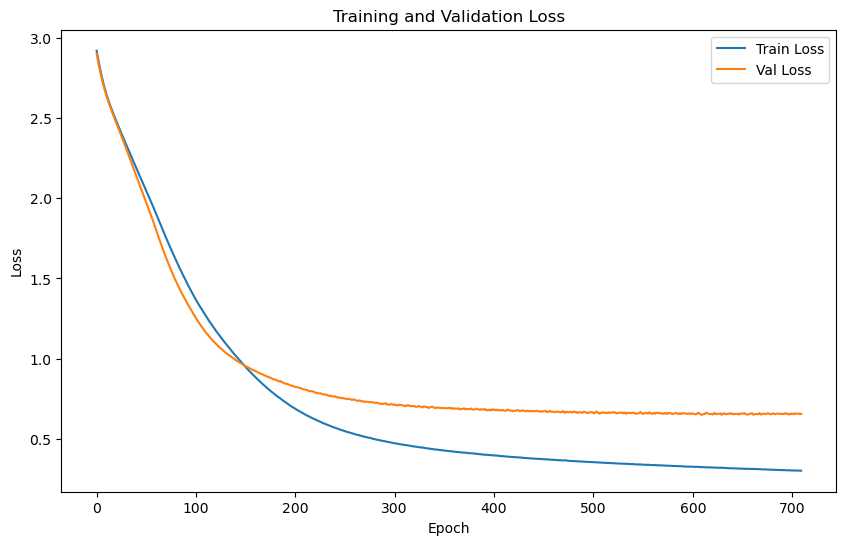

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9422 | Test Accuracy: 53.98%


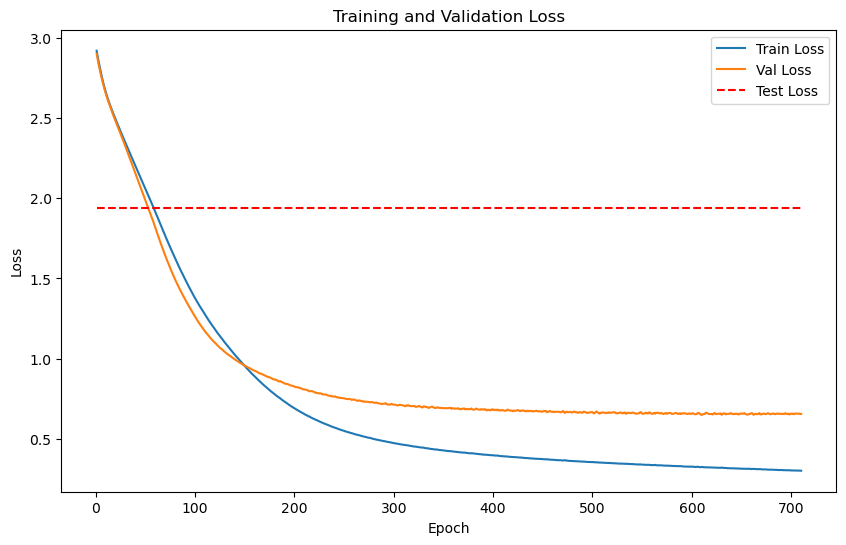

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9571 samples with 64 features each
LOG: Labels shape: (9571,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (9571, 64), 
Test labels shape: (9571,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.2612
Epoch [1/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.3767

Validation loss improved from inf to 0.3767. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.2547
Epoch [2/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.3728

Validation loss improved from 0.3767 to 0.3728. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.2479
Epoch [3/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.3687

Validation loss improved from 0.3728 to 0.3687. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4952
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.2414
Epoch [4/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.3647

Validation loss improved from 0.3687 to 0.3647. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.2366
Epoch [5/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.3617

Validation loss improved from 0.3647 to 0.3617. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2333
Epoch [6/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.3597

Validation loss improved from 0.3617 to 0.3597. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2299
Epoch [7/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.3580

Validation loss improved from 0.3597 to 0.3580. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.2272
Epoch [8/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.3564

Validation loss improved from 0.3580 to 0.3564. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.2250
Epoch [9/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.3551

Validation loss improved from 0.3564 to 0.3551. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.2231
Epoch [10/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.3542

Validation loss improved from 0.3551 to 0.3542. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.2217
Epoch [11/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.3536

Validation loss improved from 0.3542 to 0.3536. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4940
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.2206
Epoch [12/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.3534

Validation loss improved from 0.3536 to 0.3534. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.2199
Epoch [13/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.3530

Validation loss improved from 0.3534 to 0.3530. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.2197
Epoch [14/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.2197
Epoch [15/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.3527

Validation loss improved from 0.3528 to 0.3527. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.2195
Epoch [16/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.3525

Validation loss improved from 0.3527 to 0.3525. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.2192
Epoch [17/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.3523

Validation loss improved from 0.3525 to 0.3523. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.2186
Epoch [18/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.3519

Validation loss improved from 0.3523 to 0.3519. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4889
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.2178
Epoch [19/2000], Avg Train Loss: 0.4889, Avg Val Loss: 0.3515

Validation loss improved from 0.3519 to 0.3515. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.2169
Epoch [20/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3509

Validation loss improved from 0.3515 to 0.3509. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.2160
Epoch [21/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.3504

Validation loss improved from 0.3509 to 0.3504. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.2151
Epoch [22/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3499

Validation loss improved from 0.3504 to 0.3499. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.2141
Epoch [23/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.3493

Validation loss improved from 0.3499 to 0.3493. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4878
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.2132
Epoch [24/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.3486

Validation loss improved from 0.3493 to 0.3486. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.2122
Epoch [25/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.3479

Validation loss improved from 0.3486 to 0.3479. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.2113
Epoch [26/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.3472

Validation loss improved from 0.3479 to 0.3472. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.2104
Epoch [27/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.3465

Validation loss improved from 0.3472 to 0.3465. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.2095
Epoch [28/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.3458

Validation loss improved from 0.3465 to 0.3458. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.2086
Epoch [29/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.3451

Validation loss improved from 0.3458 to 0.3451. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.2076
Epoch [30/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.3445

Validation loss improved from 0.3451 to 0.3445. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.2067
Epoch [31/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.3438

Validation loss improved from 0.3445 to 0.3438. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2058
Epoch [32/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.3431

Validation loss improved from 0.3438 to 0.3431. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2049
Epoch [33/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.3424

Validation loss improved from 0.3431 to 0.3424. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2039
Epoch [34/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.3417

Validation loss improved from 0.3424 to 0.3417. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4828
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2030
Epoch [35/2000], Avg Train Loss: 0.4828, Avg Val Loss: 0.3411

Validation loss improved from 0.3417 to 0.3411. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.2020
Epoch [36/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.3404

Validation loss improved from 0.3411 to 0.3404. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2011
Epoch [37/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.3397

Validation loss improved from 0.3404 to 0.3397. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.2001
Epoch [38/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.3390

Validation loss improved from 0.3397 to 0.3390. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.1990
Epoch [39/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.3383

Validation loss improved from 0.3390 to 0.3383. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.1980
Epoch [40/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.3376

Validation loss improved from 0.3383 to 0.3376. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4799
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.1969
Epoch [41/2000], Avg Train Loss: 0.4799, Avg Val Loss: 0.3369

Validation loss improved from 0.3376 to 0.3369. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.1959
Epoch [42/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.3362

Validation loss improved from 0.3369 to 0.3362. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.1948
Epoch [43/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.3355

Validation loss improved from 0.3362 to 0.3355. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.1937
Epoch [44/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.3348

Validation loss improved from 0.3355 to 0.3348. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.1925
Epoch [45/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.3341

Validation loss improved from 0.3348 to 0.3341. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4786
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.1914
Epoch [46/2000], Avg Train Loss: 0.4786, Avg Val Loss: 0.3334

Validation loss improved from 0.3341 to 0.3334. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.1904
Epoch [47/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.3327

Validation loss improved from 0.3334 to 0.3327. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.1893
Epoch [48/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.3320

Validation loss improved from 0.3327 to 0.3320. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.1883
Epoch [49/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.3314

Validation loss improved from 0.3320 to 0.3314. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.1872
Epoch [50/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.3307

Validation loss improved from 0.3314 to 0.3307. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4802
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.1860
Epoch [51/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.3300

Validation loss improved from 0.3307 to 0.3300. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.1848
Epoch [52/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.3293

Validation loss improved from 0.3300 to 0.3293. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.1837
Epoch [53/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.3285

Validation loss improved from 0.3293 to 0.3285. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.1825
Epoch [54/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.3278

Validation loss improved from 0.3285 to 0.3278. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.1814
Epoch [55/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.3271

Validation loss improved from 0.3278 to 0.3271. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.1803
Epoch [56/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.3264

Validation loss improved from 0.3271 to 0.3264. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.1791
Epoch [57/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.3257

Validation loss improved from 0.3264 to 0.3257. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4720
    Batch [2/2], Val Loss: 0.1780
Epoch [58/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.3250

Validation loss improved from 0.3257 to 0.3250. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4717
    Batch [2/2], Val Loss: 0.1768
Epoch [59/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3243

Validation loss improved from 0.3250 to 0.3243. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.1758
Epoch [60/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.3236

Validation loss improved from 0.3243 to 0.3236. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.1748
Epoch [61/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.3230

Validation loss improved from 0.3236 to 0.3230. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.1738
Epoch [62/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.3224

Validation loss improved from 0.3230 to 0.3224. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4707
    Batch [2/2], Val Loss: 0.1728
Epoch [63/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.3218

Validation loss improved from 0.3224 to 0.3218. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.1718
Epoch [64/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.3212

Validation loss improved from 0.3218 to 0.3212. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4761
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.1709
Epoch [65/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.3206

Validation loss improved from 0.3212 to 0.3206. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.1699
Epoch [66/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.3199

Validation loss improved from 0.3206 to 0.3199. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.1689
Epoch [67/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.3193

Validation loss improved from 0.3199 to 0.3193. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.1678
Epoch [68/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.3187

Validation loss improved from 0.3193 to 0.3187. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.1669
Epoch [69/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.3181

Validation loss improved from 0.3187 to 0.3181. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.1659
Epoch [70/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.3175

Validation loss improved from 0.3181 to 0.3175. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.1650
Epoch [71/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.3169

Validation loss improved from 0.3175 to 0.3169. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.1640
Epoch [72/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.3163

Validation loss improved from 0.3169 to 0.3163. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.1631
Epoch [73/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3158

Validation loss improved from 0.3163 to 0.3158. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.1622
Epoch [74/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.3152

Validation loss improved from 0.3158 to 0.3152. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.1613
Epoch [75/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.3147

Validation loss improved from 0.3152 to 0.3147. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.1604
Epoch [76/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.3141

Validation loss improved from 0.3147 to 0.3141. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.1595
Epoch [77/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.3135

Validation loss improved from 0.3141 to 0.3135. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.1586
Epoch [78/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.3130

Validation loss improved from 0.3135 to 0.3130. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.1578
Epoch [79/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.3125

Validation loss improved from 0.3130 to 0.3125. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.1570
Epoch [80/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3120

Validation loss improved from 0.3125 to 0.3120. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.1562
Epoch [81/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.3115

Validation loss improved from 0.3120 to 0.3115. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.1554
Epoch [82/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.3110

Validation loss improved from 0.3115 to 0.3110. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.1547
Epoch [83/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.3106

Validation loss improved from 0.3110 to 0.3106. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.1539
Epoch [84/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.3101

Validation loss improved from 0.3106 to 0.3101. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.1531
Epoch [85/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.3097

Validation loss improved from 0.3101 to 0.3097. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.1524
Epoch [86/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3093

Validation loss improved from 0.3097 to 0.3093. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.1516
Epoch [87/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.3088

Validation loss improved from 0.3093 to 0.3088. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.1508
Epoch [88/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3083

Validation loss improved from 0.3088 to 0.3083. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.1501
Epoch [89/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.3079

Validation loss improved from 0.3083 to 0.3079. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.1494
Epoch [90/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.3075

Validation loss improved from 0.3079 to 0.3075. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.1488
Epoch [91/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.3071

Validation loss improved from 0.3075 to 0.3071. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.1482
Epoch [92/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3067

Validation loss improved from 0.3071 to 0.3067. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.1476
Epoch [93/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.3063

Validation loss improved from 0.3067 to 0.3063. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.1470
Epoch [94/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.3059

Validation loss improved from 0.3063 to 0.3059. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.1463
Epoch [95/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3055

Validation loss improved from 0.3059 to 0.3055. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4645
    Batch [2/2], Val Loss: 0.1457
Epoch [96/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.3051

Validation loss improved from 0.3055 to 0.3051. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.1450
Epoch [97/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.3047

Validation loss improved from 0.3051 to 0.3047. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.1444
Epoch [98/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.3043

Validation loss improved from 0.3047 to 0.3043. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.1437
Epoch [99/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3038

Validation loss improved from 0.3043 to 0.3038. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.1430
Epoch [100/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3034

Validation loss improved from 0.3038 to 0.3034. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.1423
Epoch [101/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3030

Validation loss improved from 0.3034 to 0.3030. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.1417
Epoch [102/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3026

Validation loss improved from 0.3030 to 0.3026. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.1411
Epoch [103/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.3022

Validation loss improved from 0.3026 to 0.3022. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.1404
Epoch [104/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3017

Validation loss improved from 0.3022 to 0.3017. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.1397
Epoch [105/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.3013

Validation loss improved from 0.3017 to 0.3013. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.1390
Epoch [106/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.3009

Validation loss improved from 0.3013 to 0.3009. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.1383
Epoch [107/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3005

Validation loss improved from 0.3009 to 0.3005. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.1377
Epoch [108/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.3001

Validation loss improved from 0.3005 to 0.3001. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.1371
Epoch [109/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.2997

Validation loss improved from 0.3001 to 0.2997. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.1365
Epoch [110/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.2994

Validation loss improved from 0.2997 to 0.2994. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.1360
Epoch [111/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.2991

Validation loss improved from 0.2994 to 0.2991. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.1355
Epoch [112/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.2988

Validation loss improved from 0.2991 to 0.2988. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.1350
Epoch [113/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.2985

Validation loss improved from 0.2988 to 0.2985. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4610
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.1346
Epoch [114/2000], Avg Train Loss: 0.4610, Avg Val Loss: 0.2982

Validation loss improved from 0.2985 to 0.2982. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.1342
Epoch [115/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.2980

Validation loss improved from 0.2982 to 0.2980. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.1338
Epoch [116/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.2977

Validation loss improved from 0.2980 to 0.2977. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.1335
Epoch [117/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.2975

Validation loss improved from 0.2977 to 0.2975. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.1332
Epoch [118/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.2972

Validation loss improved from 0.2975 to 0.2972. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.1328
Epoch [119/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.2969

Validation loss improved from 0.2972 to 0.2969. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.1324
Epoch [120/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.2967

Validation loss improved from 0.2969 to 0.2967. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4572
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.1320
Epoch [121/2000], Avg Train Loss: 0.4572, Avg Val Loss: 0.2964

Validation loss improved from 0.2967 to 0.2964. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.1315
Epoch [122/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.2961

Validation loss improved from 0.2964 to 0.2961. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.1311
Epoch [123/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.2958

Validation loss improved from 0.2961 to 0.2958. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.1307
Epoch [124/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.2956

Validation loss improved from 0.2958 to 0.2956. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.1303
Epoch [125/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2953

Validation loss improved from 0.2956 to 0.2953. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.1299
Epoch [126/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.2950

Validation loss improved from 0.2953 to 0.2950. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.1295
Epoch [127/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.2947

Validation loss improved from 0.2950 to 0.2947. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.1291
Epoch [128/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.2945

Validation loss improved from 0.2947 to 0.2945. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.1288
Epoch [129/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.2942

Validation loss improved from 0.2945 to 0.2942. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4534
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.1285
Epoch [130/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.2940

Validation loss improved from 0.2942 to 0.2940. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.1282
Epoch [131/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.2937

Validation loss improved from 0.2940 to 0.2937. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.1279
Epoch [132/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2935

Validation loss improved from 0.2937 to 0.2935. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.1275
Epoch [133/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.2933

Validation loss improved from 0.2935 to 0.2933. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.1272
Epoch [134/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.2930

Validation loss improved from 0.2933 to 0.2930. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.1269
Epoch [135/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2928

Validation loss improved from 0.2930 to 0.2928. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.1266
Epoch [136/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.2925

Validation loss improved from 0.2928 to 0.2925. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4524
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.1263
Epoch [137/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.2923

Validation loss improved from 0.2925 to 0.2923. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4582
    Batch [2/2], Val Loss: 0.1260
Epoch [138/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.2921

Validation loss improved from 0.2923 to 0.2921. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.1258
Epoch [139/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.2919

Validation loss improved from 0.2921 to 0.2919. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4579
    Batch [2/2], Val Loss: 0.1255
Epoch [140/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.2917

Validation loss improved from 0.2919 to 0.2917. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.1252
Epoch [141/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.2915

Validation loss improved from 0.2917 to 0.2915. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.1250
Epoch [142/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.2913

Validation loss improved from 0.2915 to 0.2913. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.1247
Epoch [143/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.2911

Validation loss improved from 0.2913 to 0.2911. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.1245
Epoch [144/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.2908

Validation loss improved from 0.2911 to 0.2908. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4571
    Batch [2/2], Val Loss: 0.1242
Epoch [145/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.2906

Validation loss improved from 0.2908 to 0.2906. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.1239
Epoch [146/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.2904

Validation loss improved from 0.2906 to 0.2904. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4568
    Batch [2/2], Val Loss: 0.1236
Epoch [147/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.2902

Validation loss improved from 0.2904 to 0.2902. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.1234
Epoch [148/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.2900

Validation loss improved from 0.2902 to 0.2900. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.1231
Epoch [149/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2898

Validation loss improved from 0.2900 to 0.2898. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.1228
Epoch [150/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2896

Validation loss improved from 0.2898 to 0.2896. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4562
    Batch [2/2], Val Loss: 0.1225
Epoch [151/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.2893

Validation loss improved from 0.2896 to 0.2893. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.1222
Epoch [152/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.2891

Validation loss improved from 0.2893 to 0.2891. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.1218
Epoch [153/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4513
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.1216
Epoch [154/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.1213
Epoch [155/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.2883

Validation loss improved from 0.2886 to 0.2883. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.1211
Epoch [156/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.2881

Validation loss improved from 0.2883 to 0.2881. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.1208
Epoch [157/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.2879

Validation loss improved from 0.2881 to 0.2879. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.1206
Epoch [158/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.2877

Validation loss improved from 0.2879 to 0.2877. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.1204
Epoch [159/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.2875

Validation loss improved from 0.2877 to 0.2875. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4545
    Batch [2/2], Val Loss: 0.1201
Epoch [160/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.2873

Validation loss improved from 0.2875 to 0.2873. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.1199
Epoch [161/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.2871

Validation loss improved from 0.2873 to 0.2871. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.1198
Epoch [162/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.2870

Validation loss improved from 0.2871 to 0.2870. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.1197
Epoch [163/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.2869

Validation loss improved from 0.2870 to 0.2869. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.1195
Epoch [164/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2867

Validation loss improved from 0.2869 to 0.2867. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.1194
Epoch [165/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.2866

Validation loss improved from 0.2867 to 0.2866. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.1192
Epoch [166/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.2864

Validation loss improved from 0.2866 to 0.2864. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.1191
Epoch [167/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.2862

Validation loss improved from 0.2864 to 0.2862. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.1189
Epoch [168/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.1188
Epoch [169/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.2859

Validation loss improved from 0.2861 to 0.2859. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.1187
Epoch [170/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.1186
Epoch [171/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.1185
Epoch [172/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2856

Validation loss improved from 0.2857 to 0.2856. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.1185
Epoch [173/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.2855

Validation loss improved from 0.2856 to 0.2855. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.1183
Epoch [174/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.1182
Epoch [175/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.1181
Epoch [176/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2851

Validation loss improved from 0.2853 to 0.2851. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.1179
Epoch [177/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.2850

Validation loss improved from 0.2851 to 0.2850. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.1178
Epoch [178/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.2848

Validation loss improved from 0.2850 to 0.2848. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.1176
Epoch [179/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.1174
Epoch [180/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.2845

Validation loss improved from 0.2847 to 0.2845. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4513
    Batch [2/2], Val Loss: 0.1172
Epoch [181/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2843

Validation loss improved from 0.2845 to 0.2843. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.1171
Epoch [182/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2841

Validation loss improved from 0.2843 to 0.2841. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4510
    Batch [2/2], Val Loss: 0.1169
Epoch [183/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.1167
Epoch [184/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2838

Validation loss improved from 0.2840 to 0.2838. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.1166
Epoch [185/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.1164
Epoch [186/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2835

Validation loss improved from 0.2837 to 0.2835. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.1162
Epoch [187/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2834

Validation loss improved from 0.2835 to 0.2834. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.1160
Epoch [188/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2832

Validation loss improved from 0.2834 to 0.2832. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4424
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.1158
Epoch [189/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.2830

Validation loss improved from 0.2832 to 0.2830. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.1156
Epoch [190/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.2828

Validation loss improved from 0.2830 to 0.2828. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.1154
Epoch [191/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2826

Validation loss improved from 0.2828 to 0.2826. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.1152
Epoch [192/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2825

Validation loss improved from 0.2826 to 0.2825. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.1150
Epoch [193/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2823

Validation loss improved from 0.2825 to 0.2823. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.1147
Epoch [194/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2821

Validation loss improved from 0.2823 to 0.2821. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.1145
Epoch [195/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2819

Validation loss improved from 0.2821 to 0.2819. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.1144
Epoch [196/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2817

Validation loss improved from 0.2819 to 0.2817. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.1143
Epoch [197/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2816

Validation loss improved from 0.2817 to 0.2816. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.1141
Epoch [198/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.1140
Epoch [199/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2813

Validation loss improved from 0.2815 to 0.2813. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.1139
Epoch [200/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.2812

Validation loss improved from 0.2813 to 0.2812. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.1137
Epoch [201/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2811

Validation loss improved from 0.2812 to 0.2811. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.1136
Epoch [202/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2810

Validation loss improved from 0.2811 to 0.2810. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4484
    Batch [2/2], Val Loss: 0.1134
Epoch [203/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2809

Validation loss improved from 0.2810 to 0.2809. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.1132
Epoch [204/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2808

Validation loss improved from 0.2809 to 0.2808. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4483
    Batch [2/2], Val Loss: 0.1130
Epoch [205/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2806

Validation loss improved from 0.2808 to 0.2806. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.1127
Epoch [206/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2805

Validation loss improved from 0.2806 to 0.2805. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.1125
Epoch [207/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2804

Validation loss improved from 0.2805 to 0.2804. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4482
    Batch [2/2], Val Loss: 0.1123
Epoch [208/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2802

Validation loss improved from 0.2804 to 0.2802. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.1121
Epoch [209/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2801

Validation loss improved from 0.2802 to 0.2801. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.1119
Epoch [210/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.2800

Validation loss improved from 0.2801 to 0.2800. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4481
    Batch [2/2], Val Loss: 0.1117
Epoch [211/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2799

Validation loss improved from 0.2800 to 0.2799. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.1115
Epoch [212/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2798

Validation loss improved from 0.2799 to 0.2798. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4479
    Batch [2/2], Val Loss: 0.1114
Epoch [213/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2797

Validation loss improved from 0.2798 to 0.2797. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4478
    Batch [2/2], Val Loss: 0.1113
Epoch [214/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4477
    Batch [2/2], Val Loss: 0.1112
Epoch [215/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2794

Validation loss improved from 0.2796 to 0.2794. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.1110
Epoch [216/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2793

Validation loss improved from 0.2794 to 0.2793. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.1108
Epoch [217/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.2791

Validation loss improved from 0.2793 to 0.2791. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4472
    Batch [2/2], Val Loss: 0.1106
Epoch [218/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2789

Validation loss improved from 0.2791 to 0.2789. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4471
    Batch [2/2], Val Loss: 0.1103
Epoch [219/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.2787

Validation loss improved from 0.2789 to 0.2787. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4470
    Batch [2/2], Val Loss: 0.1101
Epoch [220/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2785

Validation loss improved from 0.2787 to 0.2785. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4468
    Batch [2/2], Val Loss: 0.1099
Epoch [221/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2784

Validation loss improved from 0.2785 to 0.2784. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.1097
Epoch [222/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2782

Validation loss improved from 0.2784 to 0.2782. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.1095
Epoch [223/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2781

Validation loss improved from 0.2782 to 0.2781. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4465
    Batch [2/2], Val Loss: 0.1093
Epoch [224/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2779

Validation loss improved from 0.2781 to 0.2779. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.1091
Epoch [225/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.1089
Epoch [226/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2776

Validation loss improved from 0.2778 to 0.2776. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.1087
Epoch [227/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2774

Validation loss improved from 0.2776 to 0.2774. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4460
    Batch [2/2], Val Loss: 0.1085
Epoch [228/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.1083
Epoch [229/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2771

Validation loss improved from 0.2773 to 0.2771. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4458
    Batch [2/2], Val Loss: 0.1080
Epoch [230/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2769

Validation loss improved from 0.2771 to 0.2769. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4456
    Batch [2/2], Val Loss: 0.1078
Epoch [231/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2767

Validation loss improved from 0.2769 to 0.2767. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.1076
Epoch [232/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2766

Validation loss improved from 0.2767 to 0.2766. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.1074
Epoch [233/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2764

Validation loss improved from 0.2766 to 0.2764. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.1072
Epoch [234/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2762

Validation loss improved from 0.2764 to 0.2762. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4451
    Batch [2/2], Val Loss: 0.1071
Epoch [235/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.1069
Epoch [236/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4447
    Batch [2/2], Val Loss: 0.1068
Epoch [237/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2757

Validation loss improved from 0.2759 to 0.2757. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4445
    Batch [2/2], Val Loss: 0.1066
Epoch [238/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4443
    Batch [2/2], Val Loss: 0.1065
Epoch [239/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2754

Validation loss improved from 0.2756 to 0.2754. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4440
    Batch [2/2], Val Loss: 0.1063
Epoch [240/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.1061
Epoch [241/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.1059
Epoch [242/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2748

Validation loss improved from 0.2750 to 0.2748. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4435
    Batch [2/2], Val Loss: 0.1057
Epoch [243/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2746

Validation loss improved from 0.2748 to 0.2746. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4433
    Batch [2/2], Val Loss: 0.1056
Epoch [244/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2744

Validation loss improved from 0.2746 to 0.2744. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.1054
Epoch [245/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4430
    Batch [2/2], Val Loss: 0.1052
Epoch [246/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2741

Validation loss improved from 0.2743 to 0.2741. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4429
    Batch [2/2], Val Loss: 0.1050
Epoch [247/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.1049
Epoch [248/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.1048
Epoch [249/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4426
    Batch [2/2], Val Loss: 0.1048
Epoch [250/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4425
    Batch [2/2], Val Loss: 0.1047
Epoch [251/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.1046
Epoch [252/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.1044
Epoch [253/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2733

Validation loss improved from 0.2735 to 0.2733. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.1042
Epoch [254/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2731

Validation loss improved from 0.2733 to 0.2731. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4419
    Batch [2/2], Val Loss: 0.1040
Epoch [255/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2730

Validation loss improved from 0.2731 to 0.2730. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.1038
Epoch [256/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4415
    Batch [2/2], Val Loss: 0.1036
Epoch [257/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.1034
Epoch [258/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2723

Validation loss improved from 0.2726 to 0.2723. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4411
    Batch [2/2], Val Loss: 0.1031
Epoch [259/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2721

Validation loss improved from 0.2723 to 0.2721. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4409
    Batch [2/2], Val Loss: 0.1030
Epoch [260/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2719

Validation loss improved from 0.2721 to 0.2719. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4408
    Batch [2/2], Val Loss: 0.1028
Epoch [261/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4406
    Batch [2/2], Val Loss: 0.1027
Epoch [262/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4405
    Batch [2/2], Val Loss: 0.1025
Epoch [263/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2715

Validation loss improved from 0.2717 to 0.2715. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4404
    Batch [2/2], Val Loss: 0.1023
Epoch [264/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4403
    Batch [2/2], Val Loss: 0.1021
Epoch [265/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2712

Validation loss improved from 0.2714 to 0.2712. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.1020
Epoch [266/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.1019
Epoch [267/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4399
    Batch [2/2], Val Loss: 0.1018
Epoch [268/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2708

Validation loss improved from 0.2710 to 0.2708. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4398
    Batch [2/2], Val Loss: 0.1016
Epoch [269/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.1014
Epoch [270/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.1013
Epoch [271/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.2704

Validation loss improved from 0.2706 to 0.2704. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4395
    Batch [2/2], Val Loss: 0.1011
Epoch [272/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4394
    Batch [2/2], Val Loss: 0.1010
Epoch [273/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.1009
Epoch [274/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4391
    Batch [2/2], Val Loss: 0.1008
Epoch [275/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2700

Validation loss improved from 0.2701 to 0.2700. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.1009
Epoch [276/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2699

Validation loss improved from 0.2700 to 0.2699. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4388
    Batch [2/2], Val Loss: 0.1009
Epoch [277/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2699

Validation loss improved from 0.2699 to 0.2699. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.1009
Epoch [278/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2698

Validation loss improved from 0.2699 to 0.2698. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1009
Epoch [279/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1010
Epoch [280/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2697

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4384
    Batch [2/2], Val Loss: 0.1011
Epoch [281/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4383
    Batch [2/2], Val Loss: 0.1011
Epoch [282/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.1011
Epoch [283/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2696

Validation loss improved from 0.2697 to 0.2696. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.1012
Epoch [284/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2696

Validation loss improved from 0.2696 to 0.2696. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4380
    Batch [2/2], Val Loss: 0.1012
Epoch [285/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2696

Validation loss improved from 0.2696 to 0.2696. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4378
    Batch [2/2], Val Loss: 0.1012
Epoch [286/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4377
    Batch [2/2], Val Loss: 0.1012
Epoch [287/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2694

Validation loss improved from 0.2695 to 0.2694. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4375
    Batch [2/2], Val Loss: 0.1011
Epoch [288/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2693

Validation loss improved from 0.2694 to 0.2693. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4373
    Batch [2/2], Val Loss: 0.1011
Epoch [289/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2692

Validation loss improved from 0.2693 to 0.2692. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4371
    Batch [2/2], Val Loss: 0.1010
Epoch [290/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.1009
Epoch [291/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2689

Validation loss improved from 0.2691 to 0.2689. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4367
    Batch [2/2], Val Loss: 0.1008
Epoch [292/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2688

Validation loss improved from 0.2689 to 0.2688. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4365
    Batch [2/2], Val Loss: 0.1007
Epoch [293/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2686

Validation loss improved from 0.2688 to 0.2686. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4363
    Batch [2/2], Val Loss: 0.1006
Epoch [294/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2685

Validation loss improved from 0.2686 to 0.2685. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.1005
Epoch [295/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1004
Epoch [296/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2682

Validation loss improved from 0.2684 to 0.2682. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4358
    Batch [2/2], Val Loss: 0.1004
Epoch [297/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2681

Validation loss improved from 0.2682 to 0.2681. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.1003
Epoch [298/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.1003
Epoch [299/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4353
    Batch [2/2], Val Loss: 0.1003
Epoch [300/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2678

Validation loss improved from 0.2679 to 0.2678. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4351
    Batch [2/2], Val Loss: 0.1004
Epoch [301/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2678

Validation loss improved from 0.2678 to 0.2678. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4349
    Batch [2/2], Val Loss: 0.1005
Epoch [302/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2677

Validation loss improved from 0.2678 to 0.2677. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4348
    Batch [2/2], Val Loss: 0.1005
Epoch [303/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4345
    Batch [2/2], Val Loss: 0.1005
Epoch [304/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4343
    Batch [2/2], Val Loss: 0.1004
Epoch [305/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2673

Validation loss improved from 0.2675 to 0.2673. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.1002
Epoch [306/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4341
    Batch [2/2], Val Loss: 0.1001
Epoch [307/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.1000
Epoch [308/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4339
    Batch [2/2], Val Loss: 0.0999
Epoch [309/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.0997
Epoch [310/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.0994
Epoch [311/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2666

Validation loss improved from 0.2668 to 0.2666. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.0991
Epoch [312/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2664

Validation loss improved from 0.2666 to 0.2664. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.0988
Epoch [313/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.0986
Epoch [314/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2661

Validation loss improved from 0.2663 to 0.2661. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.0984
Epoch [315/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0982
Epoch [316/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2658

Validation loss improved from 0.2660 to 0.2658. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4334
    Batch [2/2], Val Loss: 0.0980
Epoch [317/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4332
    Batch [2/2], Val Loss: 0.0980
Epoch [318/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4083
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4331
    Batch [2/2], Val Loss: 0.0979
Epoch [319/2000], Avg Train Loss: 0.4083, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.0978
Epoch [320/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4328
    Batch [2/2], Val Loss: 0.0978
Epoch [321/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4327
    Batch [2/2], Val Loss: 0.0978
Epoch [322/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2653

Validation loss improved from 0.2653 to 0.2653. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.0978
Epoch [323/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4097
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.0978
Epoch [324/2000], Avg Train Loss: 0.4097, Avg Val Loss: 0.2652

Validation loss improved from 0.2652 to 0.2652. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.0978
Epoch [325/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.0977
Epoch [326/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2651

Validation loss improved from 0.2651 to 0.2651. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4324
    Batch [2/2], Val Loss: 0.0976
Epoch [327/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.0976
Epoch [328/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.0974
Epoch [329/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4321
    Batch [2/2], Val Loss: 0.0973
Epoch [330/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.0972
Epoch [331/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.0970
Epoch [332/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.0968
Epoch [333/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4316
    Batch [2/2], Val Loss: 0.0967
Epoch [334/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2641

Validation loss improved from 0.2643 to 0.2641. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.0965
Epoch [335/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.0962
Epoch [336/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2638

Validation loss improved from 0.2640 to 0.2638. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4312
    Batch [2/2], Val Loss: 0.0959
Epoch [337/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2636

Validation loss improved from 0.2638 to 0.2636. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4311
    Batch [2/2], Val Loss: 0.0958
Epoch [338/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0956
Epoch [339/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.0956
Epoch [340/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.2633

Validation loss improved from 0.2633 to 0.2633. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.0955
Epoch [341/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.0954
Epoch [342/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.0954
Epoch [343/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.0954
Epoch [344/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.0954
Epoch [345/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.0955
Epoch [346/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4303
    Batch [2/2], Val Loss: 0.0956
Epoch [347/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.0956
Epoch [348/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4301
    Batch [2/2], Val Loss: 0.0957
Epoch [349/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2629

Validation loss improved from 0.2629 to 0.2629. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.0957
Epoch [350/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.3992
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.0957
Epoch [351/2000], Avg Train Loss: 0.3992, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.0957
Epoch [352/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.0958
Epoch [353/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4295
    Batch [2/2], Val Loss: 0.0958
Epoch [354/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.0958
Epoch [355/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4292
    Batch [2/2], Val Loss: 0.0959
Epoch [356/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4291
    Batch [2/2], Val Loss: 0.0960
Epoch [357/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2626

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.0960
Epoch [358/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4288
    Batch [2/2], Val Loss: 0.0961
Epoch [359/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3968
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.0961
Epoch [360/2000], Avg Train Loss: 0.3968, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4283
    Batch [2/2], Val Loss: 0.0960
Epoch [361/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2621

Validation loss improved from 0.2623 to 0.2621. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4280
    Batch [2/2], Val Loss: 0.0960
Epoch [362/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4278
    Batch [2/2], Val Loss: 0.0961
Epoch [363/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.2620

Validation loss improved from 0.2620 to 0.2620. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4275
    Batch [2/2], Val Loss: 0.0962
Epoch [364/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.0963
Epoch [365/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.0963
Epoch [366/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.0963
Epoch [367/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.0963
Epoch [368/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.2616

Validation loss improved from 0.2616 to 0.2616. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.0964
Epoch [369/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2616

Validation loss improved from 0.2616 to 0.2616. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4267
    Batch [2/2], Val Loss: 0.0964
Epoch [370/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2616

Validation loss improved from 0.2616 to 0.2616. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.0964
Epoch [371/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.0964
Epoch [372/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.0964
Epoch [373/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2614

Validation loss improved from 0.2614 to 0.2614. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.0964
Epoch [374/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.0963
Epoch [375/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2613

Validation loss improved from 0.2613 to 0.2613. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.0963
Epoch [376/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.0962
Epoch [377/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.0961
Epoch [378/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2609

Validation loss improved from 0.2611 to 0.2609. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4254
    Batch [2/2], Val Loss: 0.0959
Epoch [379/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2607

Validation loss improved from 0.2609 to 0.2607. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4252
    Batch [2/2], Val Loss: 0.0957
Epoch [380/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2605

Validation loss improved from 0.2607 to 0.2605. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.0956
Epoch [381/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2602

Validation loss improved from 0.2605 to 0.2602. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.0955
Epoch [382/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.0953
Epoch [383/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2598

Validation loss improved from 0.2601 to 0.2598. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.0951
Epoch [384/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2596

Validation loss improved from 0.2598 to 0.2596. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.0949
Epoch [385/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2593

Validation loss improved from 0.2596 to 0.2593. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.0947
Epoch [386/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.0946
Epoch [387/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.0944
Epoch [388/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2589

Validation loss improved from 0.2591 to 0.2589. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4232
    Batch [2/2], Val Loss: 0.0943
Epoch [389/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4230
    Batch [2/2], Val Loss: 0.0942
Epoch [390/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2586

Validation loss improved from 0.2588 to 0.2586. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4228
    Batch [2/2], Val Loss: 0.0940
Epoch [391/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2584

Validation loss improved from 0.2586 to 0.2584. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.0938
Epoch [392/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2582

Validation loss improved from 0.2584 to 0.2582. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4224
    Batch [2/2], Val Loss: 0.0936
Epoch [393/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2580

Validation loss improved from 0.2582 to 0.2580. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4223
    Batch [2/2], Val Loss: 0.0935
Epoch [394/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4220
    Batch [2/2], Val Loss: 0.0933
Epoch [395/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2577

Validation loss improved from 0.2579 to 0.2577. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4218
    Batch [2/2], Val Loss: 0.0932
Epoch [396/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2575

Validation loss improved from 0.2577 to 0.2575. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4216
    Batch [2/2], Val Loss: 0.0931
Epoch [397/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2573

Validation loss improved from 0.2575 to 0.2573. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.0931
Epoch [398/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.0930
Epoch [399/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.0929
Epoch [400/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2569

Validation loss improved from 0.2571 to 0.2569. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.0928
Epoch [401/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2567

Validation loss improved from 0.2569 to 0.2567. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4205
    Batch [2/2], Val Loss: 0.0928
Epoch [402/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.0927
Epoch [403/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.0927
Epoch [404/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.0927
Epoch [405/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4195
    Batch [2/2], Val Loss: 0.0926
Epoch [406/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2561

Validation loss improved from 0.2563 to 0.2561. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.0926
Epoch [407/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2559

Validation loss improved from 0.2561 to 0.2559. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.0925
Epoch [408/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.0924
Epoch [409/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2556

Validation loss improved from 0.2558 to 0.2556. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.0923
Epoch [410/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0920
Epoch [411/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2553

Validation loss improved from 0.2555 to 0.2553. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0919
Epoch [412/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0919
Epoch [413/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0918
Epoch [414/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0917
Epoch [415/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0916
Epoch [416/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2551

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.0917
Epoch [417/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0916
Epoch [418/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.0915
Epoch [419/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3843
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.0915
Epoch [420/2000], Avg Train Loss: 0.3843, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.0915
Epoch [421/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.0915
Epoch [422/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.0914
Epoch [423/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.0913
Epoch [424/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.0911
Epoch [425/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2545

Validation loss improved from 0.2547 to 0.2545. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0911
Epoch [426/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0910
Epoch [427/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0909
Epoch [428/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0908
Epoch [429/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0908
Epoch [430/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0907
Epoch [431/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0905
Epoch [432/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3822
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0905
Epoch [433/2000], Avg Train Loss: 0.3822, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0905
Epoch [434/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2538

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0905
Epoch [435/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0904
Epoch [436/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.0904
Epoch [437/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2538

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4173
    Batch [2/2], Val Loss: 0.0903
Epoch [438/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2538

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0903
Epoch [439/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2538

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0903
Epoch [440/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.0903
Epoch [441/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.0902
Epoch [442/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0900
Epoch [443/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2539

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0899
Epoch [444/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2538

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0898
Epoch [445/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0896
Epoch [446/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2537

Validation loss improved from 0.2537 to 0.2537. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0894
Epoch [447/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0891
Epoch [448/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0889
Epoch [449/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0888
Epoch [450/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0885
Epoch [451/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.0883
Epoch [452/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.0881
Epoch [453/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2529

Validation loss improved from 0.2531 to 0.2529. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.0878
Epoch [454/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4174
    Batch [2/2], Val Loss: 0.0877
Epoch [455/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2525

Validation loss improved from 0.2528 to 0.2525. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4171
    Batch [2/2], Val Loss: 0.0875
Epoch [456/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2523

Validation loss improved from 0.2525 to 0.2523. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.0874
Epoch [457/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2521

Validation loss improved from 0.2523 to 0.2521. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.0874
Epoch [458/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.0874
Epoch [459/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2519

Validation loss improved from 0.2521 to 0.2519. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4161
    Batch [2/2], Val Loss: 0.0875
Epoch [460/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4158
    Batch [2/2], Val Loss: 0.0875
Epoch [461/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.0875
Epoch [462/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.0875
Epoch [463/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4151
    Batch [2/2], Val Loss: 0.0875
Epoch [464/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4148
    Batch [2/2], Val Loss: 0.0876
Epoch [465/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4146
    Batch [2/2], Val Loss: 0.0876
Epoch [466/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.0876
Epoch [467/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.0878
Epoch [468/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.0878
Epoch [469/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2509

Validation loss improved from 0.2509 to 0.2509. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4138
    Batch [2/2], Val Loss: 0.0878
Epoch [470/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4137
    Batch [2/2], Val Loss: 0.0876
Epoch [471/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.0875
Epoch [472/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4135
    Batch [2/2], Val Loss: 0.0874
Epoch [473/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2505

Validation loss improved from 0.2506 to 0.2505. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.0872
Epoch [474/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2503

Validation loss improved from 0.2505 to 0.2503. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.0870
Epoch [475/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2501

Validation loss improved from 0.2503 to 0.2501. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4130
    Batch [2/2], Val Loss: 0.0869
Epoch [476/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2499

Validation loss improved from 0.2501 to 0.2499. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0868
Epoch [477/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.0866
Epoch [478/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.0866
Epoch [479/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.0864
Epoch [480/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0863
Epoch [481/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.0862
Epoch [482/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.0862
Epoch [483/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.0862
Epoch [484/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.0862
Epoch [485/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.0863
Epoch [486/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.0863
Epoch [487/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.0863
Epoch [488/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2488

Validation loss improved from 0.2490 to 0.2488. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.0861
Epoch [489/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.0859
Epoch [490/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0858
Epoch [491/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.0857
Epoch [492/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0856
Epoch [493/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2483

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0856
Epoch [494/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0857
Epoch [495/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.0858
Epoch [496/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0859
Epoch [497/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0860
Epoch [498/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0861
Epoch [499/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0861
Epoch [500/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0861
Epoch [501/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2484

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0860
Epoch [502/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2483

Validation loss improved from 0.2483 to 0.2483. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.0858
Epoch [503/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2482

Validation loss improved from 0.2483 to 0.2482. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.0856
Epoch [504/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2480

Validation loss improved from 0.2482 to 0.2480. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.0854
Epoch [505/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2479

Validation loss improved from 0.2480 to 0.2479. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.0852
Epoch [506/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.0850
Epoch [507/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2476

Validation loss improved from 0.2478 to 0.2476. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.0849
Epoch [508/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.0847
Epoch [509/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4102
    Batch [2/2], Val Loss: 0.0845
Epoch [510/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.0844
Epoch [511/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.0843
Epoch [512/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0842
Epoch [513/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0842
Epoch [514/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2475

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0840
Epoch [515/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.0840
Epoch [516/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2474

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.0839
Epoch [517/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.0839
Epoch [518/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.0838
Epoch [519/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.0838
Epoch [520/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2469

Validation loss improved from 0.2471 to 0.2469. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4095
    Batch [2/2], Val Loss: 0.0838
Epoch [521/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2467

Validation loss improved from 0.2469 to 0.2467. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4090
    Batch [2/2], Val Loss: 0.0838
Epoch [522/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2464

Validation loss improved from 0.2467 to 0.2464. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4086
    Batch [2/2], Val Loss: 0.0838
Epoch [523/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2462

Validation loss improved from 0.2464 to 0.2462. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4083
    Batch [2/2], Val Loss: 0.0839
Epoch [524/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.0839
Epoch [525/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.2459

Validation loss improved from 0.2461 to 0.2459. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4078
    Batch [2/2], Val Loss: 0.0840
Epoch [526/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.0840
Epoch [527/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4075
    Batch [2/2], Val Loss: 0.0840
Epoch [528/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.0841
Epoch [529/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2458

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.0843
Epoch [530/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.0845
Epoch [531/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.0848
Epoch [532/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4073
    Batch [2/2], Val Loss: 0.0849
Epoch [533/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.0850
Epoch [534/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4071
    Batch [2/2], Val Loss: 0.0852
Epoch [535/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.0854
Epoch [536/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4069
    Batch [2/2], Val Loss: 0.0855
Epoch [537/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2462

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4068
    Batch [2/2], Val Loss: 0.0855
Epoch [538/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.0855
Epoch [539/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2461

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.0854
Epoch [540/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.0854
Epoch [541/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2460

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0853
Epoch [542/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2459

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.0853
Epoch [543/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2457

Validation loss improved from 0.2457 to 0.2457. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.0851
Epoch [544/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4059
    Batch [2/2], Val Loss: 0.0850
Epoch [545/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0848
Epoch [546/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2452

Validation loss improved from 0.2454 to 0.2452. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0848
Epoch [547/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0847
Epoch [548/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.0847
Epoch [549/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0847
Epoch [550/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0848
Epoch [551/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3584
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0849
Epoch [552/2000], Avg Train Loss: 0.3584, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0849
Epoch [553/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3625
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0848
Epoch [554/2000], Avg Train Loss: 0.3625, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0847
Epoch [555/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.0844
Epoch [556/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4054
    Batch [2/2], Val Loss: 0.0842
Epoch [557/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2448

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0839
Epoch [558/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4061
    Batch [2/2], Val Loss: 0.0837
Epoch [559/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.0835
Epoch [560/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.0834
Epoch [561/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.0833
Epoch [562/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2450

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4066
    Batch [2/2], Val Loss: 0.0832
Epoch [563/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2449

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4064
    Batch [2/2], Val Loss: 0.0830
Epoch [564/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.0828
Epoch [565/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2445

Validation loss improved from 0.2447 to 0.2445. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.0826
Epoch [566/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0825
Epoch [567/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.0823
Epoch [568/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2440

Validation loss improved from 0.2442 to 0.2440. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3608
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4057
    Batch [2/2], Val Loss: 0.0822
Epoch [569/2000], Avg Train Loss: 0.3608, Avg Val Loss: 0.2440

Validation loss improved from 0.2440 to 0.2440. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.0822
Epoch [570/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2438

Validation loss improved from 0.2440 to 0.2438. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.0822
Epoch [571/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.0823
Epoch [572/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.0824
Epoch [573/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.0823
Epoch [574/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2433

Validation loss improved from 0.2435 to 0.2433. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.0824
Epoch [575/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.0823
Epoch [576/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.0822
Epoch [577/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.0821
Epoch [578/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.0821
Epoch [579/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.0819
Epoch [580/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.0818
Epoch [581/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0818
Epoch [582/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.2426

Validation loss improved from 0.2426 to 0.2426. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0818
Epoch [583/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2426

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.0818
Epoch [584/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2426

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.0816
Epoch [585/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.0814
Epoch [586/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.0811
Epoch [587/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.0809
Epoch [588/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2421

Validation loss improved from 0.2423 to 0.2421. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0807
Epoch [589/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0807
Epoch [590/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0806
Epoch [591/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.0806
Epoch [592/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.0805
Epoch [593/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.0805
Epoch [594/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2418

Validation loss improved from 0.2418 to 0.2418. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.0803
Epoch [595/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0803
Epoch [596/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0803
Epoch [597/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.0804
Epoch [598/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.0804
Epoch [599/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.0805
Epoch [600/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.0805
Epoch [601/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2415

Validation loss improved from 0.2415 to 0.2415. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.0805
Epoch [602/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.0805
Epoch [603/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2414

Validation loss improved from 0.2414 to 0.2414. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.0805
Epoch [604/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4019
    Batch [2/2], Val Loss: 0.0805
Epoch [605/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.0803
Epoch [606/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2410

Validation loss improved from 0.2412 to 0.2410. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.0802
Epoch [607/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.0801
Epoch [608/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.0800
Epoch [609/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2405

Validation loss improved from 0.2408 to 0.2405. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.0800
Epoch [610/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.0801
Epoch [611/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.0801
Epoch [612/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2401

Validation loss improved from 0.2403 to 0.2401. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.0802
Epoch [613/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2401

Validation loss improved from 0.2401 to 0.2401. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0802
Epoch [614/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0802
Epoch [615/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2400

Validation loss improved from 0.2400 to 0.2400. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0803
Epoch [616/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2400

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0803
Epoch [617/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0801
Epoch [618/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0801
Epoch [619/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2399

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0801
Epoch [620/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0799
Epoch [621/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0799
Epoch [622/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0798
Epoch [623/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0798
Epoch [624/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0798
Epoch [625/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0797
Epoch [626/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2398

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0795
Epoch [627/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.0794
Epoch [628/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.0793
Epoch [629/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0792
Epoch [630/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.0790
Epoch [631/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.0790
Epoch [632/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.0788
Epoch [633/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3458
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.0785
Epoch [634/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.2389

Validation loss improved from 0.2391 to 0.2389. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.0781
Epoch [635/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2386

Validation loss improved from 0.2389 to 0.2386. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.0778
Epoch [636/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2384

Validation loss improved from 0.2386 to 0.2384. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.0777
Epoch [637/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2383

Validation loss improved from 0.2384 to 0.2383. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.0775
Epoch [638/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2382

Validation loss improved from 0.2383 to 0.2382. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.0774
Epoch [639/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2381

Validation loss improved from 0.2382 to 0.2381. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.0771
Epoch [640/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.2379

Validation loss improved from 0.2381 to 0.2379. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.0770
Epoch [641/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2377

Validation loss improved from 0.2379 to 0.2377. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.0769
Epoch [642/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.0769
Epoch [643/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.0769
Epoch [644/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.0769
Epoch [645/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2374

Validation loss improved from 0.2374 to 0.2374. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.0769
Epoch [646/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2372

Validation loss improved from 0.2374 to 0.2372. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0770
Epoch [647/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.0769
Epoch [648/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0771
Epoch [649/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2370

Validation loss improved from 0.2370 to 0.2370. Saving model...
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0772
Epoch [650/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2370

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.0772
Epoch [651/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2370

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0771
Epoch [652/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.0769
Epoch [653/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.0767
Epoch [654/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2366

Validation loss improved from 0.2368 to 0.2366. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.0764
Epoch [655/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.2364

Validation loss improved from 0.2366 to 0.2364. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.0762
Epoch [656/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2362

Validation loss improved from 0.2364 to 0.2362. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.0760
Epoch [657/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.0759
Epoch [658/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.0758
Epoch [659/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3966
    Batch [2/2], Val Loss: 0.0758
Epoch [660/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0759
Epoch [661/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.0760
Epoch [662/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.0762
Epoch [663/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.0764
Epoch [664/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.0764
Epoch [665/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0764
Epoch [666/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0764
Epoch [667/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.0763
Epoch [668/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3432
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0764
Epoch [669/2000], Avg Train Loss: 0.3432, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3348
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.0764
Epoch [670/2000], Avg Train Loss: 0.3348, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.0765
Epoch [671/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3373
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.0765
Epoch [672/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.0765
Epoch [673/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2366

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.0766
Epoch [674/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2365

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3960
    Batch [2/2], Val Loss: 0.0767
Epoch [675/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2364

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.0767
Epoch [676/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3956
    Batch [2/2], Val Loss: 0.0766
Epoch [677/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.0765
Epoch [678/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3952
    Batch [2/2], Val Loss: 0.0765
Epoch [679/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3951
    Batch [2/2], Val Loss: 0.0765
Epoch [680/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.0765
Epoch [681/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0766
Epoch [682/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0767
Epoch [683/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2358

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3951
    Batch [2/2], Val Loss: 0.0767
Epoch [684/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3360
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.0770
Epoch [685/2000], Avg Train Loss: 0.3360, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0772
Epoch [686/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3398
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.0771
Epoch [687/2000], Avg Train Loss: 0.3398, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.0771
Epoch [688/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3323
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.0771
Epoch [689/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.0773
Epoch [690/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3947
    Batch [2/2], Val Loss: 0.0775
Epoch [691/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.0778
Epoch [692/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2361

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.0781
Epoch [693/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.0784
Epoch [694/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3341
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.0788
Epoch [695/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2363

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.0789
Epoch [696/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2362

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.0789
Epoch [697/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.0788
Epoch [698/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2359

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3367
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.0786
Epoch [699/2000], Avg Train Loss: 0.3367, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.0784
Epoch [700/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2354

Validation loss improved from 0.2356 to 0.2354. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.0782
Epoch [701/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.2352

Validation loss improved from 0.2354 to 0.2352. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3328
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3922
    Batch [2/2], Val Loss: 0.0780
Epoch [702/2000], Avg Train Loss: 0.3328, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.0777
Epoch [703/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.0774
Epoch [704/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2349

Validation loss improved from 0.2350 to 0.2349. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.0771
Epoch [705/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2348

Validation loss improved from 0.2349 to 0.2348. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3324
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.0770
Epoch [706/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2347

Validation loss improved from 0.2348 to 0.2347. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.0769
Epoch [707/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2347

Validation loss improved from 0.2347 to 0.2347. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.0769
Epoch [708/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.0769
Epoch [709/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0769
Epoch [710/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0770
Epoch [711/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.0771
Epoch [712/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3312
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.0773
Epoch [713/2000], Avg Train Loss: 0.3312, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.0777
Epoch [714/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3922
    Batch [2/2], Val Loss: 0.0780
Epoch [715/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3356
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.0782
Epoch [716/2000], Avg Train Loss: 0.3356, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.0785
Epoch [717/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2351

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.0787
Epoch [718/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.0790
Epoch [719/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.0792
Epoch [720/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.2350

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.0794
Epoch [721/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0796
Epoch [722/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.2349

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3354
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.0797
Epoch [723/2000], Avg Train Loss: 0.3354, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3313
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.0796
Epoch [724/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.0794
Epoch [725/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2345

Validation loss improved from 0.2347 to 0.2345. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.0791
Epoch [726/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3290
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.0792
Epoch [727/2000], Avg Train Loss: 0.3290, Avg Val Loss: 0.2341

Validation loss improved from 0.2343 to 0.2341. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3295
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.0789
Epoch [728/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.2338

Validation loss improved from 0.2341 to 0.2338. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3327
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.0785
Epoch [729/2000], Avg Train Loss: 0.3327, Avg Val Loss: 0.2334

Validation loss improved from 0.2338 to 0.2334. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0782
Epoch [730/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2332

Validation loss improved from 0.2334 to 0.2332. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0778
Epoch [731/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2331

Validation loss improved from 0.2332 to 0.2331. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0774
Epoch [732/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2329

Validation loss improved from 0.2331 to 0.2329. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.0772
Epoch [733/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.0773
Epoch [734/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.0773
Epoch [735/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3319
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.0776
Epoch [736/2000], Avg Train Loss: 0.3319, Avg Val Loss: 0.2332

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.0778
Epoch [737/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2334

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.0780
Epoch [738/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2335

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.3302
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.0781
Epoch [739/2000], Avg Train Loss: 0.3302, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.0782
Epoch [740/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.0784
Epoch [741/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3261
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.0785
Epoch [742/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.2342

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.0787
Epoch [743/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.0789
Epoch [744/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0791
Epoch [745/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.3303
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.0793
Epoch [746/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.0793
Epoch [747/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2348

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.0793
Epoch [748/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.0794
Epoch [749/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.0794
Epoch [750/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.0792
Epoch [751/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2341

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3283
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.0790
Epoch [752/2000], Avg Train Loss: 0.3283, Avg Val Loss: 0.2340

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.0790
Epoch [753/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.0789
Epoch [754/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2339

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.0788
Epoch [755/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2338

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.3315
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.0786
Epoch [756/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.2336

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.0783
Epoch [757/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2333

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.0780
Epoch [758/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.0777
Epoch [759/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.0776
Epoch [760/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.0776
Epoch [761/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0776
Epoch [762/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.0775
Epoch [763/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.3287
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.0775
Epoch [764/2000], Avg Train Loss: 0.3287, Avg Val Loss: 0.2325

Validation loss improved from 0.2325 to 0.2325. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.3273
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0775
Epoch [765/2000], Avg Train Loss: 0.3273, Avg Val Loss: 0.2325

Validation loss improved from 0.2325 to 0.2325. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.0775
Epoch [766/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3289
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.0775
Epoch [767/2000], Avg Train Loss: 0.3289, Avg Val Loss: 0.2324

Validation loss improved from 0.2324 to 0.2324. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.3310
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.0774
Epoch [768/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2324

Validation loss improved from 0.2324 to 0.2324. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.3228
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0774
Epoch [769/2000], Avg Train Loss: 0.3228, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.0774
Epoch [770/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.0774
Epoch [771/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.0774
Epoch [772/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.0774
Epoch [773/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0774
Epoch [774/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3265
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.0774
Epoch [775/2000], Avg Train Loss: 0.3265, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0774
Epoch [776/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0774
Epoch [777/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0773
Epoch [778/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0773
Epoch [779/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0773
Epoch [780/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.0773
Epoch [781/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.3868
    Batch [2/2], Val Loss: 0.0774
Epoch [782/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3868
    Batch [2/2], Val Loss: 0.0774
Epoch [783/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.0774
Epoch [784/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.0775
Epoch [785/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.0775
Epoch [786/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.0775
Epoch [787/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.0776
Epoch [788/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.3175
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0776
Epoch [789/2000], Avg Train Loss: 0.3175, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.3292
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0776
Epoch [790/2000], Avg Train Loss: 0.3292, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.0776
Epoch [791/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0776
Epoch [792/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0776
Epoch [793/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0776
Epoch [794/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0777
Epoch [795/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0777
Epoch [796/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0777
Epoch [797/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [798/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [799/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [800/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [801/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2320

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3205
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [802/2000], Avg Train Loss: 0.3205, Avg Val Loss: 0.2320

Validation loss improved from 0.2320 to 0.2320. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [803/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0776
Epoch [804/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0775
Epoch [805/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0775
Epoch [806/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0775
Epoch [807/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0774
Epoch [808/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [809/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [810/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3148
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [811/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [812/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [813/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0774
Epoch [814/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0773
Epoch [815/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0773
Epoch [816/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0773
Epoch [817/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0773
Epoch [818/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [819/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [820/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [821/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [822/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [823/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [824/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [825/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.3207
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [826/2000], Avg Train Loss: 0.3207, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.0772
Epoch [827/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3246
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0773
Epoch [828/2000], Avg Train Loss: 0.3246, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.0772
Epoch [829/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0772
Epoch [830/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0772
Epoch [831/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0772
Epoch [832/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0773
Epoch [833/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0773
Epoch [834/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0773
Epoch [835/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0773
Epoch [836/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0773
Epoch [837/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [838/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [839/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0773
Epoch [840/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [841/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [842/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [843/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3181
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [844/2000], Avg Train Loss: 0.3181, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3211
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0774
Epoch [845/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0774
Epoch [846/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.0774
Epoch [847/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3231
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [848/2000], Avg Train Loss: 0.3231, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [849/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3222
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [850/2000], Avg Train Loss: 0.3222, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [851/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [852/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [853/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3256
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [854/2000], Avg Train Loss: 0.3256, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [855/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [856/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.0774
Epoch [857/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [858/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [859/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [860/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2317

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3225
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [861/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [862/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [863/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [864/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3221
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [865/2000], Avg Train Loss: 0.3221, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [866/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0774
Epoch [867/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [868/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [869/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [870/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [871/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [872/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [873/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [874/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3168
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [875/2000], Avg Train Loss: 0.3168, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3271
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [876/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [877/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [878/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3163
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [879/2000], Avg Train Loss: 0.3163, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [880/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [881/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [882/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [883/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [884/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [885/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3269
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [886/2000], Avg Train Loss: 0.3269, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3209
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [887/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3196
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [888/2000], Avg Train Loss: 0.3196, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [889/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [890/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [891/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [892/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [893/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [894/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3235
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [895/2000], Avg Train Loss: 0.3235, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [896/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [897/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [898/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [899/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3270
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [900/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [901/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [902/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3223
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [903/2000], Avg Train Loss: 0.3223, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [904/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [905/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [906/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3260
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [907/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3212
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [908/2000], Avg Train Loss: 0.3212, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3238
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [909/2000], Avg Train Loss: 0.3238, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [910/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [911/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3217
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [912/2000], Avg Train Loss: 0.3217, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3247
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [913/2000], Avg Train Loss: 0.3247, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [914/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [915/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3239
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [916/2000], Avg Train Loss: 0.3239, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3293
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [917/2000], Avg Train Loss: 0.3293, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3258
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [918/2000], Avg Train Loss: 0.3258, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [919/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3166
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [920/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [921/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [922/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3272
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [923/2000], Avg Train Loss: 0.3272, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3240
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [924/2000], Avg Train Loss: 0.3240, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [925/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3219
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [926/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [927/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [928/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [929/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [930/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3214
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [931/2000], Avg Train Loss: 0.3214, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3199
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [932/2000], Avg Train Loss: 0.3199, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [933/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3179
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.0775
Epoch [934/2000], Avg Train Loss: 0.3179, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 934!!
No improvement for 100 epochs


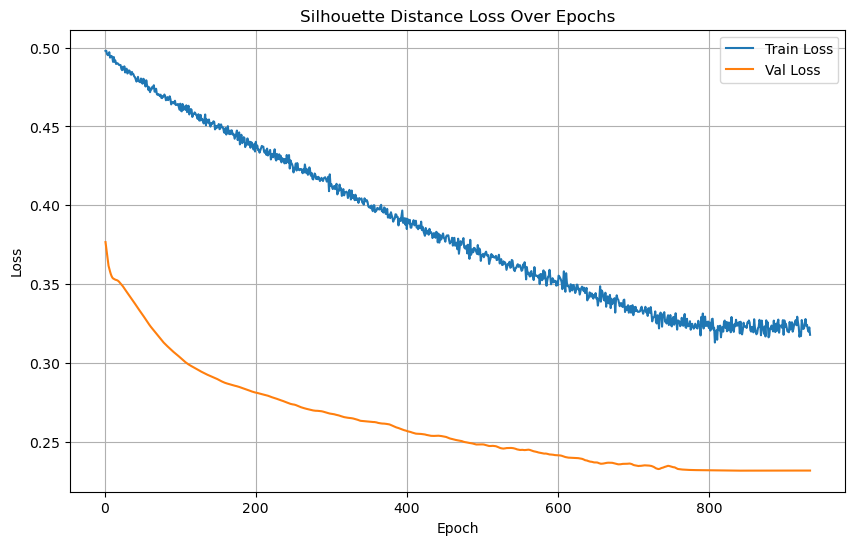

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/150], Loss: 0.2206
Test Batch [20/150], Loss: 0.2415
Test Batch [30/150], Loss: 0.3229


Test Batch [40/150], Loss: 0.4584
Test Batch [50/150], Loss: 0.4459
Test Batch [60/150], Loss: 0.3866
Test Batch [70/150], Loss: 0.3118


Test Batch [80/150], Loss: 0.3493
Test Batch [90/150], Loss: 0.1707
Test Batch [100/150], Loss: 0.1499
Test Batch [110/150], Loss: 0.2810
Test Batch [120/150], Loss: 0.0937


Test Batch [130/150], Loss: 0.3927
Test Batch [140/150], Loss: 0.2889
Test Batch [150/150], Loss: 0.1612

Test Loss: 0.3041


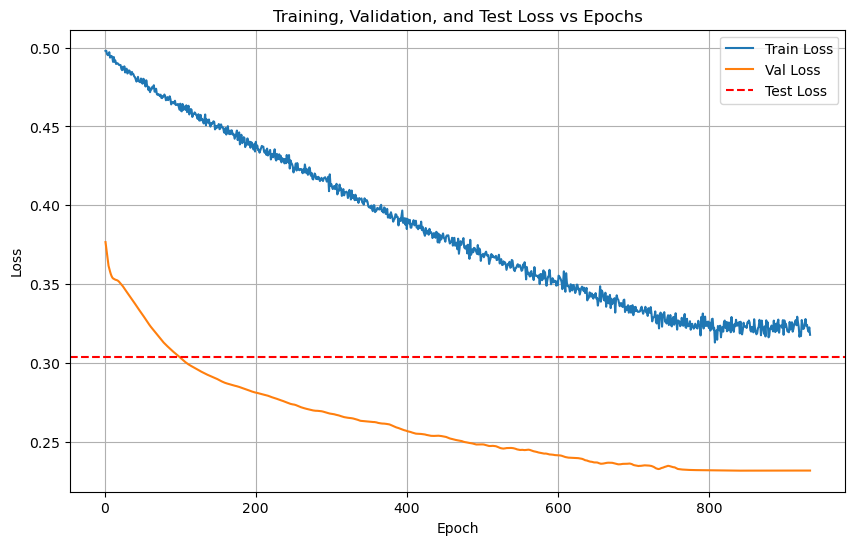

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/150 for test dataset.
  Processed batch 20/150 for test dataset.


  Processed batch 30/150 for test dataset.
  Processed batch 40/150 for test dataset.
  Processed batch 50/150 for test dataset.


  Processed batch 60/150 for test dataset.
  Processed batch 70/150 for test dataset.
  Processed batch 80/150 for test dataset.
  Processed batch 90/150 for test dataset.


  Processed batch 100/150 for test dataset.
  Processed batch 110/150 for test dataset.
  Processed batch 120/150 for test dataset.
  Processed batch 130/150 for test dataset.


  Processed batch 140/150 for test dataset.
  Processed batch 150/150 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 70.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.33      0.20      0.25         5
           2       0.33      0.40      0.36         5
           3       1.00      0.80      0.89         5
           4       1.00      0.40      0.57         5
           5       0.71      1.00      0.83         5
           6       0.00      0.00      0.00         0
           7       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       0.20      0.20      0.20         5
          11       0.40      0.40      0.40         5
          12       0.83      1.00      0.91         5
          13       0.62      1.00      0.77         5
          14       1.0

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (9571, 128)
Test labels shape: (9571,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9184  |  Val Loss: 2.8287
Validation loss improved from inf to 2.8287.
[Epoch 2/1000] Train Loss: 2.8718  |  Val Loss: 2.7949
Validation loss improved from 2.8287 to 2.7949.
[Epoch 3/1000] Train Loss: 2.8263  |  Val Loss: 2.7623
Validation loss improved from 2.7949 to 2.7623.
[Epoch 4/1000] Train Loss: 2.7827  |  Val Loss: 2.7333
Validation loss improved from 2.7623 to 2.7333.
[Epoch 5/1000] Train Loss: 2.7475  |  Val Loss: 2.7064
Validation loss improved from 2.7333 to 2.7064.


[Epoch 6/1000] Train Loss: 2.7151  |  Val Loss: 2.6807
Validation loss improved from 2.7064 to 2.6807.
[Epoch 7/1000] Train Loss: 2.6849  |  Val Loss: 2.6566
Validation loss improved from 2.6807 to 2.6566.
[Epoch 8/1000] Train Loss: 2.6559  |  Val Loss: 2.6350
Validation loss improved from 2.6566 to 2.6350.
[Epoch 9/1000] Train Loss: 2.6309  |  Val Loss: 2.6156
Validation loss improved from 2.6350 to 2.6156.
[Epoch 10/1000] Train Loss: 2.6070  |  Val Loss: 2.5978
Validation loss improved from 2.6156 to 2.5978.
[Epoch 11/1000] Train Loss: 2.5869  |  Val Loss: 2.5814
Validation loss improved from 2.5978 to 2.5814.
[Epoch 12/1000] Train Loss: 2.5695  |  Val Loss: 2.5659
Validation loss improved from 2.5814 to 2.5659.
[Epoch 13/1000] Train Loss: 2.5507  |  Val Loss: 2.5512
Validation loss improved from 2.5659 to 2.5512.
[Epoch 14/1000] Train Loss: 2.5333  |  Val Loss: 2.5374
Validation loss improved from 2.5512 to 2.5374.
[Epoch 15/1000] Train Loss: 2.5174  |  Val Loss: 2.5241
Validation l

[Epoch 17/1000] Train Loss: 2.4872  |  Val Loss: 2.4982
Validation loss improved from 2.5112 to 2.4982.
[Epoch 18/1000] Train Loss: 2.4722  |  Val Loss: 2.4861
Validation loss improved from 2.4982 to 2.4861.
[Epoch 19/1000] Train Loss: 2.4587  |  Val Loss: 2.4740
Validation loss improved from 2.4861 to 2.4740.
[Epoch 20/1000] Train Loss: 2.4453  |  Val Loss: 2.4622
Validation loss improved from 2.4740 to 2.4622.
[Epoch 21/1000] Train Loss: 2.4324  |  Val Loss: 2.4507
Validation loss improved from 2.4622 to 2.4507.
[Epoch 22/1000] Train Loss: 2.4207  |  Val Loss: 2.4393
Validation loss improved from 2.4507 to 2.4393.
[Epoch 23/1000] Train Loss: 2.4077  |  Val Loss: 2.4278
Validation loss improved from 2.4393 to 2.4278.
[Epoch 24/1000] Train Loss: 2.3952  |  Val Loss: 2.4165
Validation loss improved from 2.4278 to 2.4165.
[Epoch 25/1000] Train Loss: 2.3829  |  Val Loss: 2.4045
Validation loss improved from 2.4165 to 2.4045.


[Epoch 26/1000] Train Loss: 2.3707  |  Val Loss: 2.3925
Validation loss improved from 2.4045 to 2.3925.
[Epoch 27/1000] Train Loss: 2.3576  |  Val Loss: 2.3805
Validation loss improved from 2.3925 to 2.3805.
[Epoch 28/1000] Train Loss: 2.3451  |  Val Loss: 2.3683
Validation loss improved from 2.3805 to 2.3683.
[Epoch 29/1000] Train Loss: 2.3326  |  Val Loss: 2.3557
Validation loss improved from 2.3683 to 2.3557.
[Epoch 30/1000] Train Loss: 2.3195  |  Val Loss: 2.3431
Validation loss improved from 2.3557 to 2.3431.
[Epoch 31/1000] Train Loss: 2.3069  |  Val Loss: 2.3306
Validation loss improved from 2.3431 to 2.3306.
[Epoch 32/1000] Train Loss: 2.2937  |  Val Loss: 2.3176
Validation loss improved from 2.3306 to 2.3176.
[Epoch 33/1000] Train Loss: 2.2808  |  Val Loss: 2.3044
Validation loss improved from 2.3176 to 2.3044.
[Epoch 34/1000] Train Loss: 2.2671  |  Val Loss: 2.2910
Validation loss improved from 2.3044 to 2.2910.
[Epoch 35/1000] Train Loss: 2.2534  |  Val Loss: 2.2778
Validati

[Epoch 36/1000] Train Loss: 2.2398  |  Val Loss: 2.2641
Validation loss improved from 2.2778 to 2.2641.
[Epoch 37/1000] Train Loss: 2.2258  |  Val Loss: 2.2503
Validation loss improved from 2.2641 to 2.2503.
[Epoch 38/1000] Train Loss: 2.2112  |  Val Loss: 2.2363
Validation loss improved from 2.2503 to 2.2363.
[Epoch 39/1000] Train Loss: 2.1964  |  Val Loss: 2.2221
Validation loss improved from 2.2363 to 2.2221.
[Epoch 40/1000] Train Loss: 2.1812  |  Val Loss: 2.2078
Validation loss improved from 2.2221 to 2.2078.
[Epoch 41/1000] Train Loss: 2.1665  |  Val Loss: 2.1929
Validation loss improved from 2.2078 to 2.1929.
[Epoch 42/1000] Train Loss: 2.1515  |  Val Loss: 2.1776
Validation loss improved from 2.1929 to 2.1776.
[Epoch 43/1000] Train Loss: 2.1355  |  Val Loss: 2.1621
Validation loss improved from 2.1776 to 2.1621.


[Epoch 44/1000] Train Loss: 2.1193  |  Val Loss: 2.1460
Validation loss improved from 2.1621 to 2.1460.
[Epoch 45/1000] Train Loss: 2.1025  |  Val Loss: 2.1296
Validation loss improved from 2.1460 to 2.1296.
[Epoch 46/1000] Train Loss: 2.0861  |  Val Loss: 2.1129
Validation loss improved from 2.1296 to 2.1129.
[Epoch 47/1000] Train Loss: 2.0684  |  Val Loss: 2.0961
Validation loss improved from 2.1129 to 2.0961.
[Epoch 48/1000] Train Loss: 2.0506  |  Val Loss: 2.0786
Validation loss improved from 2.0961 to 2.0786.
[Epoch 49/1000] Train Loss: 2.0327  |  Val Loss: 2.0609
Validation loss improved from 2.0786 to 2.0609.
[Epoch 50/1000] Train Loss: 2.0140  |  Val Loss: 2.0426
Validation loss improved from 2.0609 to 2.0426.
[Epoch 51/1000] Train Loss: 1.9954  |  Val Loss: 2.0240
Validation loss improved from 2.0426 to 2.0240.
[Epoch 52/1000] Train Loss: 1.9763  |  Val Loss: 2.0052
Validation loss improved from 2.0240 to 2.0052.
[Epoch 53/1000] Train Loss: 1.9574  |  Val Loss: 1.9859
Validati

[Epoch 56/1000] Train Loss: 1.8979  |  Val Loss: 1.9276
Validation loss improved from 1.9473 to 1.9276.
[Epoch 57/1000] Train Loss: 1.8782  |  Val Loss: 1.9079
Validation loss improved from 1.9276 to 1.9079.
[Epoch 58/1000] Train Loss: 1.8572  |  Val Loss: 1.8885
Validation loss improved from 1.9079 to 1.8885.
[Epoch 59/1000] Train Loss: 1.8372  |  Val Loss: 1.8688
Validation loss improved from 1.8885 to 1.8688.


[Epoch 60/1000] Train Loss: 1.8174  |  Val Loss: 1.8489
Validation loss improved from 1.8688 to 1.8489.
[Epoch 61/1000] Train Loss: 1.7966  |  Val Loss: 1.8291
Validation loss improved from 1.8489 to 1.8291.
[Epoch 62/1000] Train Loss: 1.7766  |  Val Loss: 1.8091
Validation loss improved from 1.8291 to 1.8091.
[Epoch 63/1000] Train Loss: 1.7561  |  Val Loss: 1.7896
Validation loss improved from 1.8091 to 1.7896.
[Epoch 64/1000] Train Loss: 1.7359  |  Val Loss: 1.7694
Validation loss improved from 1.7896 to 1.7694.
[Epoch 65/1000] Train Loss: 1.7153  |  Val Loss: 1.7496
Validation loss improved from 1.7694 to 1.7496.
[Epoch 66/1000] Train Loss: 1.6955  |  Val Loss: 1.7300
Validation loss improved from 1.7496 to 1.7300.
[Epoch 67/1000] Train Loss: 1.6752  |  Val Loss: 1.7104
Validation loss improved from 1.7300 to 1.7104.
[Epoch 68/1000] Train Loss: 1.6545  |  Val Loss: 1.6911
Validation loss improved from 1.7104 to 1.6911.
[Epoch 69/1000] Train Loss: 1.6346  |  Val Loss: 1.6719
Validati

[Epoch 74/1000] Train Loss: 1.5344  |  Val Loss: 1.5780
Validation loss improved from 1.5961 to 1.5780.
[Epoch 75/1000] Train Loss: 1.5149  |  Val Loss: 1.5597
Validation loss improved from 1.5780 to 1.5597.
[Epoch 76/1000] Train Loss: 1.4956  |  Val Loss: 1.5418
Validation loss improved from 1.5597 to 1.5418.
[Epoch 77/1000] Train Loss: 1.4763  |  Val Loss: 1.5242
Validation loss improved from 1.5418 to 1.5242.


[Epoch 78/1000] Train Loss: 1.4569  |  Val Loss: 1.5069
Validation loss improved from 1.5242 to 1.5069.
[Epoch 79/1000] Train Loss: 1.4383  |  Val Loss: 1.4899
Validation loss improved from 1.5069 to 1.4899.
[Epoch 80/1000] Train Loss: 1.4195  |  Val Loss: 1.4723
Validation loss improved from 1.4899 to 1.4723.
[Epoch 81/1000] Train Loss: 1.4007  |  Val Loss: 1.4557
Validation loss improved from 1.4723 to 1.4557.
[Epoch 82/1000] Train Loss: 1.3827  |  Val Loss: 1.4397
Validation loss improved from 1.4557 to 1.4397.
[Epoch 83/1000] Train Loss: 1.3646  |  Val Loss: 1.4241
Validation loss improved from 1.4397 to 1.4241.
[Epoch 84/1000] Train Loss: 1.3464  |  Val Loss: 1.4086
Validation loss improved from 1.4241 to 1.4086.
[Epoch 85/1000] Train Loss: 1.3292  |  Val Loss: 1.3931
Validation loss improved from 1.4086 to 1.3931.
[Epoch 86/1000] Train Loss: 1.3119  |  Val Loss: 1.3776
Validation loss improved from 1.3931 to 1.3776.
[Epoch 87/1000] Train Loss: 1.2946  |  Val Loss: 1.3628
Validati

[Epoch 94/1000] Train Loss: 1.1815  |  Val Loss: 1.2665
Validation loss improved from 1.2793 to 1.2665.
[Epoch 95/1000] Train Loss: 1.1661  |  Val Loss: 1.2528
Validation loss improved from 1.2665 to 1.2528.
[Epoch 96/1000] Train Loss: 1.1505  |  Val Loss: 1.2396
Validation loss improved from 1.2528 to 1.2396.
[Epoch 97/1000] Train Loss: 1.1352  |  Val Loss: 1.2278
Validation loss improved from 1.2396 to 1.2278.


[Epoch 98/1000] Train Loss: 1.1198  |  Val Loss: 1.2153
Validation loss improved from 1.2278 to 1.2153.
[Epoch 99/1000] Train Loss: 1.1052  |  Val Loss: 1.2028
Validation loss improved from 1.2153 to 1.2028.
[Epoch 100/1000] Train Loss: 1.0900  |  Val Loss: 1.1907
Validation loss improved from 1.2028 to 1.1907.
[Epoch 101/1000] Train Loss: 1.0753  |  Val Loss: 1.1791
Validation loss improved from 1.1907 to 1.1791.
[Epoch 102/1000] Train Loss: 1.0607  |  Val Loss: 1.1678
Validation loss improved from 1.1791 to 1.1678.
[Epoch 103/1000] Train Loss: 1.0469  |  Val Loss: 1.1569
Validation loss improved from 1.1678 to 1.1569.
[Epoch 104/1000] Train Loss: 1.0331  |  Val Loss: 1.1457
Validation loss improved from 1.1569 to 1.1457.
[Epoch 105/1000] Train Loss: 1.0192  |  Val Loss: 1.1348
Validation loss improved from 1.1457 to 1.1348.
[Epoch 106/1000] Train Loss: 1.0057  |  Val Loss: 1.1244
Validation loss improved from 1.1348 to 1.1244.
[Epoch 107/1000] Train Loss: 0.9927  |  Val Loss: 1.1141


[Epoch 113/1000] Train Loss: 0.9189  |  Val Loss: 1.0579
Validation loss improved from 1.0678 to 1.0579.
[Epoch 114/1000] Train Loss: 0.9077  |  Val Loss: 1.0495
Validation loss improved from 1.0579 to 1.0495.
[Epoch 115/1000] Train Loss: 0.8957  |  Val Loss: 1.0413
Validation loss improved from 1.0495 to 1.0413.


[Epoch 116/1000] Train Loss: 0.8850  |  Val Loss: 1.0331
Validation loss improved from 1.0413 to 1.0331.
[Epoch 117/1000] Train Loss: 0.8738  |  Val Loss: 1.0244
Validation loss improved from 1.0331 to 1.0244.
[Epoch 118/1000] Train Loss: 0.8625  |  Val Loss: 1.0170
Validation loss improved from 1.0244 to 1.0170.
[Epoch 119/1000] Train Loss: 0.8524  |  Val Loss: 1.0091
Validation loss improved from 1.0170 to 1.0091.
[Epoch 120/1000] Train Loss: 0.8416  |  Val Loss: 1.0018
Validation loss improved from 1.0091 to 1.0018.
[Epoch 121/1000] Train Loss: 0.8314  |  Val Loss: 0.9940
Validation loss improved from 1.0018 to 0.9940.
[Epoch 122/1000] Train Loss: 0.8214  |  Val Loss: 0.9864
Validation loss improved from 0.9940 to 0.9864.
[Epoch 123/1000] Train Loss: 0.8118  |  Val Loss: 0.9793
Validation loss improved from 0.9864 to 0.9793.
[Epoch 124/1000] Train Loss: 0.8022  |  Val Loss: 0.9733
Validation loss improved from 0.9793 to 0.9733.
[Epoch 125/1000] Train Loss: 0.7926  |  Val Loss: 0.966

[Epoch 132/1000] Train Loss: 0.7321  |  Val Loss: 0.9255
Validation loss improved from 0.9308 to 0.9255.
[Epoch 133/1000] Train Loss: 0.7244  |  Val Loss: 0.9200
Validation loss improved from 0.9255 to 0.9200.
[Epoch 134/1000] Train Loss: 0.7166  |  Val Loss: 0.9151
Validation loss improved from 0.9200 to 0.9151.
[Epoch 135/1000] Train Loss: 0.7092  |  Val Loss: 0.9110
Validation loss improved from 0.9151 to 0.9110.
[Epoch 136/1000] Train Loss: 0.7021  |  Val Loss: 0.9059
Validation loss improved from 0.9110 to 0.9059.
[Epoch 137/1000] Train Loss: 0.6946  |  Val Loss: 0.9002
Validation loss improved from 0.9059 to 0.9002.
[Epoch 138/1000] Train Loss: 0.6878  |  Val Loss: 0.8972
Validation loss improved from 0.9002 to 0.8972.
[Epoch 139/1000] Train Loss: 0.6806  |  Val Loss: 0.8928
Validation loss improved from 0.8972 to 0.8928.
[Epoch 140/1000] Train Loss: 0.6737  |  Val Loss: 0.8890
Validation loss improved from 0.8928 to 0.8890.
[Epoch 141/1000] Train Loss: 0.6674  |  Val Loss: 0.884

[Epoch 151/1000] Train Loss: 0.6087  |  Val Loss: 0.8505
Validation loss improved from 0.8531 to 0.8505.
[Epoch 152/1000] Train Loss: 0.6036  |  Val Loss: 0.8469
Validation loss improved from 0.8505 to 0.8469.
[Epoch 153/1000] Train Loss: 0.5982  |  Val Loss: 0.8437
Validation loss improved from 0.8469 to 0.8437.
[Epoch 154/1000] Train Loss: 0.5935  |  Val Loss: 0.8402
Validation loss improved from 0.8437 to 0.8402.
[Epoch 155/1000] Train Loss: 0.5883  |  Val Loss: 0.8363
Validation loss improved from 0.8402 to 0.8363.
[Epoch 156/1000] Train Loss: 0.5835  |  Val Loss: 0.8329
Validation loss improved from 0.8363 to 0.8329.
[Epoch 157/1000] Train Loss: 0.5788  |  Val Loss: 0.8297
Validation loss improved from 0.8329 to 0.8297.
[Epoch 158/1000] Train Loss: 0.5742  |  Val Loss: 0.8281
Validation loss improved from 0.8297 to 0.8281.
[Epoch 159/1000] Train Loss: 0.5695  |  Val Loss: 0.8259
Validation loss improved from 0.8281 to 0.8259.
[Epoch 160/1000] Train Loss: 0.5651  |  Val Loss: 0.824

[Epoch 170/1000] Train Loss: 0.5250  |  Val Loss: 0.8052
Validation loss improved from 0.8068 to 0.8052.
[Epoch 171/1000] Train Loss: 0.5208  |  Val Loss: 0.8024
Validation loss improved from 0.8052 to 0.8024.
[Epoch 172/1000] Train Loss: 0.5175  |  Val Loss: 0.7998
Validation loss improved from 0.8024 to 0.7998.
[Epoch 173/1000] Train Loss: 0.5142  |  Val Loss: 0.7986
Validation loss improved from 0.7998 to 0.7986.
[Epoch 174/1000] Train Loss: 0.5105  |  Val Loss: 0.7968
Validation loss improved from 0.7986 to 0.7968.
[Epoch 175/1000] Train Loss: 0.5071  |  Val Loss: 0.7957
Validation loss improved from 0.7968 to 0.7957.
[Epoch 176/1000] Train Loss: 0.5037  |  Val Loss: 0.7942
Validation loss improved from 0.7957 to 0.7942.
[Epoch 177/1000] Train Loss: 0.5006  |  Val Loss: 0.7931
Validation loss improved from 0.7942 to 0.7931.
[Epoch 178/1000] Train Loss: 0.4974  |  Val Loss: 0.7902
Validation loss improved from 0.7931 to 0.7902.
[Epoch 179/1000] Train Loss: 0.4944  |  Val Loss: 0.789

[Epoch 188/1000] Train Loss: 0.4677  |  Val Loss: 0.7788
Validation loss improved from 0.7800 to 0.7788.
[Epoch 189/1000] Train Loss: 0.4650  |  Val Loss: 0.7791
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 0.4621  |  Val Loss: 0.7780
Validation loss improved from 0.7788 to 0.7780.
[Epoch 191/1000] Train Loss: 0.4601  |  Val Loss: 0.7781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 192/1000] Train Loss: 0.4569  |  Val Loss: 0.7764
Validation loss improved from 0.7780 to 0.7764.
[Epoch 193/1000] Train Loss: 0.4546  |  Val Loss: 0.7750
Validation loss improved from 0.7764 to 0.7750.
[Epoch 194/1000] Train Loss: 0.4519  |  Val Loss: 0.7741
Validation loss improved from 0.7750 to 0.7741.
[Epoch 195/1000] Train Loss: 0.4497  |  Val Loss: 0.7726
Validation loss improved from 0.7741 to 0.7726.
[Epoch 196/1000] Train Loss: 0.4471  |  Val Loss: 0.7720
Validation loss improved from 0.7726 to 0.7720.
[Epoch 197/1000] Train Loss: 0.4449  |  Val

[Epoch 205/1000] Train Loss: 0.4266  |  Val Loss: 0.7653
Validation loss improved from 0.7657 to 0.7653.
[Epoch 206/1000] Train Loss: 0.4243  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 0.4225  |  Val Loss: 0.7657
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.4203  |  Val Loss: 0.7663
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 0.4180  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 0.4159  |  Val Loss: 0.7637
Validation loss improved from 0.7653 to 0.7637.
[Epoch 211/1000] Train Loss: 0.4139  |  Val Loss: 0.7631
Validation loss improved from 0.7637 to 0.7631.
[Epoch 212/1000] Train Loss: 0.4121  |  Val Loss: 0.7622
Validation loss improved from 0.7631 to 0.7622.
[Epoch 213/1000] Train Loss: 0.4102  |  Val Loss: 0.7610
Validation loss improved from 0.7622 to 0.7610.
[Epoch 214/1000] Train Loss: 0.

[Epoch 224/1000] Train Loss: 0.3900  |  Val Loss: 0.7574
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.3883  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 226/1000] Train Loss: 0.3867  |  Val Loss: 0.7571
Validation loss improved from 0.7574 to 0.7571.
[Epoch 227/1000] Train Loss: 0.3849  |  Val Loss: 0.7568
Validation loss improved from 0.7571 to 0.7568.
[Epoch 228/1000] Train Loss: 0.3836  |  Val Loss: 0.7583
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.3820  |  Val Loss: 0.7570
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 230/1000] Train Loss: 0.3801  |  Val Loss: 0.7558
Validation loss improved from 0.7568 to 0.7558.
[Epoch 231/1000] Train Loss: 0.3786  |  Val Loss: 0.7555
Validation loss improved from 0.7558 to 0.7555.
[Epoch 232/1000] Train Loss: 0.3771  |  Val Loss: 0.7548
Validation loss improved from 0.7555 to 0.7548.
[Epoch 233/1000] Train Loss: 0.

[Epoch 242/1000] Train Loss: 0.3624  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 243/1000] Train Loss: 0.3611  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 244/1000] Train Loss: 0.3595  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 245/1000] Train Loss: 0.3581  |  Val Loss: 0.7525
Validation loss improved from 0.7535 to 0.7525.
[Epoch 246/1000] Train Loss: 0.3570  |  Val Loss: 0.7531
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 247/1000] Train Loss: 0.3558  |  Val Loss: 0.7536
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 248/1000] Train Loss: 0.3543  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 249/1000] Train Loss: 0.3531  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 250/1000] Train Loss: 0.3520  |  Val Loss: 0.7539
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 262/1000] Train Loss: 0.3370  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 263/1000] Train Loss: 0.3362  |  Val Loss: 0.7524
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 264/1000] Train Loss: 0.3349  |  Val Loss: 0.7535
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 265/1000] Train Loss: 0.3339  |  Val Loss: 0.7543
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 266/1000] Train Loss: 0.3325  |  Val Loss: 0.7539
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 267/1000] Train Loss: 0.3315  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 268/1000] Train Loss: 0.3301  |  Val Loss: 0.7530
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 269/1000] Train Loss: 0.3290  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 270/1000] Train Loss: 0.3282  |  Val Loss: 0.7538
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 282/1000] Train Loss: 0.3159  |  Val Loss: 0.7536
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 283/1000] Train Loss: 0.3146  |  Val Loss: 0.7534
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 284/1000] Train Loss: 0.3136  |  Val Loss: 0.7548
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 285/1000] Train Loss: 0.3129  |  Val Loss: 0.7571
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 286/1000] Train Loss: 0.3120  |  Val Loss: 0.7556
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 287/1000] Train Loss: 0.3111  |  Val Loss: 0.7556
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 288/1000] Train Loss: 0.3108  |  Val Loss: 0.7577
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 289/1000] Train Loss: 0.3090  |  Val Loss: 0.7562
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 290/1000] Train Loss: 0.3080  |  Val Loss: 0.7570
!! Validation loss did NOT improve !! Patience:

[Epoch 301/1000] Train Loss: 0.2988  |  Val Loss: 0.7588
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 302/1000] Train Loss: 0.2977  |  Val Loss: 0.7604
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 303/1000] Train Loss: 0.2966  |  Val Loss: 0.7606
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 304/1000] Train Loss: 0.2961  |  Val Loss: 0.7606
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 305/1000] Train Loss: 0.2951  |  Val Loss: 0.7595
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 306/1000] Train Loss: 0.2941  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 307/1000] Train Loss: 0.2934  |  Val Loss: 0.7612
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 308/1000] Train Loss: 0.2926  |  Val Loss: 0.7613
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 309/1000] Train Loss: 0.2916  |  Val Loss: 0.7627
!! Validation loss did NOT improve !! Patience:

[Epoch 320/1000] Train Loss: 0.2829  |  Val Loss: 0.7650
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 321/1000] Train Loss: 0.2824  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 322/1000] Train Loss: 0.2817  |  Val Loss: 0.7671
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 323/1000] Train Loss: 0.2810  |  Val Loss: 0.7666
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 324/1000] Train Loss: 0.2802  |  Val Loss: 0.7671
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 325/1000] Train Loss: 0.2793  |  Val Loss: 0.7676
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 326/1000] Train Loss: 0.2785  |  Val Loss: 0.7704
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 327/1000] Train Loss: 0.2781  |  Val Loss: 0.7694
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 328/1000] Train Loss: 0.2773  |  Val Loss: 0.7702
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.2695  |  Val Loss: 0.7740
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 340/1000] Train Loss: 0.2685  |  Val Loss: 0.7750
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 341/1000] Train Loss: 0.2681  |  Val Loss: 0.7731
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 342/1000] Train Loss: 0.2672  |  Val Loss: 0.7737
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 343/1000] Train Loss: 0.2666  |  Val Loss: 0.7754
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 344/1000] Train Loss: 0.2660  |  Val Loss: 0.7779
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 345/1000] Train Loss: 0.2656  |  Val Loss: 0.7790
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 346/1000] Train Loss: 0.2645  |  Val Loss: 0.7762
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 347/1000] Train Loss: 0.2638  |  Val Loss: 0.7763
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 0.2570  |  Val Loss: 0.7804
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 358 !!
No improvement for 100 epochs.


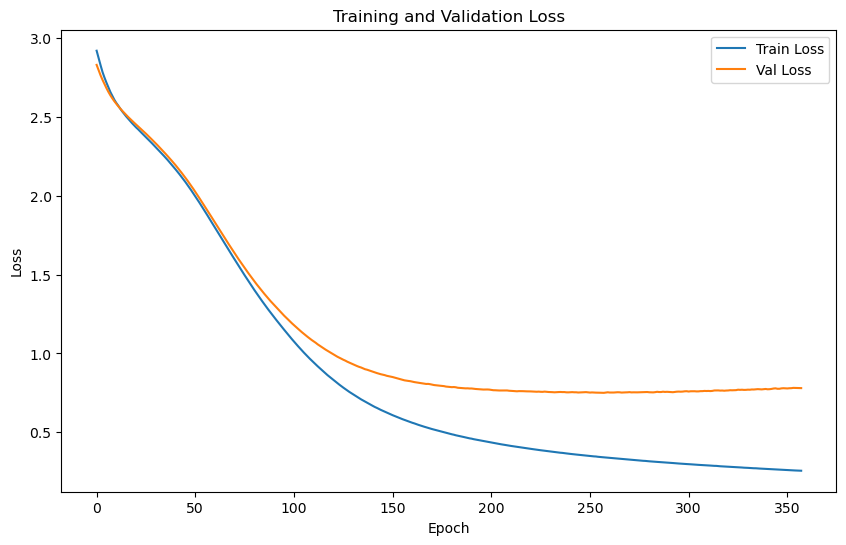

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.7419 | Test Accuracy: 56.23%


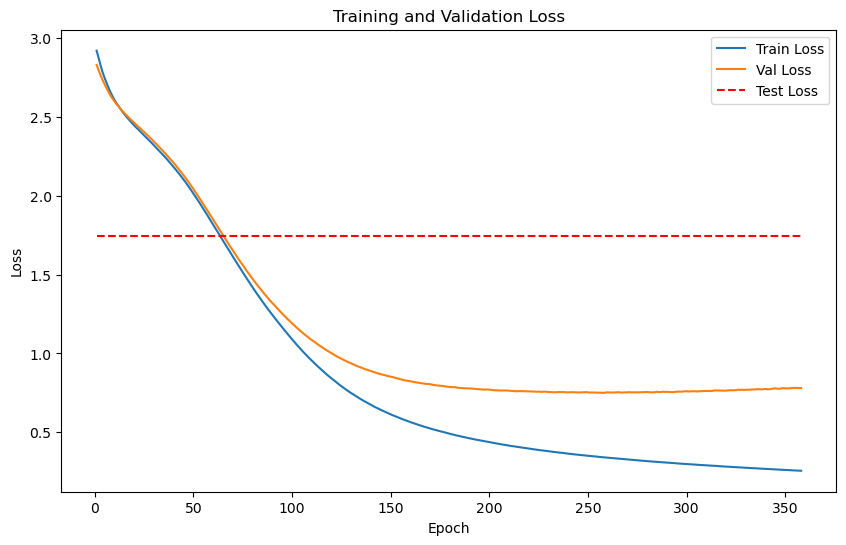

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


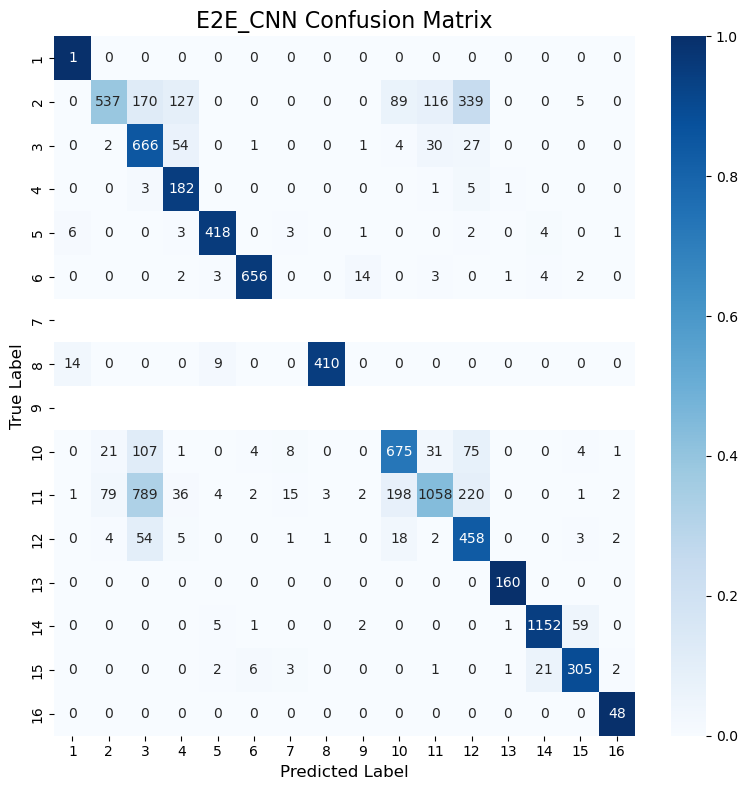

Classification Accuracy: 70.27%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


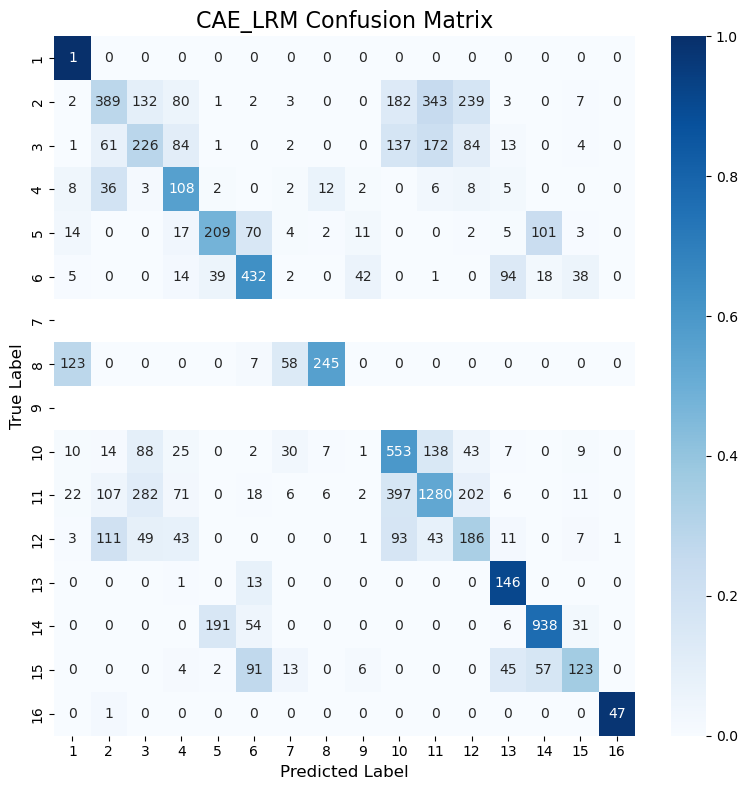

Classification Accuracy: 51.02%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


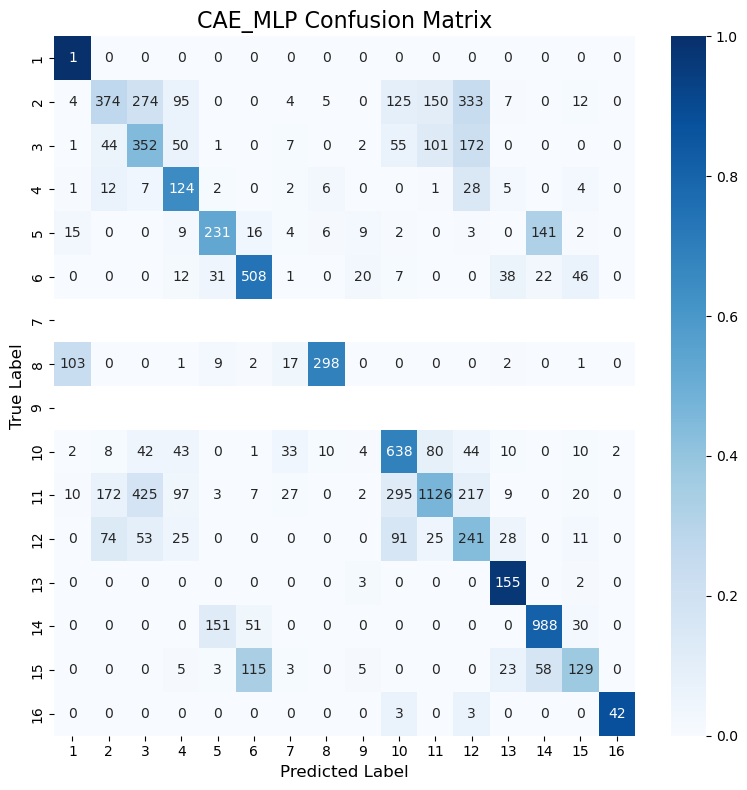

Classification Accuracy: 54.40%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


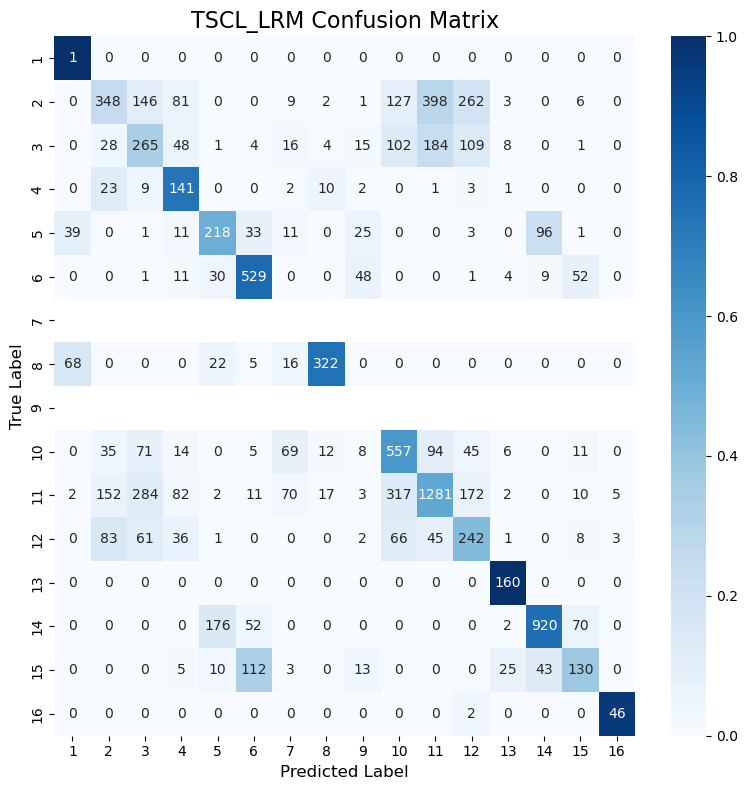

Classification Accuracy: 53.91%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


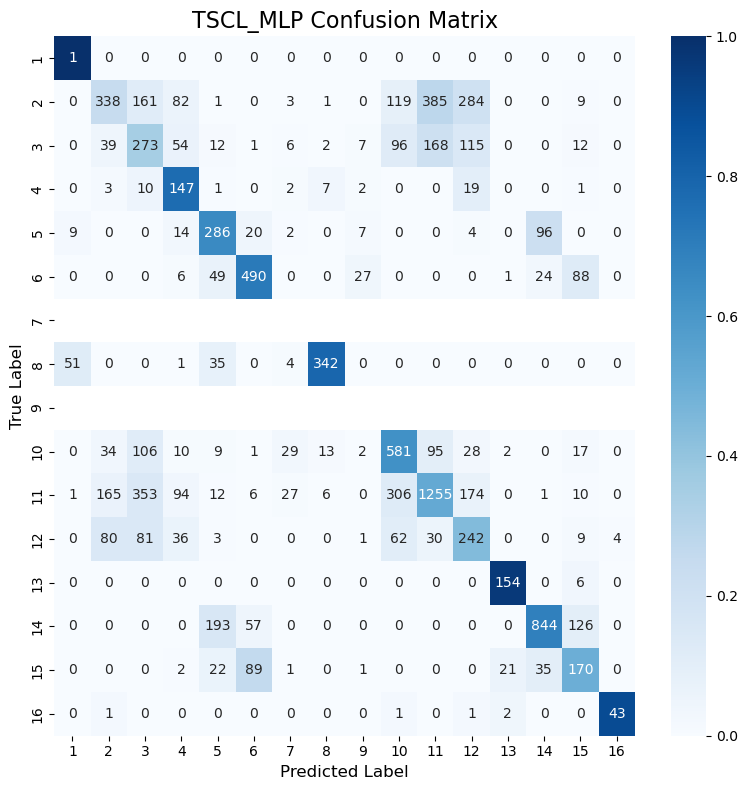

Classification Accuracy: 53.98%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


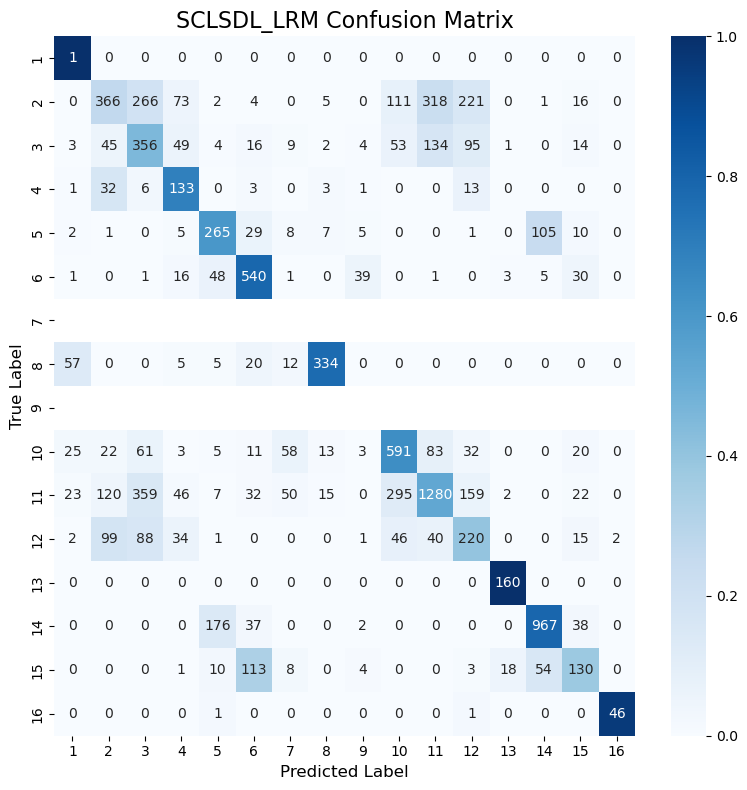

Classification Accuracy: 56.31%


C:\Users\vella\AppData\Local\Temp\ipykernel_4376\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


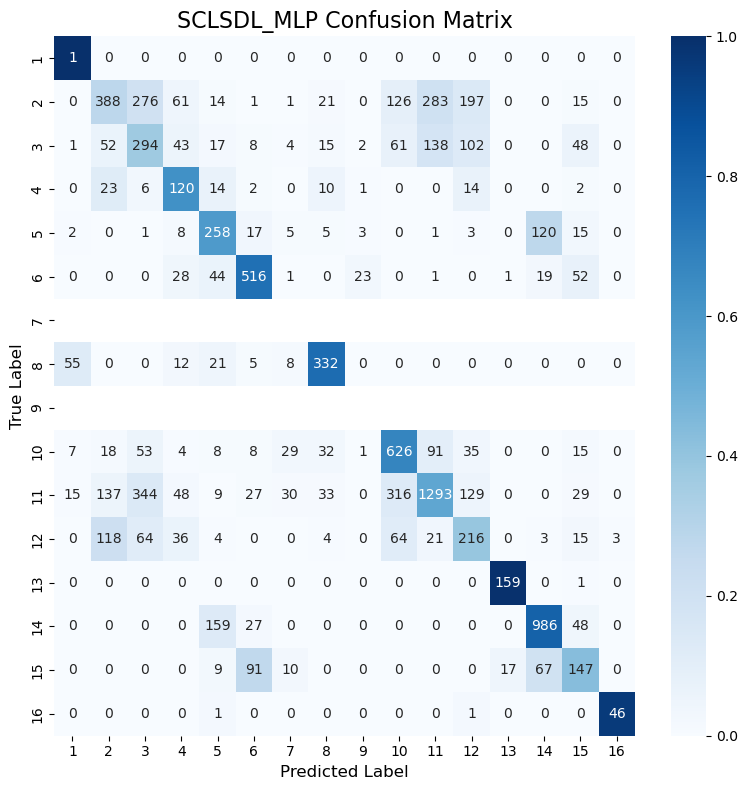

Classification Accuracy: 56.23%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          70.27
1    LRM (CAE)          51.02
2    MLP (CAE)          54.40
3     TSCL LRM          53.91
4     TSCL MLP          53.98
5  SCL_SDL LRM          56.31
6  SCL_SDL MLP          56.23

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          70.27
5  SCL_SDL LRM          56.31
6  SCL_SDL MLP          56.23
2    MLP (CAE)          54.40
4     TSCL MLP          53.98
3     TSCL LRM          53.91
1    LRM (CAE)          51.02
